In [1]:
#!/usr/bin/env python3
import sys
srcdir = "/project/mchaisso_100/cmb-16/tsungyul/work/vntr/danbing-tk/script/"
sys.path.insert(0, srcdir)

In [2]:
import numpy as np
import pandas as pd
import vntrutils as vu
import utils
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
# %load_ext autoreload
# %autoreload 2

In [3]:
# from collections import defaultdict
import pickle
# import networkx as nx
# import pygraphviz
# import collections
import gc
# import glob
# import warnings
import statsmodels.api as sm
# from statsmodels.stats.multitest import fdrcorrection as fdr
# from scipy import stats
# import gzip
# from sklearn.decomposition import PCA
# from scipy.stats import chi2
# import re
# import json
# from scipy.optimize import curve_fit 
# from math import factorial
# import copy
# from sklearn import svm
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler

In [4]:
matplotlib.rc('font', size=7)
matplotlib.rc('axes', titlesize=7)
matplotlib.rc('xtick', labelsize=5)
matplotlib.rc('ytick', labelsize=5)
%load_ext autoreload
%autoreload 2

- do not treat a motif as invariant unless all kmers are invariant
    - dosage averaging for motifs containing poly-A kmers can be biased
- [ ] use max count of a motif as a filter for unsupported motifs

- work notes
    - goal: remove bias from danbing genotypes
    - bias:
        - take invariant kmers from 48 HPRC asm
            - construct faht table
            - convert to facht table
            - find invariant motifs
        - compute bias in gtex genotypes
            - inverse variance weighting? 
    - eval
<!--         - motif dosage -->
        - TR dosage

In [ ]:
- changed variables
    - hi2trs -> trseqs
    - pbht -> faht
    - [removed from this notebook] pbcht -> facht
- r2 are computed from fitting with intercept

In [5]:
# def test():
#     with open("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hgsvc/clinic/cdbg/v1/ki_tr.ccki_tr.pickle", 'rb') as f:
#         ki_tr, ccki_tr = pickle.load(f)
#     return ki_tr, ccki_tr
# ki_tr, ccki_tr = test()

In [5]:
ki_tr = np.loadtxt("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hprc/full.v1/output8/pan.tr.ksi", dtype=int)

In [6]:
gsfile = "/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hprc/full.v1/input/genomes.HPRC.txt"
graph_dir = "/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hprc/full.v1/output8"
ilgsfile = "/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hprc/full.v1/analysis8/mapping/hprc/genomes.1kg_plus_related.gt_HPRC.txt"

In [7]:
def test():
    gs0 = np.loadtxt(gsfile, dtype=object)
    gs1 = np.loadtxt(ilgsfile, dtype=object)
    return np.isin(gs0, gs1)
gsmask = test()

In [8]:
def get_ki(tri):
    si = ki_tr[tri-1] if tri else 0
    ei = ki_tr[tri]
    return si, ei

In [9]:
def test():
    omap = pd.read_csv(f"{graph_dir}/OrthoMap.v2.tsv", sep="\t", header=None, na_values=".").to_numpy()
    omap[~np.isfinite(omap)] = -1
    return omap.astype(int)
omap = test()

In [10]:
def test():
    trlens_ = pd.read_csv("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hprc/full.v1/analysis8/trlen.all_haps.tsv", index_col=0, sep="\t").to_numpy()
    ntr, nh = trlens_.shape
    ng = nh//2
    trlens = np.full([ntr,ng], np.nan)
    for gi in range(ng):
        h0 = 2*gi
        trlens[:,gi] = np.mean(trlens_[:,h0:h0+2], axis=1)
    return trlens
trlens = test()

In [10]:
def test():
    gs = np.loadtxt(gsfile, dtype=object)
    hi2trs = {}
    trseqs = vu.ids2trseqs(gs, f"{graph_dir}/trfa/", omap, keepflank=True)
    return trseqs
trseqs = test()

In [26]:
hsup = omap != -1
pd.DataFrame(hsup)

0      1      2      3     4      5      6      7     8      9   ...  \
0      True   True  False  False  True   True  False  False  True   True  ...   
1      True   True  False  False  True   True   True   True  True   True  ...   
2      True   True  False  False  True   True   True   True  True   True  ...   
3      True   True  False  False  True   True   True   True  True   True  ...   
4      True   True  False  False  True   True   True   True  True   True  ...   
...     ...    ...    ...    ...   ...    ...    ...    ...   ...    ...  ...   
30483  True  False   True   True  True  False   True  False  True  False  ...   
30484  True  False   True   True  True  False   True  False  True  False  ...   
30485  True  False   True   True  True  False   True  False  True  False  ...   
30486  True  False   True   True  True  False   True  False  True  False  ...   
30487  True  False   True   True  True  False   True  False  True  False  ...   

         86    87    88    89    90     91    92    93     94     95  
0      True  True  True  True  True   True  True  True   True  False  
1      True  True  True  True  True   True  True  True   True  False  
2      True  True  True  True  True   True  True  True   True  False  
3      True  True  True  True  True   True  True  True   True  False  
4      True  True  True  True  True   True  True  True   True  False  
...     ...   ...   ...   ...   ...    ...   ...   ...    ...    ...  
30483  True  True  True  True  True  False  True  True  False   True  
30484  True  True  True  True  True  False  True  True  False   True  
30485  True  True  True  True  True  False  True  True  False   True  
30486  True  True  True  True  True  False  True  True  False   True  
30487  True  True  True  True  True  False  True  True  False   True  

[30488 rows x 96 columns]

In [144]:
def test():
    ntr, nh = hsup.shape 
    ng = nh // 2
    gsup_strict = np.zeros([ntr,ng], dtype=bool)
    gsup_lenient = np.zeros([ntr,ng], dtype=bool)
    for gi in range(ng):
        h0i = 2*gi
        h1i = 2*gi + 1
        gsup_strict[:,gi] = hsup[:,h0i] & hsup[:,h1i]
        gsup_lenient[:,gi] = hsup[:,h0i] | hsup[:,h1i]
    n0 = np.sum(~hsup)
    n1a = np.sum(~gsup_strict)
    n1b = np.sum(~gsup_lenient)
    print(f"{n0} loci X hap have no support (fasta seq)")
    print(f"{n1b} loci X genomes have no support (fasta seq)")
    print(f"{n1a-n1b} loci X genomes have partial support (one hap)")
    
    return gsup_strict, gsup_lenient
gsup_strict, gsup_lenient = test()

54233 loci X hap have no support (fasta seq)
8111 loci X genomes have no support (fasta seq)
38011 loci X genomes have partial support (one hap)


In [141]:
pd.DataFrame(gsup_strict)

0      1      2      3      4      5     6      7     8      9   \
0       True  False   True  False   True   True  True   True  True   True   
1       True  False   True   True   True   True  True   True  True   True   
2       True  False   True   True   True   True  True   True  True   True   
3       True  False   True   True   True   True  True   True  True   True   
4       True  False   True   True   True   True  True   True  True   True   
...      ...    ...    ...    ...    ...    ...   ...    ...   ...    ...   
30483  False   True  False  False  False  False  True  False  True  False   
30484  False   True  False  False  False  False  True  False  True  False   
30485  False   True  False  False  False  False  True  False  True  False   
30486  False   True  False  False  False  False  True  False  True  False   
30487  False   True  False  False  False  False  True  False  True  False   

       ...    38     39    40    41     42    43    44     45    46     47  
0      ...  True  False  True  True   True  True  True   True  True  False  
1      ...  True  False  True  True   True  True  True   True  True  False  
2      ...  True  False  True  True   True  True  True   True  True  False  
3      ...  True  False  True  True   True  True  True   True  True  False  
4      ...  True  False  True  True   True  True  True   True  True  False  
...    ...   ...    ...   ...   ...    ...   ...   ...    ...   ...    ...  
30483  ...  True  False  True  True  False  True  True  False  True  False  
30484  ...  True  False  True  True  False  True  True  False  True  False  
30485  ...  True  False  True  True  False  True  True  False  True  False  
30486  ...  True  False  True  True  False  True  True  False  True  False  
30487  ...  True  False  True  True  False  True  True  False  True  False  

[30488 rows x 48 columns]

In [10]:
def test():
    tri2km2i = {}
    km_arr = []
    with open(f"{graph_dir}/pan.reindex.tr.kmers") as f:
        tri = -1
        ki = -1
        for line in f:
            if line[0] == ">":
                tri += 1
                tri2km2i[tri] = {}
            else:
                ki += 1
                km = int(line.split()[0])
                tri2km2i[tri][km] = ki
                km_arr.append(km)
    return tri2km2i, np.array(km_arr)
tri2km2i, km_arr = test()

# compute haplotype/genotype matrix

In [42]:
def test():
    nk = ki_tr[-1]
    ntr = len(ki_tr)
    gs = np.loadtxt(gsfile, dtype=object)
    ng = gs.size
    nh = 2*ng
    faht = np.zeros([nk,nh], dtype=np.float32)
    
    print("Constructing table")
    n0 = 0
    for tri in range(ntr):
        for hi in range(nh):
            if not hsup[tri,hi]:
                si = ki_tr[tri-1] if tri else 0
                ei = ki_tr[tri]
                faht[si:ei,hi] = np.nan
                n0 += 1
    assert np.sum(~hsup) == n0
    print(f"{n0} loci X hap have no support (fasta seq)")
    
    print("Reading kmer counts")
    for gi, gn in enumerate(gs):
        for h in [0,1]:
            hi = 2*gi + h
            print(".", end="")
            with open(f"{graph_dir}/trfa/{gn}.{h}.tr.fasta") as f:
                gtri = -1
                gtris = np.nonzero(omap[:,hi]>=0)[0]
                for line in f:
                    if line[0] == ">":
                        gtri += 1
                        ptri = gtris[gtri]
                        km2i = tri2km2i[ptri]
                        # print(f"{hi}.{gtri}->{ptri}")
                    else:
                        kmers = vu.read2kmers_noshift(line[:-1], 21, leftflank=500, rightflank=500, dtype=int)
                        k2c = {}
                        for km in kmers:
                            if km < 0: continue
                            if km not in k2c:
                                k2c[km] = 1
                            else:
                                k2c[km] += 1
                        for km, ct in k2c.items():
                            ki = km2i[km]
                            faht[ki,hi] = ct
    return faht
faht = test()

Constructing table
54233 loci X hap have no support (fasta seq)
Reading kmer counts
................................................................................................

In [240]:
pd.DataFrame(faht)

0    1    2    3    4    5    6   7    8    9   ...   86   87   88  \
0         1.0  1.0  NaN  NaN  1.0  1.0  NaN NaN  1.0  2.0  ...  2.0  2.0  2.0   
1         2.0  2.0  NaN  NaN  2.0  2.0  NaN NaN  2.0  2.0  ...  2.0  2.0  2.0   
2         1.0  1.0  NaN  NaN  1.0  1.0  NaN NaN  1.0  1.0  ...  1.0  1.0  1.0   
3         0.0  0.0  NaN  NaN  0.0  0.0  NaN NaN  0.0  1.0  ...  1.0  1.0  1.0   
4         1.0  1.0  NaN  NaN  1.0  1.0  NaN NaN  1.0  2.0  ...  2.0  2.0  2.0   
...       ...  ...  ...  ...  ...  ...  ...  ..  ...  ...  ...  ...  ...  ...   
14752034  2.0  NaN  1.0  1.0  1.0  NaN  1.0 NaN  2.0  NaN  ...  2.0  2.0  2.0   
14752035  1.0  NaN  1.0  1.0  1.0  NaN  1.0 NaN  1.0  NaN  ...  1.0  1.0  1.0   
14752036  1.0  NaN  1.0  1.0  1.0  NaN  1.0 NaN  1.0  NaN  ...  1.0  1.0  1.0   
14752037  1.0  NaN  1.0  1.0  1.0  NaN  1.0 NaN  1.0  NaN  ...  1.0  1.0  1.0   
14752038  1.0  NaN  1.0  1.0  1.0  NaN  1.0 NaN  1.0  NaN  ...  1.0  1.0  1.0   

           89   90   91   92   93   94   95  
0         2.0  1.0  2.0  1.0  2.0  2.0  NaN  
1         2.0  2.0  2.0  2.0  2.0  2.0  NaN  
2         1.0  1.0  1.0  1.0  1.0  1.0  NaN  
3         1.0  0.0  1.0  0.0  1.0  1.0  NaN  
4         2.0  1.0  2.0  1.0  2.0  2.0  NaN  
...       ...  ...  ...  ...  ...  ...  ...  
14752034  2.0  2.0  NaN  2.0  1.0  NaN  1.0  
14752035  1.0  1.0  NaN  1.0  1.0  NaN  1.0  
14752036  1.0  1.0  NaN  1.0  1.0  NaN  1.0  
14752037  1.0  1.0  NaN  1.0  1.0  NaN  1.0  
14752038  1.0  1.0  NaN  1.0  1.0  NaN  1.0  

[14752039 rows x 96 columns]

In [49]:
def test():
    tmp = np.copy(faht)
    tmp[~np.isfinite(tmp)] = -1
    tmp = tmp.astype(int)
    np.savetxt(f"{graph_dir}/../analysis8/faht.tsv.gz", tmp, fmt="%s", delimiter="\t")
# test()

In [239]:
def test():
    tmp = np.loadtxt(f"{graph_dir}/../analysis8/faht.tsv.gz", dtype=np.float32)
    tmp[tmp == -1] = np.nan
    return tmp
faht = test()

In [103]:
def test():
    nk = ki_tr[-1]
    ntr = len(ki_tr)
    gs = np.loadtxt(gsfile, dtype=object)
    ng = gs.size
    nh = 2*ng

    fagt_strict = np.zeros([nk,ng], dtype=np.float32)
    fagt_lenient = np.zeros([nk,ng], dtype=np.float32)
    
    for gi, gn in enumerate(gs):
        h0 = 2 * gi
        fagt_strict[:,gi] = np.mean(faht[:,h0:h0+2], axis=1)
        fagt_lenient[:,gi] = np.nanmean(faht[:,h0:h0+2], axis=1)
        
    return fagt_strict, fagt_lenient
fagt_strict, fagt_lenient = test()

/tmp/SLURM_23521942/ipykernel_27991/4065362045.py:14: RuntimeWarning: Mean of empty slice
  fagt_lenient[gi] = np.nanmean(faht[h0:h0+2], axis=0)


In [106]:
def test():
    for name, mat in {"strict":fagt_strict, "lenient":fagt_lenient}.items():
        tmp = np.copy(mat)
        tmp[~np.isfinite(tmp)] = -1
        tmp = tmp.astype(int)
        np.savetxt(f"{graph_dir}/../analysis8/fagt_{name}.tsv.gz", tmp, fmt="%s", delimiter="\t")
# test()

In [11]:
fagt = np.loadtxt(f"{graph_dir}/../analysis8/fagt_strict.tsv.gz", dtype=float)
fagt[fagt==-1] = np.nan

# compute ikmer

In [48]:
def test():
    ng = np.loadtxt(gsfile, dtype=object).size
    nh = 2*ng
    nk = ki_tr[-1]
    ntr = len(ki_tr)
    ikmer = np.zeros(nk, dtype=bool)
    ikstats = np.full([nk,2], np.nan)
    
    for tri in range(ntr):
        si = ki_tr[tri-1] if tri else 0
        ei = ki_tr[tri]
        hm = omap[tri] != -1
        haps = faht[si:ei][:,hm]
        inv = np.all(haps == haps[:,0:1], axis=1)
        assert np.all(haps[:,0][inv] > 0)
        ikmer[si:ei] = inv
        ikstats[si:ei,0] = np.mean(haps, axis=1)
        ikstats[si:ei,1] = np.std(haps, axis=1)
    return ikmer, ikstats
ikmer, ikstats = test()

In [49]:
np.sum(ikmer), ikmer.size, f"{np.sum(ikmer)/ikmer.size:.1%}"

(5047359, 14752039, '34.2%')

In [55]:
# old

(32274198, 62457731, '51.7%')

In [71]:
pd.DataFrame(ikmer[:,None].T)

0         1         2         3         4         5         6         \
0     False     False      True     False     False     False     False   

   7         8         9         ...  14752029  14752030  14752031  14752032  \
0     False     False     False  ...     False     False      True     False   

   14752033  14752034  14752035  14752036  14752037  14752038  
0     False     False     False     False     False     False  

[1 rows x 14752039 columns]

In [72]:
pd.DataFrame(ikstats.T)

0         1         2         3         4         5         6         \
0       1.5  2.025641       1.0  0.474359       1.5  0.474359       1.5   
1       0.5  0.158062       0.0  0.499342       0.5  0.499342       0.5   

   7         8         9         ...  14752029  14752030  14752031  14752032  \
0  0.474359       1.5       1.5  ...  1.730159  1.730159       1.0  1.730159   
1  0.499342       0.5       0.5  ...  0.443877  0.443877       0.0  0.443877   

   14752033  14752034  14752035  14752036  14752037  14752038  
0  1.761905  1.730159  0.968254  0.968254  0.968254  0.968254  
1  0.425918  0.443877  0.175323  0.175323  0.175323  0.175323  

[2 rows x 14752039 columns]

In [60]:
def test():
    df = pd.DataFrame()
    df["is.ikmer"] = ikmer
    df["kmc.mn"] = ikstats[:,0]
    df["kmc.sd"] = ikstats[:,1]
    df.to_csv("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hprc/full.v1/analysis8/mapping/hprc/ikmer.annot.tsv.gz", sep="\t")
# test()

In [13]:
def test():
    df = pd.read_csv("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hprc/full.v1/analysis8/mapping/hprc/ikmer.annot.tsv.gz", sep="\t", index_col=0)
    return df.iloc[:,0].to_numpy(), df.iloc[:,1:].to_numpy()
ikmer, ikstats = test()

                  0
count  30488.000000
mean     165.552316
std      671.373711
min        0.000000
25%       36.000000
50%       85.000000
75%      158.000000
max    47651.000000


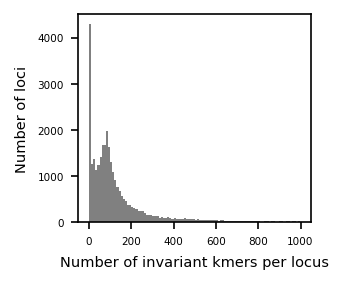

mean/median = 165.6/85.0
2926 (9.6%) loci w/o invariant kmers


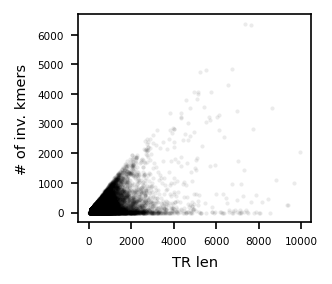

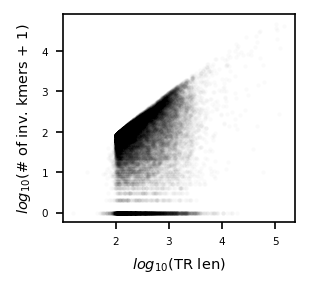

In [90]:
def test():
    mlen = pd.read_csv("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hprc/full.v1/analysis8/trlen.mn.sd.tsv", index_col=0, sep="\t").iloc[:,0]
    
    ng = np.loadtxt(gsfile, dtype=object).size
    nh = 2*ng
    nk = ki_tr[-1]
    ntr = len(ki_tr)
    ninv = np.zeros(ntr)
    for tri in range(ntr):
        si = ki_tr[tri-1] if tri else 0
        ei = ki_tr[tri]
        ninv[tri] = np.sum(ikmer[si:ei])
            # ikstats[1,si:ei] == 0)
    print(pd.DataFrame(ninv).describe())
    plt.figure(dpi=150, figsize=(2,1.8))
    plt.hist(ninv[ninv<1000], color='gray', bins=100)
    plt.xlabel("Number of invariant kmers per locus")
    plt.ylabel("Number of loci")
    plt.show(); plt.close()
    print(f"mean/median = {np.mean(ninv):.1f}/{np.median(ninv):.1f}")
    print(f"{np.sum(ninv==0)} ({np.sum(ninv==0)/len(ki_tr):.1%}) loci w/o invariant kmers")
    
    m = mlen < 10000
    utils.plot(mlen[m], ninv[m], "TR len", "# of inv. kmers", alpha=0.08, s=4)
    utils.plot(np.log10(mlen), np.log10(ninv+1), "$log_{10}$(TR len)", "$log_{10}$(# of inv. kmers + 1)", alpha=0.02, s=4)
test()

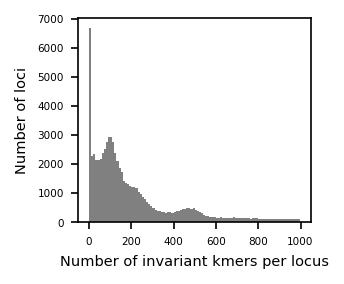

mean/median = 400.8/149.0
2764 (3.4%) loci w/o invariant kmers


In [171]:
# HGSVC old

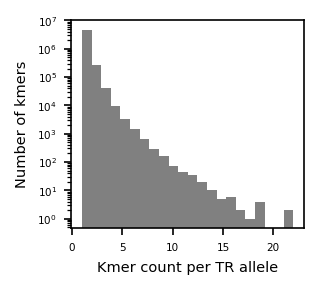

In [249]:
def test():
    m = ikstats[:,1] == 0
    x = ikstats[m,0]
    plt.figure(dpi=150, figsize=(2,1.8))
    plt.hist(x, color='gray', bins=int(max(x)))
    plt.yscale('log')
    plt.xlabel("Kmer count per TR allele")
    plt.ylabel("Number of kmers")
    plt.show(); plt.close()
test()

- (obsolete) HGSVC motif analysis
- some poly-A kmers (let it be `*`) in a motif are not invariant but flanked by invaraint kmers (let them be `-`) from the same motif
    - e.g. `------*--------`, `------**--------`, `------***--------` in observed haps
    - in some cases, the motif does not seem to be in any haplotype!? need to double check. might be due to the restriction of no self loop in graphs
- ***UPSHOT***: do not treat a motif as invariant unless all kmers are invariant

In [137]:
# def test():
#     with open("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hgsvc/clinic/cdbg/v1/ks.ccks.cck_ns.ki_map.pickle", 'rb') as f:
#         ks, ccks, cck_ns, ki_map = pickle.load(f)
#     return ks, ccks, cck_ns, ki_map
# ks, ccks, cck_ns, ki_map = test()

In [154]:
# def test():
#     ntr = len(ki_tr)
#     for tri in range(10000):
#         si, ei = get_ki(tri)
#         ki = set((np.nonzero(ikmer[si:ei])[0]+si).tolist())
#         #print(ki)

#         mti = set()
#         for i0 in np.nonzero(ikmer[si:ei])[0]+si:
#             mti.add(ki_map[i0])
#         #print(mti)

#         for i1 in mti:
#             #print(i1, end="\t")
#             for i0 in range(si,ei):
#                 if ki_map[i0] == i1:
#                     if i0 not in ki:
#                         kmn = vu.decodeNumericString(ks[i0], 21)
#                         print(tri, i0, kmn)
#                         #mtn = vu.decodeNumericString(ccks[i1], cck_ns[i1]+20)
#                         #print(tri, i0, kmn, i1, mtn)
# #                         for hi in range(70):
# #                             if np.isfinite(omap[tri,hi]):
# #                                 seq = hi2trs[hi][tri][700:-700]
# #                                 seqr = vu.getRCstring(seq)
# #                                 if seq.count(mtn):
# #                                     print(">", hi, seq)
# #                                 elif seqr.count(mtn):
# #                                     print(">", hi, seqr)
# #                         for hi in range(70):
# #                             if np.isfinite(omap[tri,hi]):
# #                                 seq = hi2trs[hi][tri][700:-700]
# #                                 seqr = vu.getRCstring(seq)
# #                                 if seq.count(kmn):
# #                                     print(seq)
# #                                 elif seqr.count(kmn):
# #                                     print(seqr)
#                     #print(i0, end=",")
#             #print()
        
# test()

144 129197 AAAAAAAAAAAAAAAAAAAAA
168 144674 AAAAAAAAAAAAAAAAAAAAA
190 170908 AAAAAAAAAAAAAAAAAAAAA
517 358458 AAAAAAAAAAAAAAAAAAAAA
531 372832 AAAAAAAAAAAAAAAAAAAAA
542 390057 AAAAAAAAAAAAAAAAAAAAA
629 476677 AAAAAAAAAAAAAAAAAAAAA
638 488151 AAAAAAAAAAAAAAAAAAAAA
656 522974 AAAAAAAAAAAAAAAAAAAAA
698 563399 AAAAAAAAAAAAAAAAAAAAA
750 624941 AAAAAAAAAAAAAAAAAAAAA
768 667238 AAAAAAAAAAAAAAAAAAAAA
772 669211 AAAAAAAAAAAAAAAAAAAAA
780 680142 AAAAAAAAAAAAAAAAAAAAA
841 757963 AAAAAAAAAAAAAAAAAAAAA
874 783181 AAAAAAAAAAAAAAAAAAAAA
897 810195 AAAAAAAAAAAAAAAAAAAAA
907 825698 AAAAAAAAAAAAAAAAAAAAA
910 827803 AAAAAAAAAAAAAAAAAAAAA
977 885623 AAAAAAAAAAAAAAAAAAAAA
985 889549 AAAAAAAAAAAAAAAAAAAAA
1013 906702 AAAAAAAAAAAAAAAAAAAAA
1071 979127 AAAAAAAAAAAAAAAAAAAAA
1082 997217 AAAAAAAAAAAAAAAAAAAAA
1114 1025470 AAAAAAAAAAAAAAAAAAAAA
1173 1058678 AAAAAAAAAAAAAAAAAAAAA
1246 1126820 AAAAAAAAAAAAAAAAAAAAA
1251 1132163 AAAAAAAAAAAAAAAAAAAAA
1261 1140399 AAAAAAAAAAAAAAAAAAAAA
1273 1148337 AAAAAAAAAAAAAAAAA

# compute bias

In [111]:
def test():
    nk = ki_tr[-1]
    ntr = len(ki_tr)
    gs = np.loadtxt(ilgsfile, dtype=object)
    ng = gs.size
    
    ilgt = np.zeros([nk,ng], dtype=np.float32)
    for gi, gn in enumerate(gs):
        print(".", end="")
        with open(f"/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hprc/full.v1/analysis8/mapping/hprc/output/{gn}.tr.kmers") as f:
            ki = 0
            for line in f:
                ilgt[ki,gi] = int(line[:-1])
                ki += 1
    return ilgt
ilgt = test()

........................................

In [170]:
def test():
    tmp = np.copy(ilgt).astype(int)
    np.savetxt("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hprc/full.v1/analysis8/mapping/hprc/ilgt.tsv.gz", tmp, fmt="%s", delimiter="\t")
# test()

In [116]:
ilagt = np.copy(ilgt)
ilagt /= np.loadtxt("/project/mchaisso_100/cmb-17/vntr_genotyping/analysis/read_depth/ctrl/HPRC.chr1.cov.tsv", usecols=1)

In [171]:
def test():
    tmp = np.copy(ilagt)
    np.savetxt("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hprc/full.v1/analysis8/mapping/hprc/ilagt.tsv.gz", tmp, fmt="%s", delimiter="\t")
# test()

In [12]:
ilagt = np.loadtxt("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hprc/full.v1/analysis8/mapping/hprc/ilagt.tsv.gz")

In [251]:
pd.DataFrame(ilagt)

0          1          2          3          4          5   \
0         11.002950  10.153661   9.195402  12.699797   9.180622   8.558300   
1         11.740413  12.353118  11.618515  14.007556  10.077751  10.310166   
2          5.398230   4.941248   5.032619   7.120023   4.485646   5.025847   
3          4.778761   3.886713   3.572538   5.608835   3.797847   3.819644   
4         11.002950  10.153661   9.257533  12.612613   9.360048   8.529581   
...             ...        ...        ...        ...        ...        ...   
14752034   0.442478   0.783368   0.403852   0.435920   0.239234   0.402068   
14752035   0.442478   0.482073   0.279590   0.174368   0.179426   0.402068   
14752036   0.442478   0.451943   0.279590   0.174368   0.179426   0.373349   
14752037   0.442478   0.482073   0.248524   0.174368   0.179426   0.402068   
14752038   0.442478   0.421814   0.248524   0.203429   0.149522   0.402068   

                 6          7          8         9   ...         30  \
0          9.695372  10.941043  10.659752  9.263223  ...  12.546656   
1         11.306385  12.216554  11.639297  9.935800  ...  12.690209   
2          5.008787   5.583901   5.329876  4.371752  ...   6.172840   
3          3.251318   4.648526   4.580813  3.699175  ...   4.593741   
4          9.695372  10.969388  10.717373  9.171507  ...  12.460523   
...             ...        ...        ...       ...  ...        ...   
14752034   0.175747   0.481859   0.403342  0.214002  ...   0.574218   
14752035   0.146456   0.198413   0.403342  0.122287  ...   0.344531   
14752036   0.146456   0.198413   0.403342  0.122287  ...   0.344531   
14752037   0.087873   0.198413   0.403342  0.122287  ...   0.373241   
14752038   0.087873   0.170068   0.432152  0.122287  ...   0.401952   

                 31         32         33         34         35         36  \
0         15.185736  12.639198   9.460278  13.667497  13.988255  12.408313   
1         17.384844  13.390868  11.400849  14.881694  14.522157  12.683374   
2          8.142645   5.595769   4.275318   5.915317   6.219968   5.929095   
3          4.843982   5.122494   3.486962   4.794520   5.419114   5.348411   
4         15.037147  12.611359   9.460278  13.542964  13.988255  12.408313   
...             ...        ...        ...        ...        ...        ...   
14752034   0.208024   0.361915   0.545785   0.280199   0.480513   0.519560   
14752035   0.148588   0.222717   0.060643   0.186800   0.507208   0.336186   
14752036   0.148588   0.194878   0.060643   0.186800   0.507208   0.336186   
14752037   0.148588   0.222717   0.060643   0.186800   0.507208   0.305623   
14752038   0.148588   0.222717   0.060643   0.155666   0.480513   0.336186   

                 37         38         39  
0         10.168489  10.575194   9.669064  
1         10.316287  11.443978  11.827338  
2          4.729530   5.362493   4.115108  
3          4.227017   4.733373   3.251799  
4         10.020692  10.515279   9.755396  
...             ...        ...        ...  
14752034   0.354715   0.659077   0.920863  
14752035   0.177357   0.389455   0.431655  
14752036   0.177357   0.389455   0.431655  
14752037   0.177357   0.389455   0.431655  
14752038   0.177357   0.389455   0.431655  

[14752039 rows x 40 columns]

In [257]:
def test():
    ntr = len(ki_tr)
    ng = ilagt.shape[1]
    bias = np.zeros([ntr,ng])
    for tri in range(ntr):
        si, ei = get_ki(tri)
        inv = np.nonzero(ikmer[si:ei])[0] + si
        if inv.size:
            mns = ikstats[inv,0]
            BS = ilagt[inv] / mns[:,None]
            bias[tri] = np.mean(BS, axis=0)
        else:
            bias[tri] = np.nan
    bias[bias==0] = np.nan
    bias /= np.nanmean(bias, axis=1)[:,None]
    bias[~np.isfinite(bias)] = 1 # anything bias can't be estimated would be simply 1
    return bias
bias = test()

/tmp/SLURM_23615862/ipykernel_40233/1339900287.py:15: RuntimeWarning: Mean of empty slice
  bias /= np.nanmean(bias, axis=1)[:,None]


In [151]:
pd.DataFrame(bias)

0         1         2         3         4         5         6   \
0      0.974841  0.886780  0.898385  1.267770  0.804747  0.905507  0.879751   
1      1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
2      0.675183  0.940273  1.055635  0.962258  0.698214  0.762868  0.912766   
3      1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
4      0.657850  0.646080  0.985903  1.002062  0.718200  0.842463  0.824069   
...         ...       ...       ...       ...       ...       ...       ...   
30483  1.119008  0.805986  0.792619  1.200492  1.145681  1.216621  1.215812   
30484  1.034665  1.471749  1.523841  1.086604  0.800913  1.056979  1.041124   
30485  1.103437  1.134288  1.694960  1.160058  0.742579  0.965141  0.892494   
30486  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
30487  1.407782  1.331586  1.097991  0.981965  0.706420  1.272687  0.462458   

             7         8         9   ...        30        31        32  \
0      1.006915  0.943735  0.787234  ...  1.080146  1.432343  0.997672   
1      1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000   
2      0.843831  0.958506  0.826748  ...  1.301741  1.481331  0.880287   
3      1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000   
4      0.953039  1.018113  0.681783  ...  1.423403  1.478415  1.198728   
...         ...       ...       ...  ...       ...       ...       ...   
30483  0.763585  0.629051  1.645153  ...  0.538001  1.472043  1.048602   
30484  1.122932  1.042600  0.872537  ...  1.158473  1.417668  0.883481   
30485  1.052367  1.222653  0.722091  ...  0.924811  0.820288  1.135933   
30486  1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000   
30487  2.320636  1.623037  0.489989  ...  1.680975  0.739333  0.832465   

             33        34        35        36        37        38        39  
0      0.767934  1.055958  1.091280  1.038640  0.850876  0.961951  0.749367  
1      1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
2      0.719497  0.963390  1.139724  1.280985  0.717268  1.024953  0.834896  
3      1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
4      0.769829  1.265774  1.241038  1.132463  0.684566  0.760604  0.844160  
...         ...       ...       ...       ...       ...       ...       ...  
30483  0.630780  1.423377  1.054695  0.698199  1.091446  1.355952  1.135412  
30484  0.924034  0.870318  1.086525  1.131085  0.867036  1.205284  0.698202  
30485  0.545521  0.940535  0.928970  1.185572  0.906076  0.936161  0.811488  
30486  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
30487  2.058151  0.765241  1.703448  1.049133  0.770755  1.184261  1.555771  

[30488 rows x 40 columns]

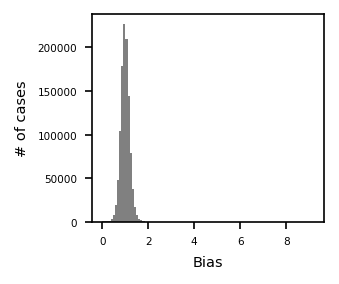

1602 case w bias > 2
10090 case w bias < 0.5
1.1% (11692/1101720) of cases have extreme bias >2 or < 0.5, among those where bias can be estimated
9.7% (117800/1219520) of cases, bias cannot be estimated


In [180]:
def test():
    utils.hist(bias[bias!=1].flatten(), "Bias", "# of cases")
    # utils.hist(bias.flatten())
    n = bias.size
    n0 = (bias[np.std(bias,axis=1)!=0]).size
    n1 = np.sum(bias > 2)
    n2 = np.sum(bias < 0.5)
    print(f"{n1} case w bias > 2")
    print(f"{n2} case w bias < 0.5")
    print(f"{(n1+n2)/n0:.1%} ({n1+n2}/{n0}) of cases have extreme bias >2 or < 0.5, among those where bias can be estimated")
    print(f"{(n-n0)/n:.1%} ({n-n0}/{n}) of cases, bias cannot be estimated")
test()

In [153]:
pd.DataFrame(bias.flatten()).describe()

0
count  1.219520e+06
mean   1.000000e+00
std    1.995972e-01
min    6.141493e-04
25%    8.925107e-01
50%    1.000000e+00
75%    1.099152e+00
max    9.192830e+00

In [177]:
# np.savetxt("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hprc/full.v1/analysis8/mapping/hprc/bias.tsv.gz", bias, fmt="%s", delimiter="\t")

In [15]:
bias = np.loadtxt("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hprc/full.v1/analysis8/mapping/hprc/bias.tsv.gz")

In [165]:
def test():
    ntr = len(ki_tr)
    ilagt_bc = np.copy(ilagt)
    for tri in range(ntr):
        si, ei = get_ki(tri)
        ilagt_bc[si:ei] /= bias[tri]
        
    return ilagt_bc
ilagt_bc = test()

In [208]:
def test():
    tmp = np.copy(ilagt_bc)
    np.savetxt("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hprc/full.v1/analysis8/mapping/hprc/ilagt_bc.tsv.gz", tmp, fmt="%s", delimiter="\t")
# test()

# batch-r2
- strict GT is almost always better

In [222]:
def test():
    ntr, ng = bias.shape
    nk = ki_tr[-1]
    R2s = np.full([2,ntr], np.nan)
    famat0 = fagt_strict[:,gsmask]
    famat1 = fagt_lenient[:,gsmask]
    ilmat = np.copy(ilagt)
    n = 0
    for tri in range(ntr):
        if tri % 1000 == 0: print(".", end="", flush=True)
        si = ki_tr[tri-1] if tri else 0
        ei = ki_tr[tri]
        X0 = np.sum(famat0[si:ei,:], axis=0)
        X1 = np.sum(famat1[si:ei,:], axis=0)
        if np.all(X0 == X1): 
            n += 1
            continue
        
        Y = np.sum(ilmat[si:ei,:], axis=0)
        Ya = Y / bias[tri]
        for i, X in enumerate([X0,X1]):
            m = np.isfinite(X)
            x = np.insert(X[m],0,0)
            ya = np.insert(Ya[m],0,0)
            if np.unique(x).size == 1 or np.all(ya==0):
                continue
            rega = sm.OLS(ya, sm.add_constant(x)).fit()
            R2s[i,tri] = rega.rsquared
    print(f"skipped {n} loci due to same GT")
    return R2s
r2s = test()

...............................skipped 26290 loci due to same GT


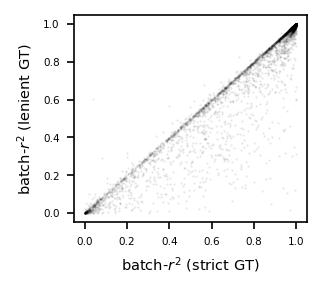

In [226]:
utils.plot(r2s[0], r2s[1], "batch-$r^2$ (strict GT)", "batch-$r^2$ (lenient GT)", alpha=0.1)

All loci n=30,488

including uncorrected loci
0.450 -> 0.744


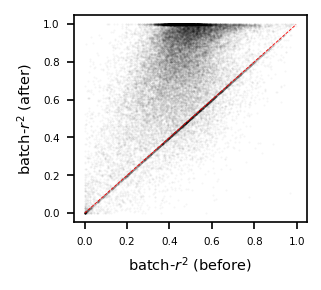


excluding uncorrected loci
0.449 -> 0.774


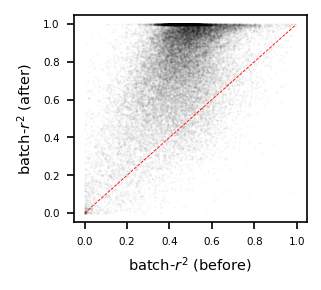

In [194]:
# dosage r2 computed using /project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hprc/full.v1/analysis8/r2/log/dosage_batch_r2.sh
def test():
    def test1():
        print(f"{np.nanmean(R2):.3f} -> {np.nanmean(R2a):.3f}")
        xl = [np.nanmin(R2), np.nanmax(R2)]
        plt.figure(dpi=150, figsize=(2,1.8))
        plt.plot(R2, R2a, '.k', mew=0, markersize=2, alpha=0.04)
        plt.plot(xl, xl, '--r', lw=0.4)
        plt.xlabel("batch-$r^2$ (before)")
        plt.ylabel("batch-$r^2$ (after)")
        plt.show(); plt.close()
                
    ntr, ng = bias.shape
    df = pd.read_csv("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hprc/full.v1/analysis8/r2/output/dosage.r2.tsv", sep="\t", na_values=".")
    R2 = df["dosage.r2.uncorrected"].to_numpy()
    R2a = df["dosage.r2.corrected"].to_numpy()
    print(f"All loci n={R2.size:,}")
    print()
    print("including uncorrected loci")
    test1()
    
    print()
    print("excluding uncorrected loci")
    m = R2 != R2a
    R2 = R2[m]
    R2a = R2a[m]
    test1()

test()

# check flank invariant kmers

In [134]:
def test():
    ntr = ki_tr.size
    gs = np.loadtxt(gsfile, dtype=object)
    kdb = np.full(ntr, None, dtype=object)
    tri2km2i = np.full(ntr, None, dtype=object)
    
    ki = 0
    fas = [open(f"{graph_dir}/trfa/{gn}.{h}.tr.fasta") for gn in gs for h in [0,1]]
    fl_annot = [] # -1: left 50bp flank. 1: right 50bp flank. 0: otherwise. -1 and 1 are only true if kmer only shows up once.
    for tri in range(ntr):
        if tri % 100 == 0: print(".", end="")
        kdb[tri] = {}
        tri2km2i[tri] = {}
        k2c = kdb[tri]
        km2i = tri2km2i[tri]
        for gi, gn in enumerate(gs):
            for h in [0,1]:
                hi = 2*gi + h
                if omap[tri,hi] == -1: continue

                f = fas[hi]
                f.readline()
                seq = f.readline()[:-1]
                lf = seq[:500+21-1]
                # lf = seq[450:500+21-1]
                rf = seq[-500-21+1:]
                # rf = seq[-500-21+1:-450]
                for seq, upstream in zip([lf, rf], [1,0]):
                    kmers = vu.read2kmers_noshift(seq, 21, leftflank=0, rightflank=0, dtype=int)
                    for i, km in enumerate(kmers):
                        if km < 0: continue
                        if km not in k2c:
                            k2c[km] = 1
                            km2i[km] = ki
                            ki += 1
                            if upstream:
                                if i >= 450:
                                    fl_annot.append(-1)
                                else:
                                    fl_annot.append(0)
                            else:
                                if i < 50:
                                    fl_annot.append(1)
                                else:
                                    fl_annot.append(0)
                        else:
                            k2c[km] += 1
    print(f"{ki} kmers in total in 500bp flanks")
    return tri2km2i, np.array(fl_annot)
fl_tri2km2i, fl_annot = test()
# 37022564 kmers in total in 500bp flanks

.................................................................................................................................................................................................................................................................................................................37022564 kmers in total in 100bp flanks


In [154]:
# pickle.dump((fl_tri2km2i,fl_annot), open("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hprc/full.v1/analysis8/mapping/hprc/fl_tri2km2i.fl_annot.pickle", 'wb'))

In [16]:
fl_tri2km2i, fl_annot = pickle.load(open("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hprc/full.v1/analysis8/mapping/hprc/fl_tri2km2i.fl_annot.pickle", 'rb'))

In [137]:
max(fl_tri2km2i[ki_tr.size-1].values()) + 1

37022564

In [17]:
def test():
    ntr = ki_tr.size
    fl_ki_tr = np.array([max(fl_tri2km2i[tri].values())+1 for tri in range(ntr)])
    fl_km_arr = np.zeros(fl_ki_tr[-1], dtype=int) - 1
    for tri in range(ntr):
        for km, ki in fl_tri2km2i[tri].items():
            fl_km_arr[ki] = km
    return fl_ki_tr, fl_km_arr
fl_ki_tr, fl_km_arr = test()

In [139]:
def test():
    ntr = ki_tr.size
    nk = max(fl_tri2km2i[ntr-1].values()) + 1
    gs = np.loadtxt(gsfile, dtype=object)
    ng = gs.size
    nh = 2*ng
    
    print("initializing matrix")
    fl_faht = np.zeros([nk, nh], dtype=np.int32)
    for gi, gn in enumerate(gs):
        for h in [0,1]:
            hi = 2*gi + h
            for tri in range(ntr):
                if omap[tri,hi] == -1:
                    si = fl_ki_tr[tri-1] if tri else 0                    
                    ei = fl_ki_tr[tri]
                    fl_faht[si:ei, hi] = -1
    
    print("reading kmers")
    for gi, gn in enumerate(gs):
        for h in [0,1]:
            hi = 2*gi + h
            print(".", end="")
            with open(f"{graph_dir}/trfa/{gn}.{h}.tr.fasta") as f:
                gtri = -1
                gtris = np.nonzero(omap[:,hi]>=0)[0]
                for line in f:
                    if line[0] == ">":
                        gtri += 1
                        ptri = gtris[gtri]
                        km2i = fl_tri2km2i[ptri]
                    else:
                        seq = line[:-1]
                        lf = seq[:500+21-1]
                        rf = seq[-500-21+1:]
                        # lf = seq[450:500+21-1]
                        # rf = seq[-500-21+1:-450]
                        for flank in [lf, rf]:
                            kmers = vu.read2kmers_noshift(flank, 21, leftflank=0, rightflank=0, dtype=int)
                            for km in kmers:
                                if km < 0: continue
                                ki = km2i[km]
                                fl_faht[ki,hi] += 1
    return fl_faht
fl_faht = test()

initializing matrix
reading kmers
................................................................................................

In [140]:
def test():
    ntr = ki_tr.size
    nk = max(fl_tri2km2i[ntr-1].values()) + 1
    gs = np.loadtxt(gsfile, dtype=object)
    ng = gs.size
    nh = 2*ng
    fl50_ikmer = np.zeros(nk, dtype=bool)
    fl_ikstats = np.full([nk,2], np.nan)
    
    for tri in range(ntr):
        si = fl_ki_tr[tri-1] if tri else 0
        ei = fl_ki_tr[tri]
        hm = omap[tri] != -1
        haps = fl_faht[si:ei][:,hm]
        inv = np.all(haps == haps[:,0:1], axis=1)
        fl50_ikmer[si:ei] = inv
        fl_ikstats[si:ei,0] = np.mean(haps, axis=1)
        fl_ikstats[si:ei,1] = np.std(haps, axis=1)
    fl50_ikmer = fl50_ikmer & (fl_annot != 0)
    return fl50_ikmer, fl_ikstats
fl50_ikmer, fl_ikstats = test()

# fl_ikstats[:,1] == 0 doesn't mean it's a ikmer; it has to be within 50bp to TR 

In [141]:
def test():
    df = pd.DataFrame()
    df["is.ikmer"] = fl50_ikmer
    df["kmc.mn"] = fl_ikstats[:,0]
    df["kmc.sd"] = fl_ikstats[:,1]
    df.to_csv("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hprc/full.v1/analysis8/mapping/hprc/fl50ikmer.annot.tsv.gz", sep="\t")
# test()

In [18]:
def test():
    df = pd.read_csv("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hprc/full.v1/analysis8/mapping/hprc/fl50ikmer.annot.tsv.gz", sep="\t", index_col=0)
    return df.iloc[:,0].to_numpy(), df.iloc[:,1:].to_numpy()
fl50_ikmer, fl_ikstats = test()

In [142]:
pd.DataFrame(fl50_ikmer[:,None].T)

0         1         2         3         4         5         6         \
0     False     False     False     False     False     False     False   

   7         8         9         ...  37022554  37022555  37022556  37022557  \
0     False     False     False  ...     False     False     False     False   

   37022558  37022559  37022560  37022561  37022562  37022563  
0     False     False     False     False     False     False  

[1 rows x 37022564 columns]

In [143]:
pd.DataFrame(fl_ikstats.T)

0         1         2         3         4         5         6         \
0  0.948718  0.948718  0.948718  0.948718  0.884615  0.884615  0.884615   
1  0.220572  0.220572  0.220572  0.220572  0.319486  0.319486  0.319486   

   7         8         9         ...  37022554  37022555  37022556  37022557  \
0  0.884615  0.884615  0.884615  ...  0.015873  0.015873  0.015873  0.015873   
1  0.319486  0.319486  0.319486  ...  0.124984  0.124984  0.124984  0.124984   

   37022558  37022559  37022560  37022561  37022562  37022563  
0  0.015873  0.015873  0.015873  0.015873  0.015873  0.015873  
1  0.124984  0.124984  0.124984  0.124984  0.124984  0.124984  

[2 rows x 37022564 columns]

In [144]:
def test():
    ntr = ki_tr.size
    n0, n1 = 0, 0
    nik = []
    for tri in range(ntr):
        si = ki_tr[tri-1] if tri else 0
        ei = ki_tr[tri]
        si_fl = fl_ki_tr[tri-1] if tri else 0
        ei_fl = fl_ki_tr[tri]
        if not np.any(ikmer[si:ei]):
            n0 += 1
            if np.any(fl50_ikmer[si_fl:ei_fl]):
                n1 += 1
            else:
                print(tri, end=",")
        nik.append(np.sum(fl50_ikmer[si_fl:ei_fl]))
    n2 = np.mean(nik)
    n3 = np.mean(fl50_ikmer)
    print()
    print(f"{n1}/{n0} ({(n1)/n0:.1%}) loci w/o TR ikmer have flank ikmers")
    print(f"ave # of flank ikmers = {n2:.1f}")
    print(f"{n3:.1%} flank kmers are invariant")
    print(f"{n0-n1} ({(n0-n1)/ntr:.2%}) loci do not have ikmers")
test()

458,525,526,528,563,710,722,1275,1859,2366,2557,2701,2776,3428,3765,3848,4094,4105,4113,4177,4198,4200,4341,4373,4634,4664,4729,4990,5129,5133,5294,5340,5467,5886,6302,6315,6552,6712,7017,7301,7332,7343,7455,7534,7563,7769,7777,7872,7880,8012,8141,8164,8167,8191,8213,8235,8275,8289,8318,8386,8387,8397,8427,8450,8578,8636,8640,8718,8721,8722,8808,9115,9275,9321,9414,9415,9610,9668,9771,9780,9983,10065,10300,10361,10404,10463,10779,10877,10949,11724,11762,11765,11769,11997,12122,12756,13081,13182,13384,13575,13926,13949,14096,14994,15201,15246,15253,15278,15284,15932,16235,16340,16427,17021,17039,17221,17232,17263,17330,17517,17872,17909,17946,18009,18018,18132,18233,18349,18647,18858,19101,19487,19611,19867,19893,19898,19939,20004,20039,20040,20045,20431,20721,20837,20860,20969,21201,21487,21746,21996,22626,22665,23150,23159,23170,23376,23438,23461,23466,23619,24717,24723,24767,25138,25140,25177,25246,25413,25511,25537,25544,25550,25884,25959,26174,26257,26377,26409,27023,27162,27169,27

In [187]:
# link this file to /project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hprc/full.v1/output8/pan.inv.kmers to enable danbing output of ikmer counts
def test():
    ntr = ki_tr.size
    
    f = open("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hprc/full.v1/analysis8/mapping/hprc/tr_ntr50.ikmers", 'w')
    for tri in range(ntr):
        f.write(f">{tri}\n")
        si = ki_tr[tri-1] if tri else 0
        ei = ki_tr[tri]
        kms = km_arr[si:ei]
        mask = ikmer[si:ei]
        for km in kms[mask]:
            f.write(f"{km}\tTR\n")
            
        si = fl_ki_tr[tri-1] if tri else 0
        ei = fl_ki_tr[tri]
        kms = fl_km_arr[si:ei]
        mask = fl50_ikmer[si:ei]
        for km in kms[mask]:
            f.write(f"{km}\t.\n")
# test()

In [ ]:
# 50bp flank is a rough idea. location is haplotype-dependent
# flank ikmer can have count > 1 too

In [19]:
# get ikmer pos. compute 
class ikmer_data:
    def __init__(self):
        self.n = [] # name
        self.i = [] # TR index
        self.t = [] # type: TR=0, flank=1
        self.c = [] # copy num
        self.w = [] # weight ~ (sum of distance to neighboring (+1 or -1) ikmers) / (copy num)
        
def test():
    ntr = ki_tr.size
    tri2ik2i = np.full(ntr, None, dtype=object)
    si1, ei1 = 0, 0
    ikm = ikmer_data()
    for tri in range(ntr):
        trlens = [len(v) if v else np.nan for v in trseqs[tri]] # this includes flanks
        hi = np.nanargmin(trlens)
        kmers = vu.read2kmers_noshift(trseqs[tri,hi], 21, dtype=int)
        
        ikmers_tr = np.array([], dtype=int)
        si = ki_tr[tri-1] if tri else 0
        ei = ki_tr[tri]
        if si != ei:
            isik = ikmer[si:ei]
            if np.sum(isik):
                ikmers_tr = km_arr[si:ei][isik]
        
        ikmers_fl = np.array([], dtype=int)
        si = fl_ki_tr[tri-1] if tri else 0
        ei = fl_ki_tr[tri]
        if si != ei:
            isfik = fl50_ikmer[si:ei]
            if np.sum(isfik):
                ikmers_fl = fl_km_arr[si:ei][isfik]
        
        s_ikmers_tr = set(ikmers_tr.tolist())
        s_ikmers_fl = set(ikmers_fl.tolist())
        ik2i = {}
        ki_, ki = None, None
        kmc_, kmc = None, None
        ikmsi = len(ikm.n)
        for ki, km in enumerate(kmers):
            tr = km in s_ikmers_tr
            fl = km in s_ikmers_fl
            if tr or fl:
                if km not in ik2i:
                    ik2i[km] = [ki]
                else:
                    ik2i[km].append(ki)
                    
                kmc = ikstats[tri2km2i[tri][km], 0] if tr else fl_ikstats[fl_tri2km2i[tri][km], 0]
                d = ki - ki_ if ki_ is not None else 1
                ikm.n.append(km)
                ikm.i.append(tri)
                ikm.t.append(int(fl))
                ikm.c.append(kmc)
                if ki_ is not None:
                    ikm.w[-1] += (d/kmc_)
                ikm.w.append(d/kmc)
                ki_ = ki
                kmc_ = kmc
        else:
            if kmc_ is not None:
                ikm.w[-1] += (1/kmc_)
                ikmei = len(ikm.n)
                W = np.sum(ikm.w[ikmsi:ikmei])
                for i in range(ikmsi, ikmei):
                    ikm.w[i] /= W
        
        tri2ik2i[tri] = ik2i
    return tri2ik2i, ikm
tri2ik2i, ikdb = test()

0


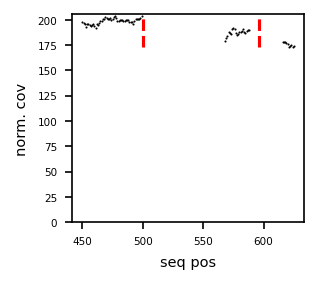

1


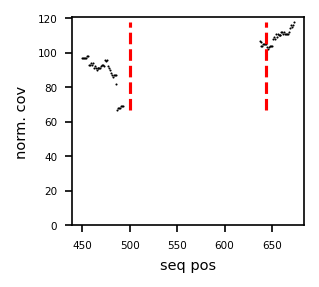

2


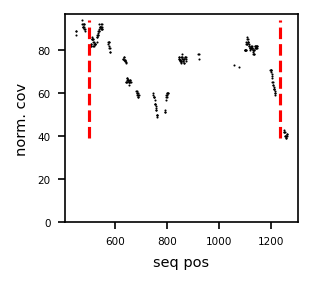

3


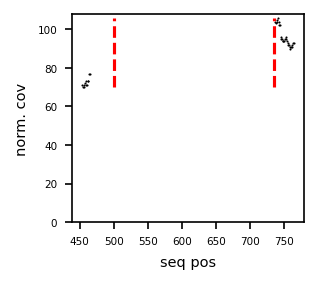

4 flank missing pos info for 317366897226
4 flank missing pos info for 1269467588906
4


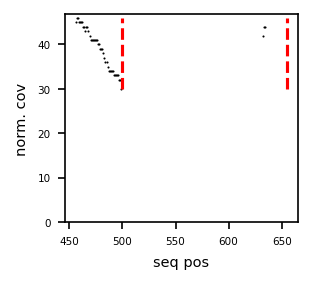

5


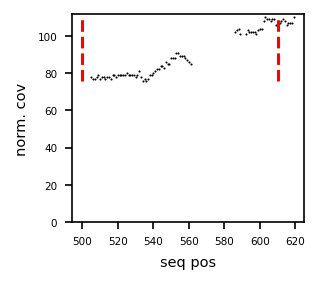

6


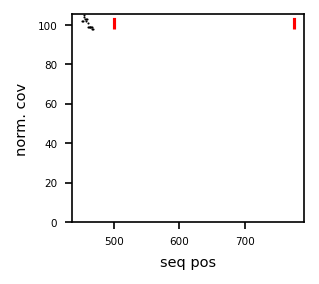

7


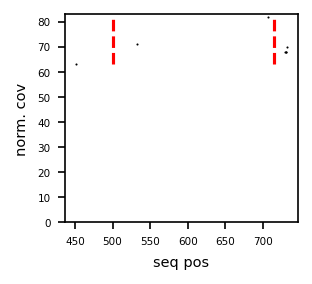

8


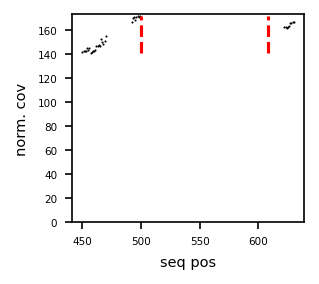

9


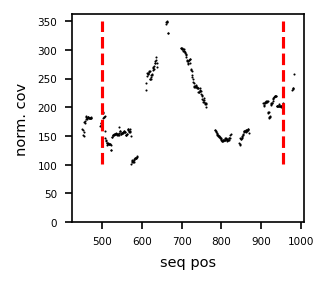

10


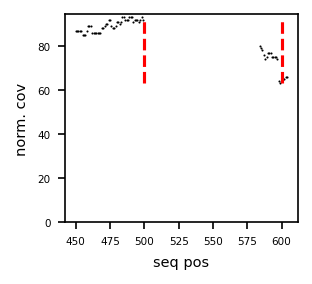

11


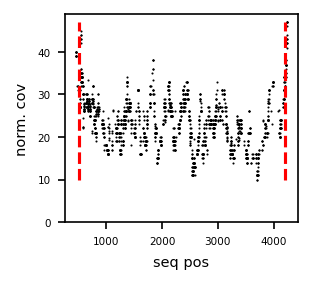

12


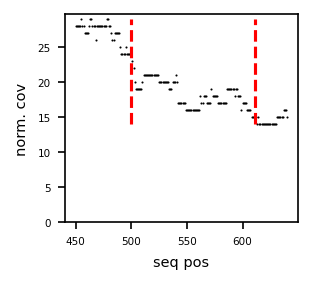

13


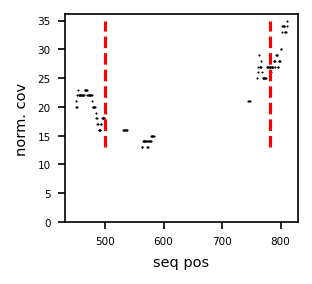

14


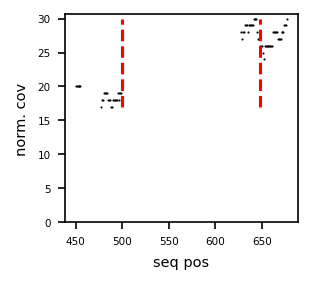

15


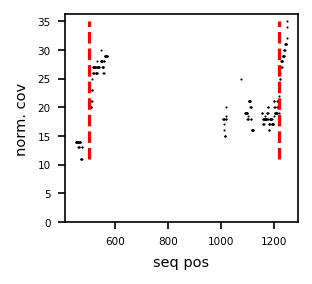

16


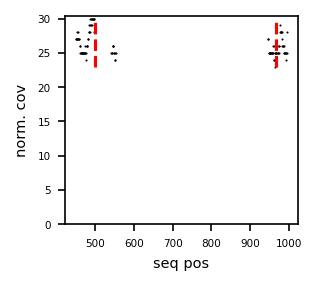

17


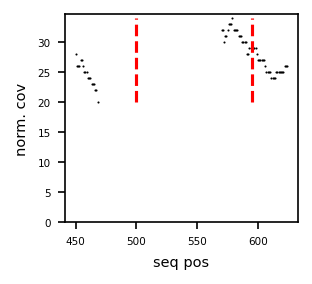

18


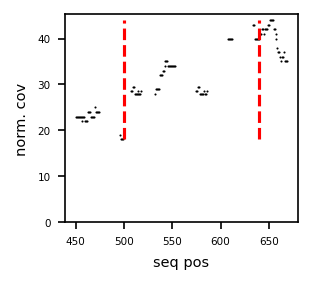

19


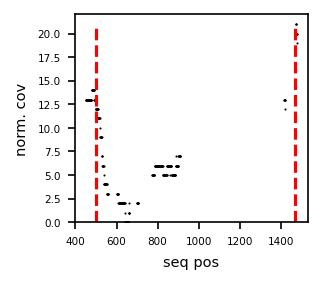

20


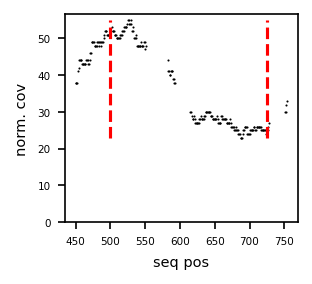

21


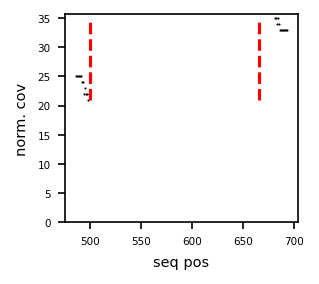

22


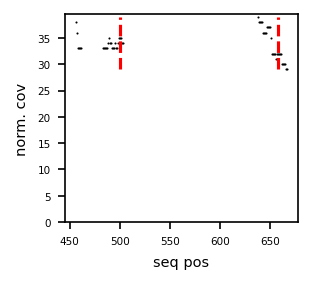

23


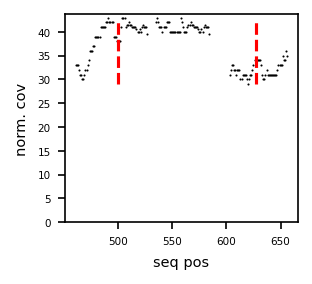

24


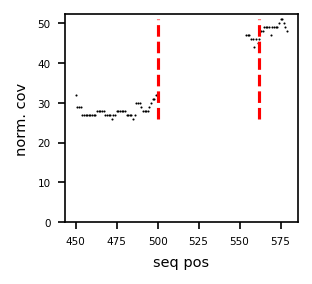

25


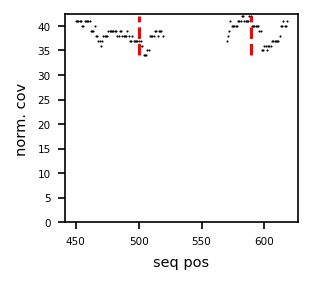

26


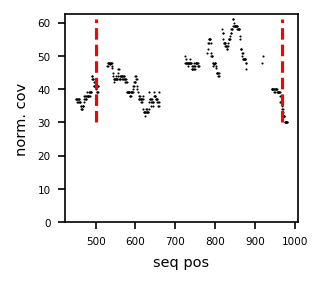

27


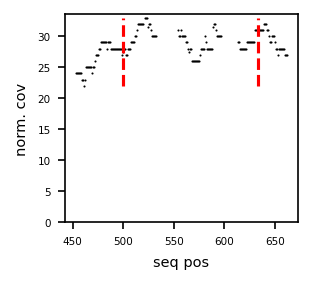

28


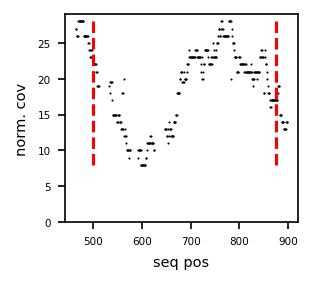

29


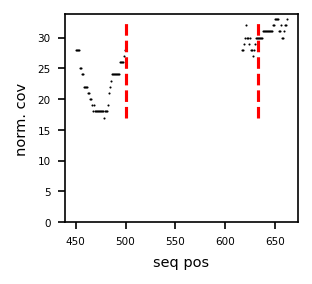

30


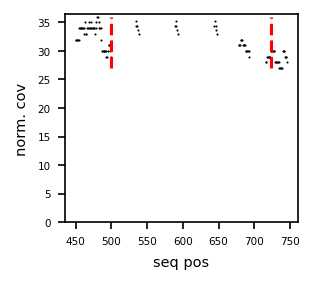

31


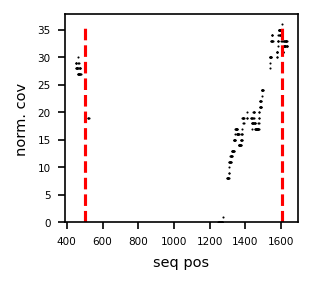

32


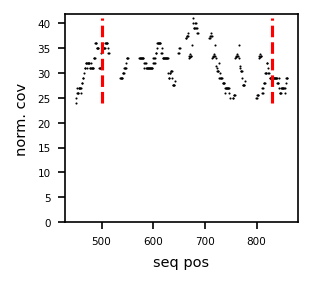

33


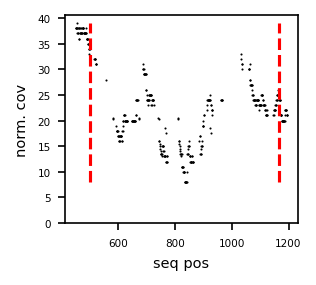

34


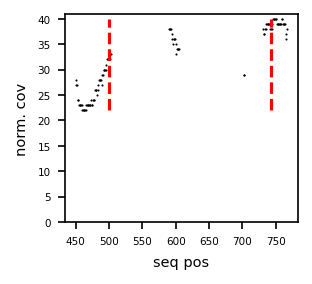

35


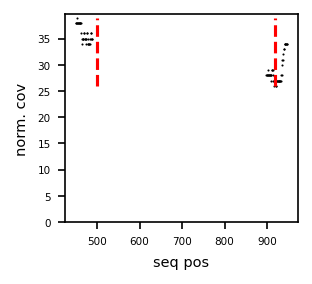

36


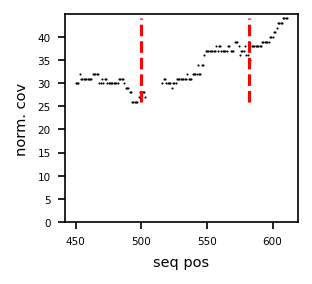

37


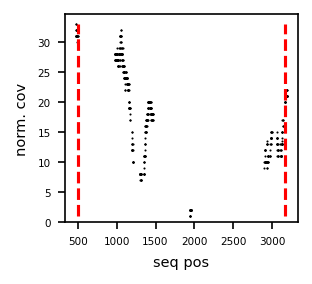

38


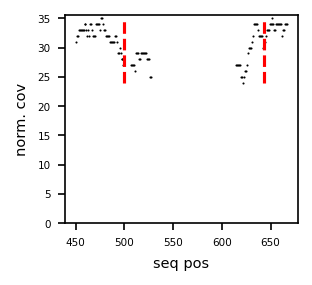

39


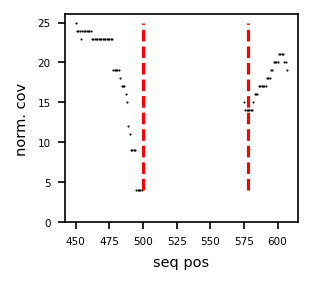

40


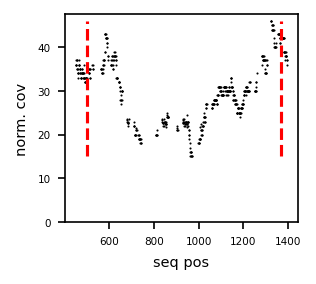

41


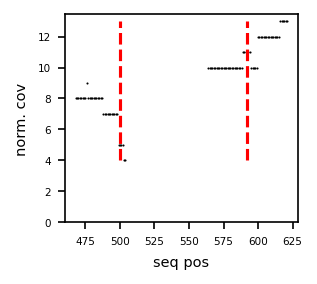

42


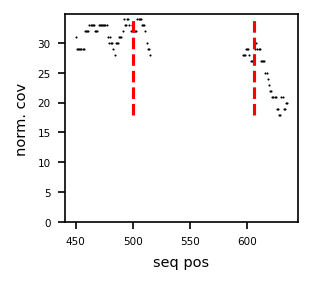

43


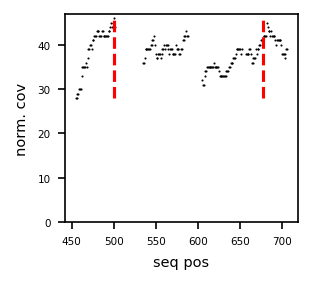

44


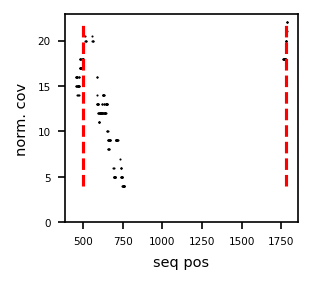

45


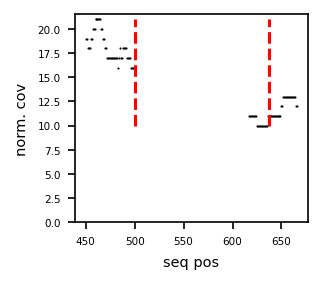

46


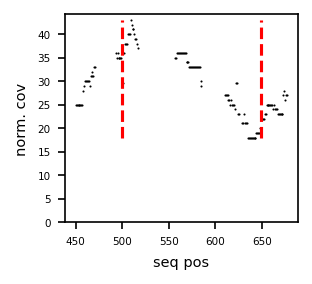

47


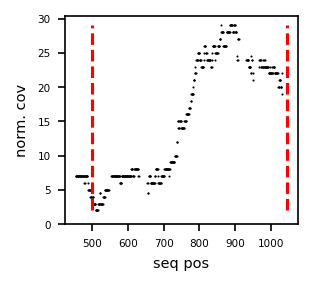

48


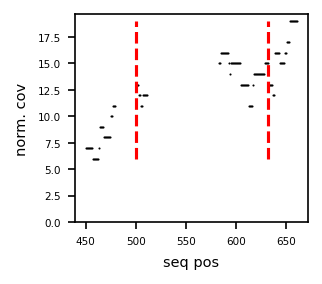

49


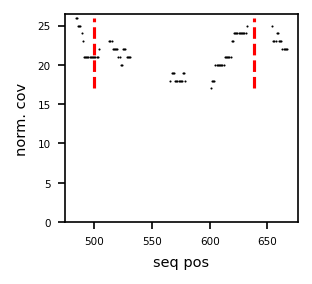

50


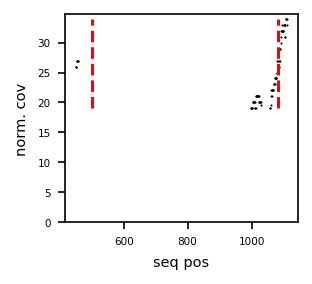

51


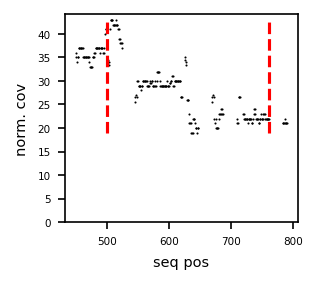

52


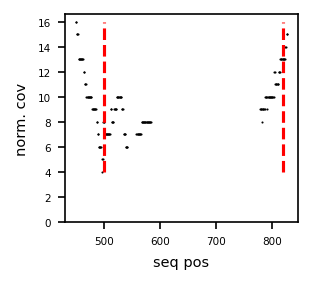

53


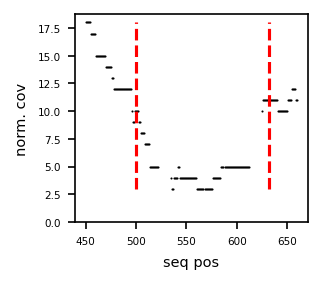

54


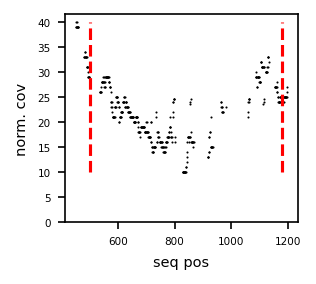

55


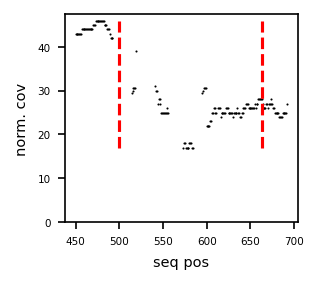

56


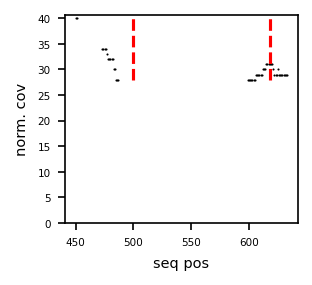

57


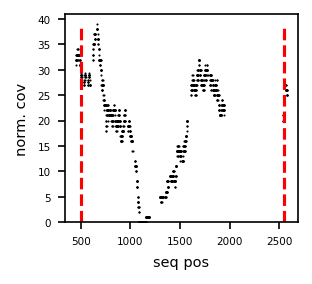

58


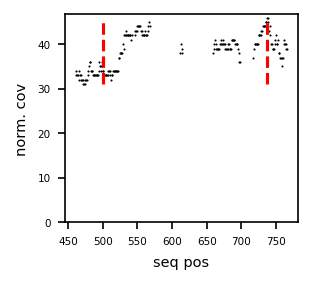

59


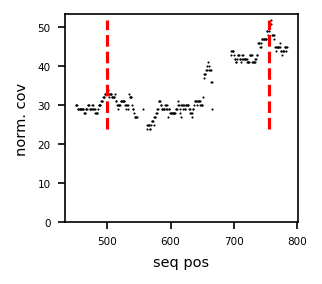

60


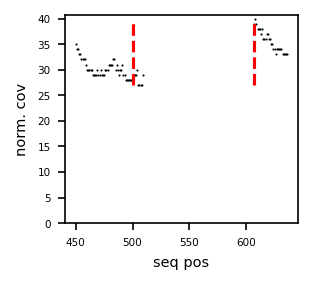

61


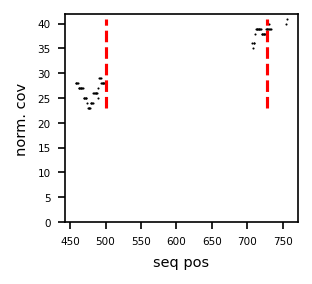

62


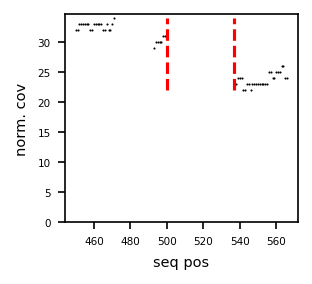

63


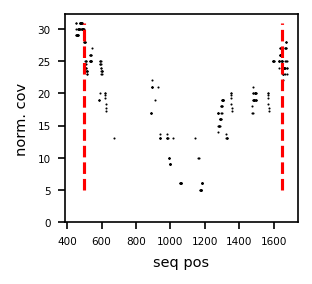

64


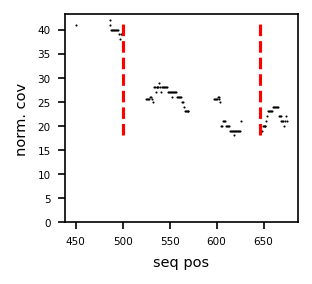

65


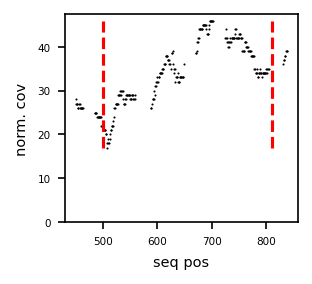

66


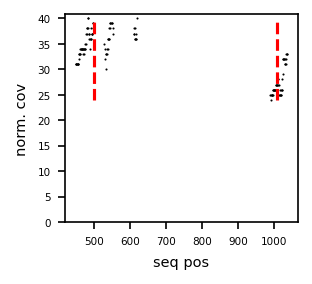

67


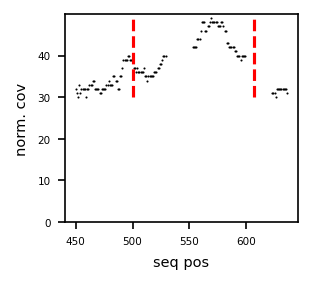

68


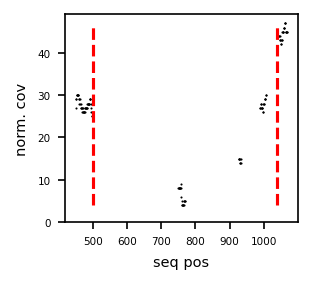

69


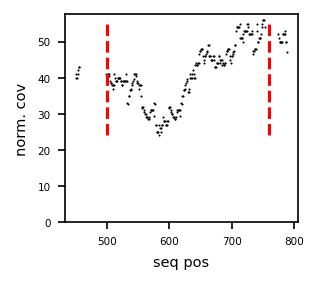

70


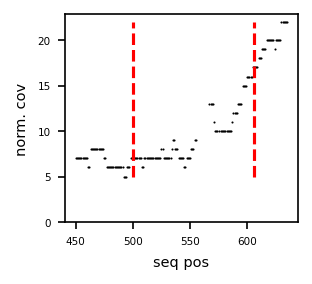

71


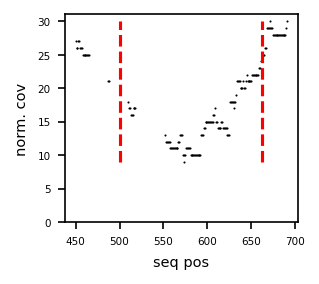

72


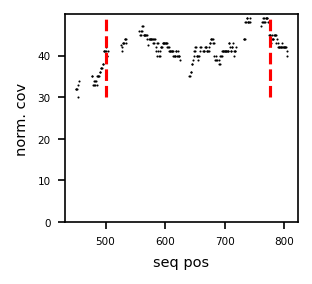

73


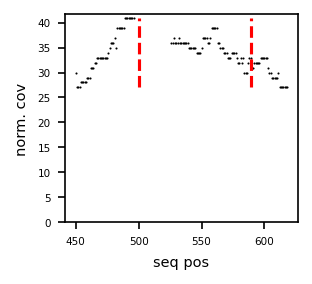

74


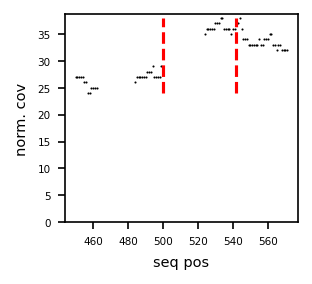

75


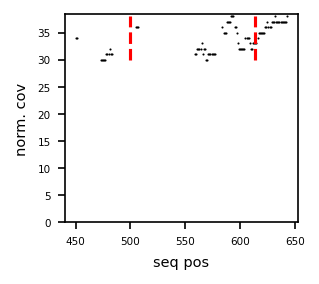

76


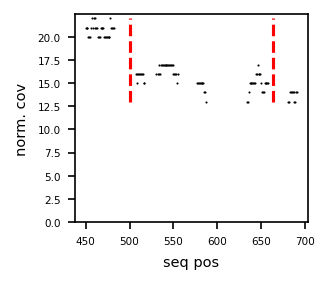

77


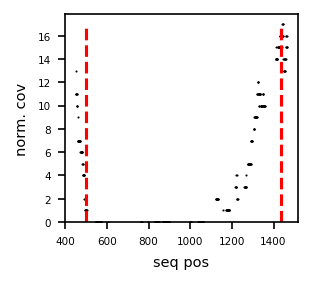

78


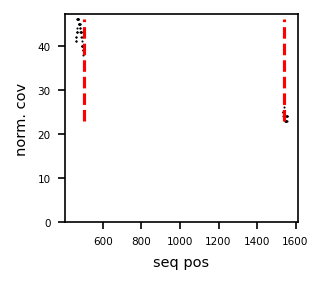

79


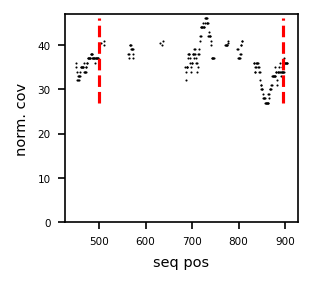

80


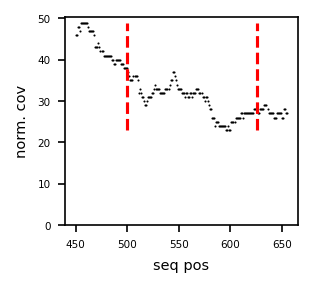

81


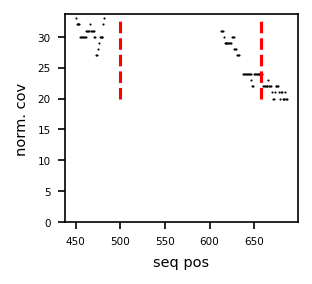

82


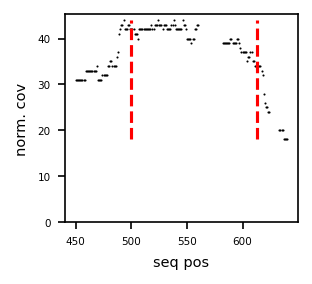

83


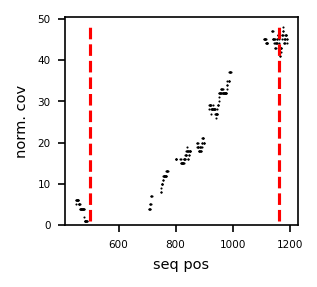

84


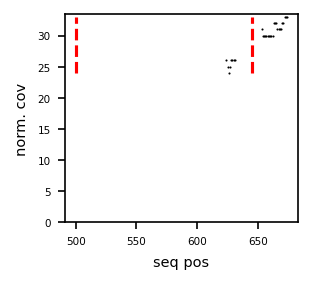

85


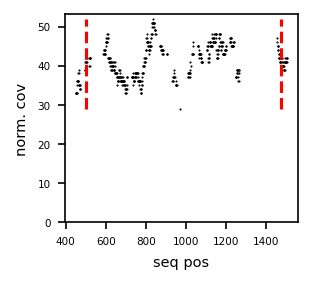

86


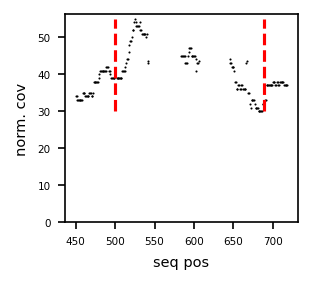

87


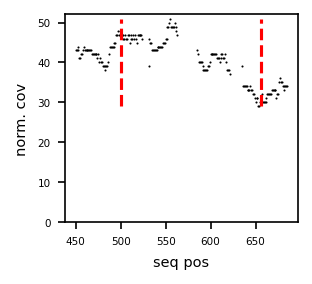

88


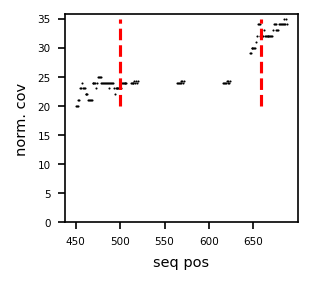

89


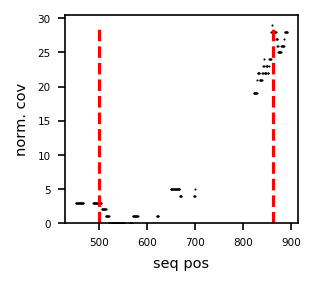

90


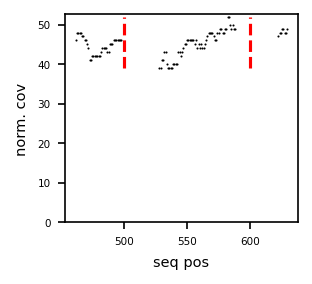

91


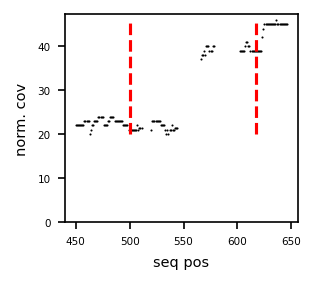

92


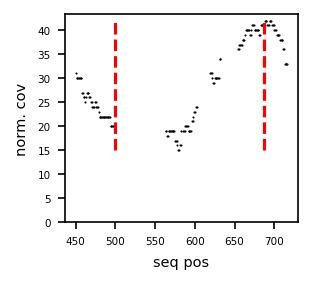

93


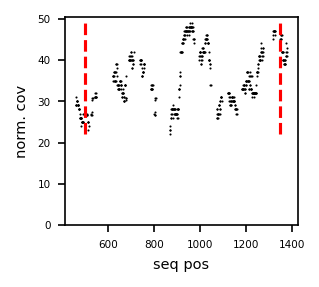

94


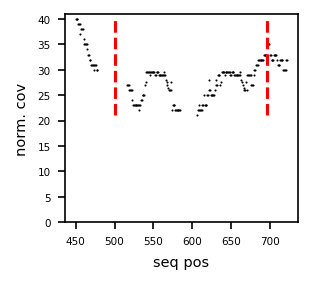

95


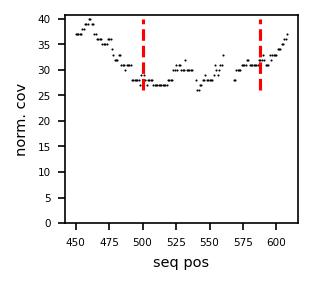

96


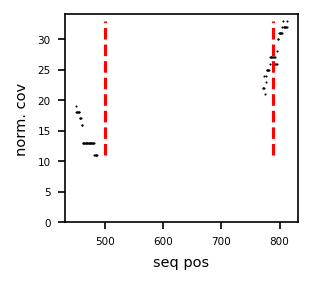

97


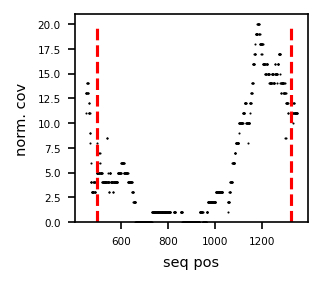

98


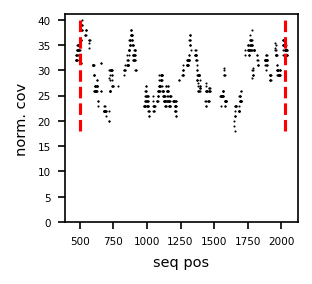

99


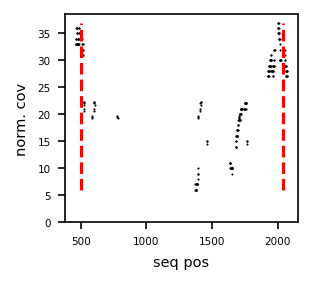

100


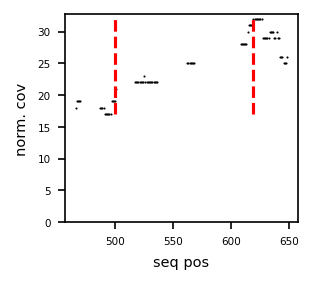

101


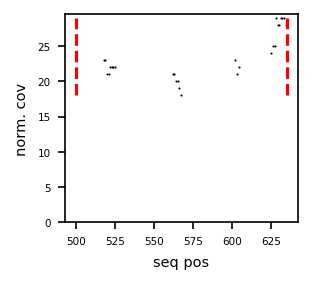

102


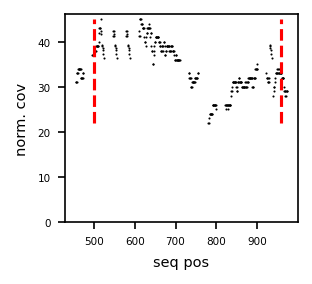

103


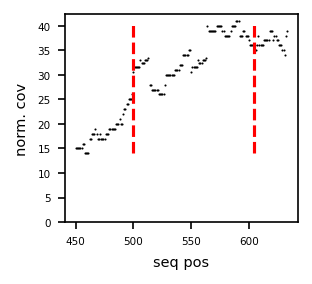

104


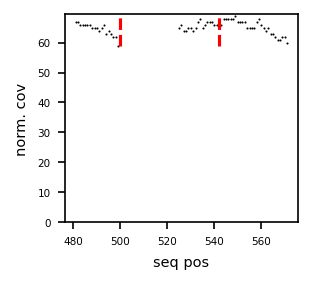

105


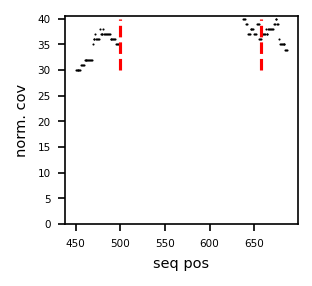

106


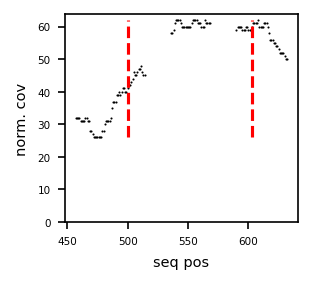

107


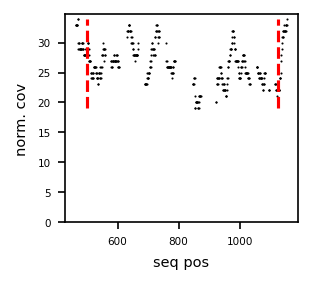

108


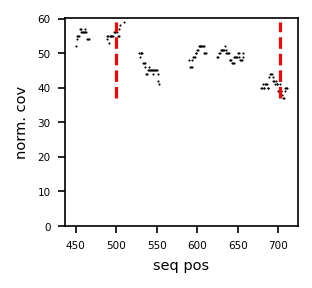

109


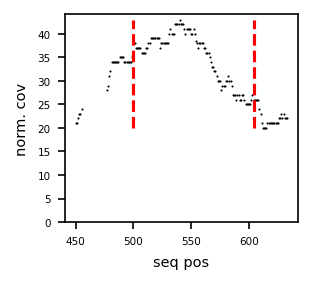

110


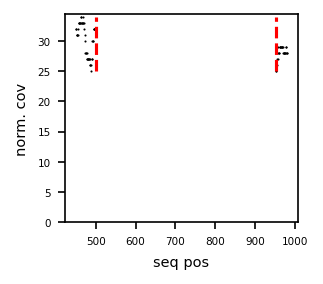

111


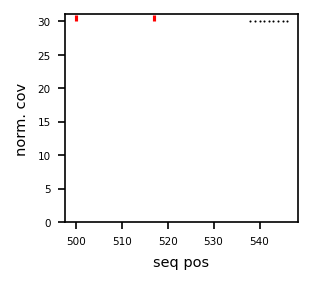

112


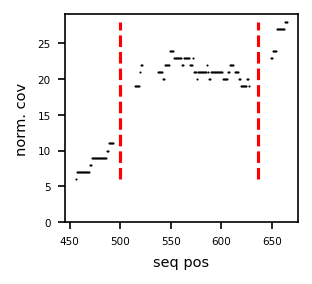

113


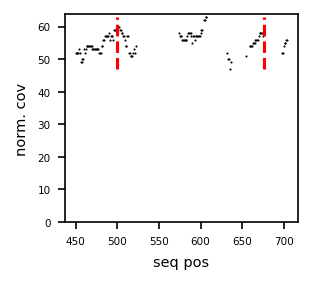

114


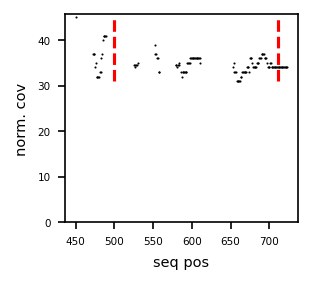

115


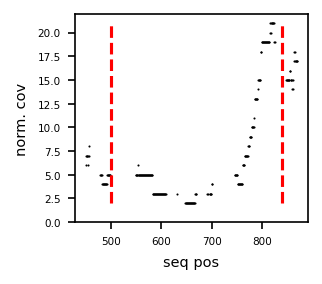

116


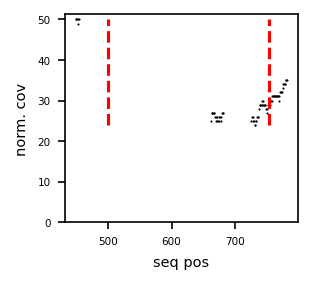

117


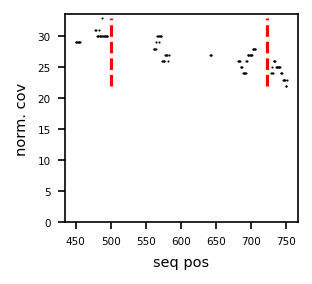

118


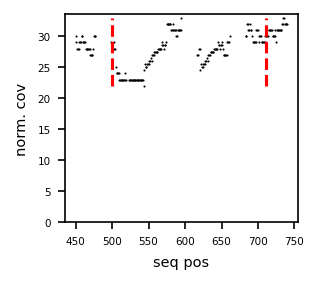

119


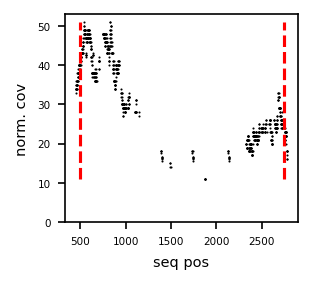

120


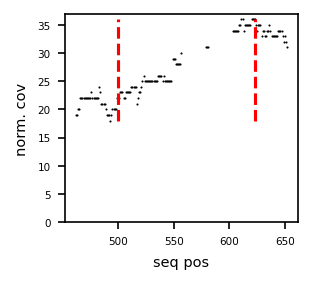

121


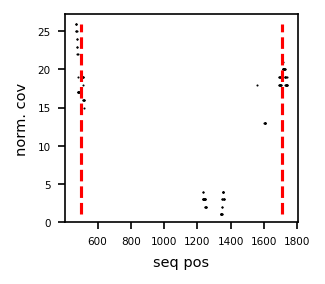

122


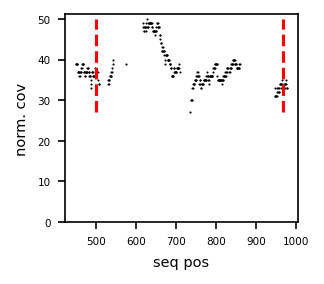

123


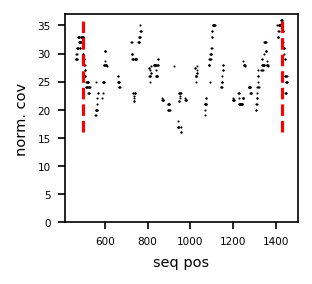

124


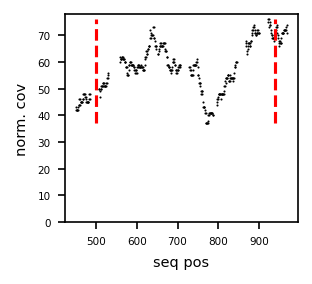

125


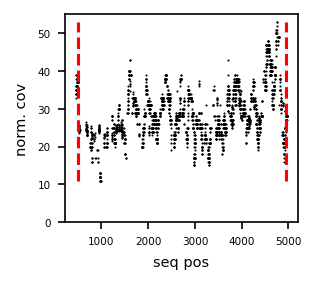

126


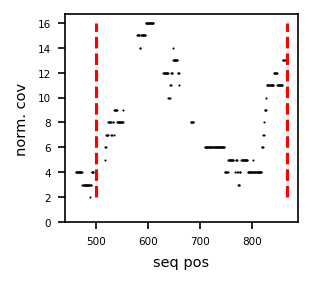

127


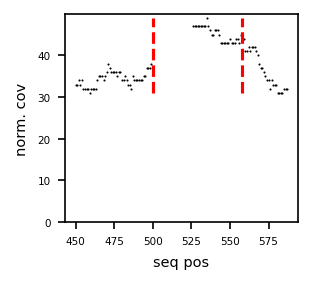

128


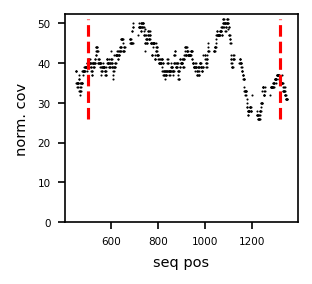

129


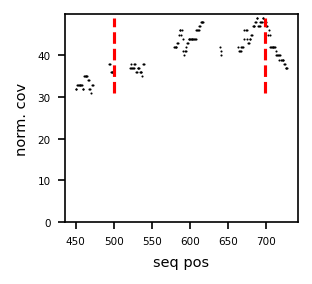

130


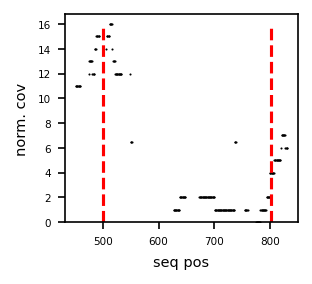

131


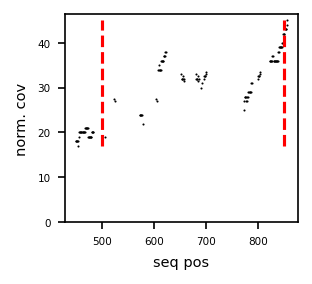

132


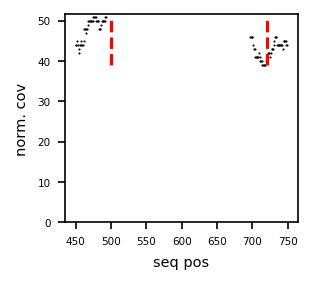

133


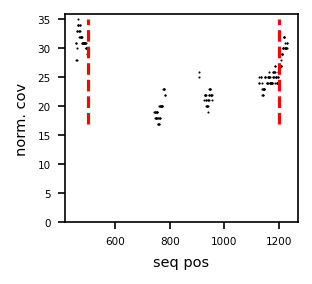

134


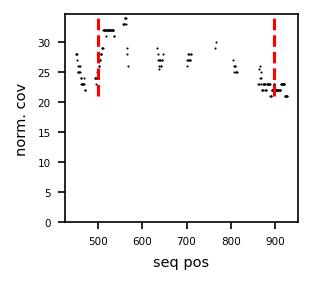

135


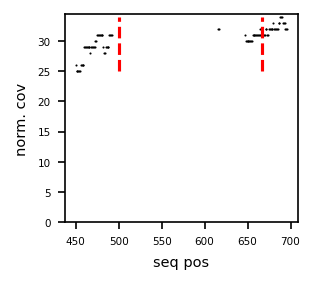

136


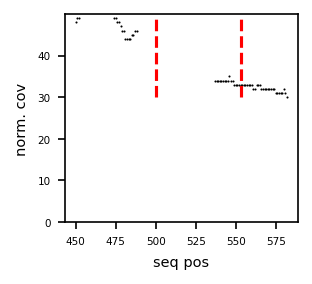

137


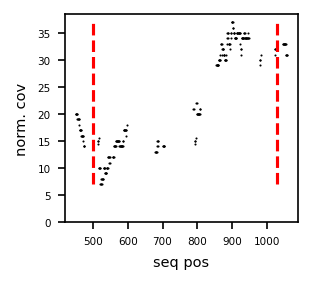

138


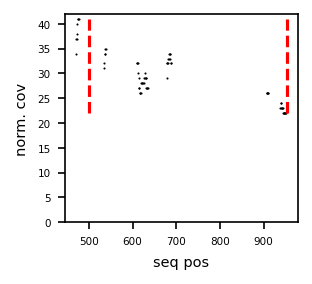

139


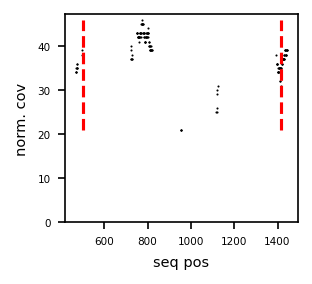

140


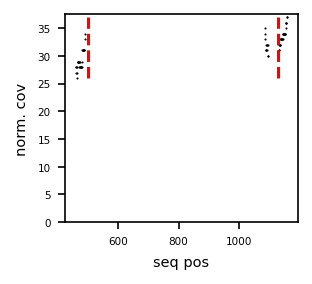

141


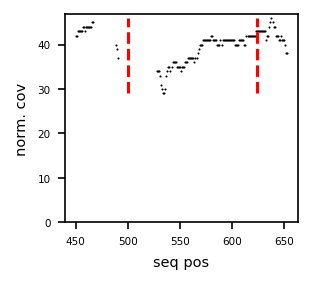

142


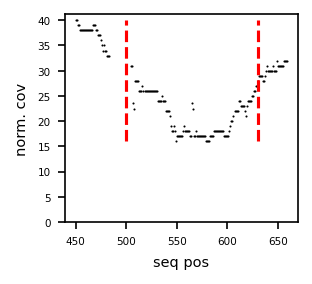

143


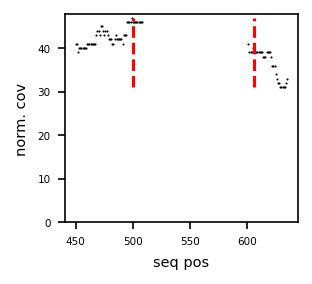

144


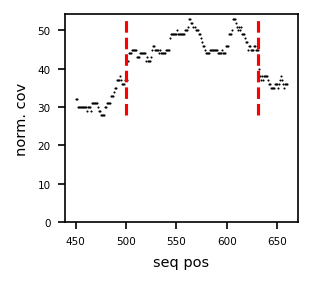

145


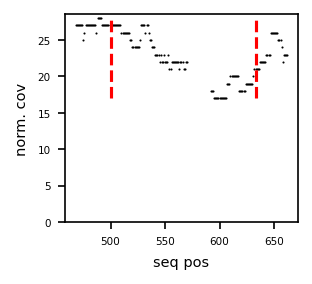

146


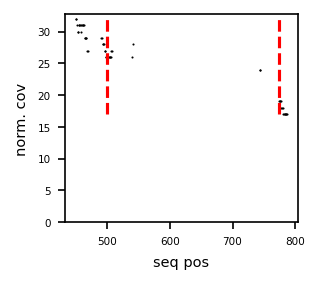

147


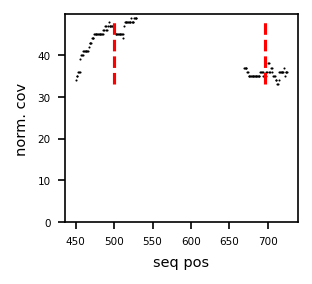

148


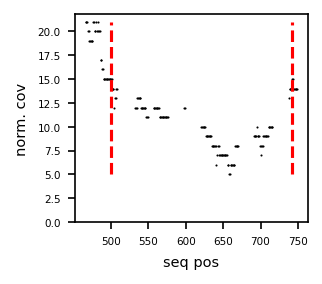

149


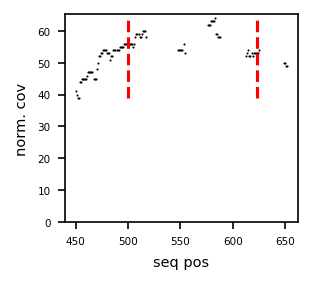

150


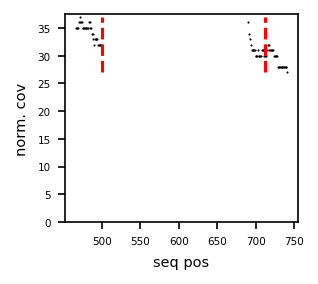

151


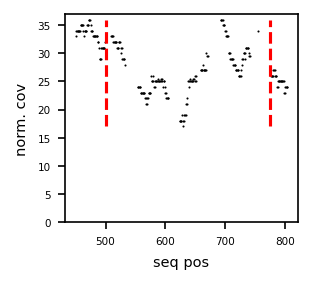

152


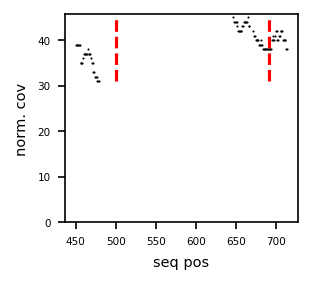

153


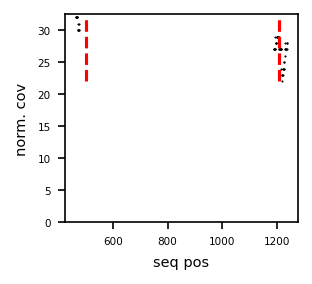

154


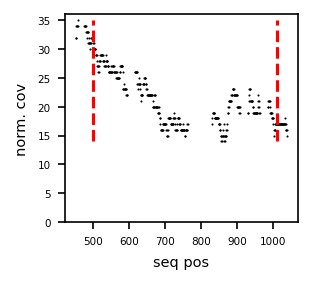

155


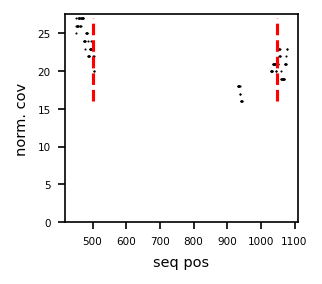

156


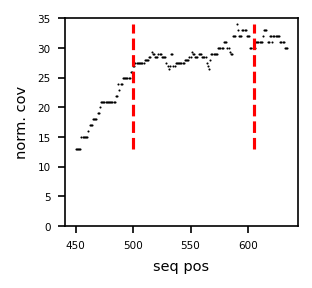

157


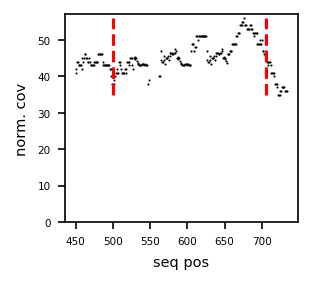

158


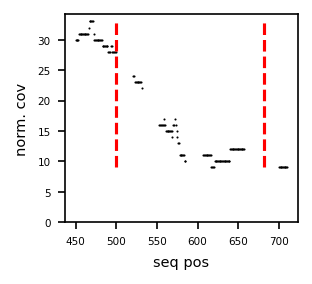

159


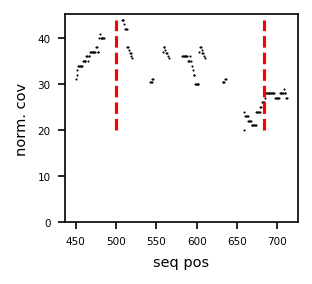

160


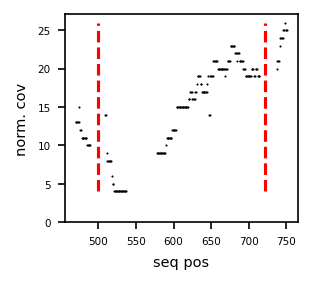

161


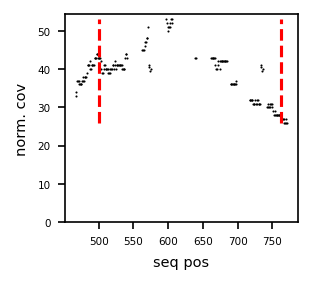

162


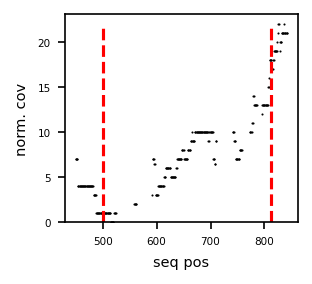

163


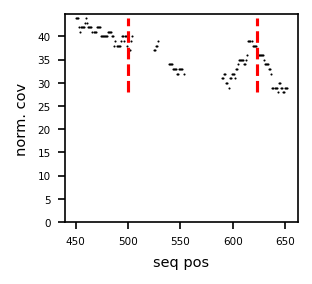

164


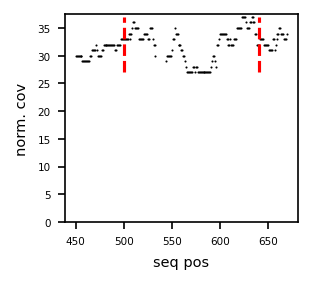

165


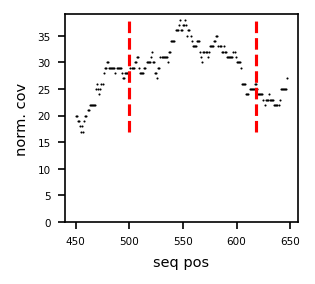

166


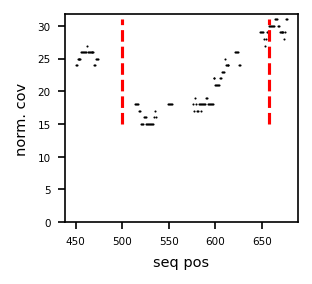

167


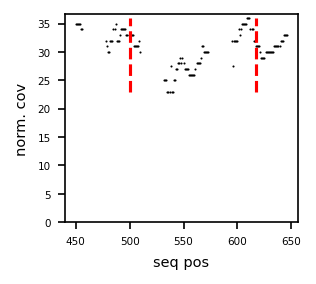

168


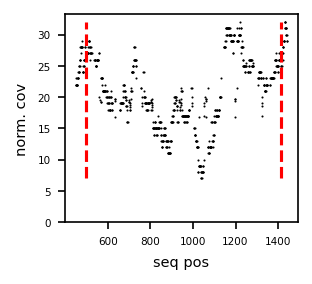

169


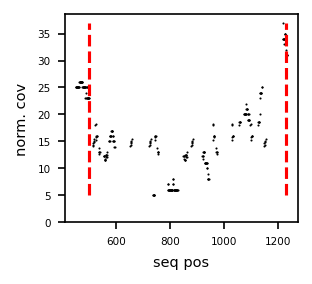

170


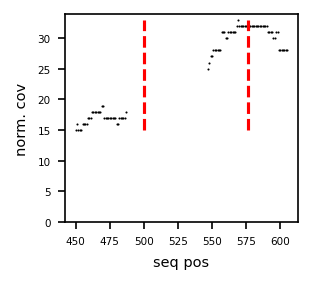

171


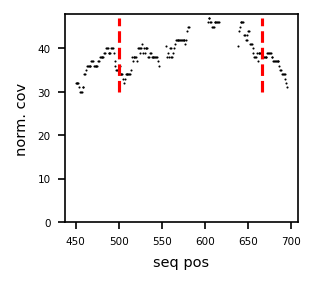

172


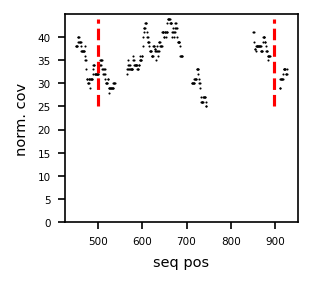

173


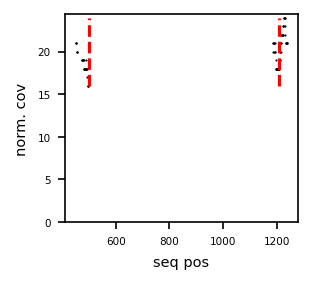

174


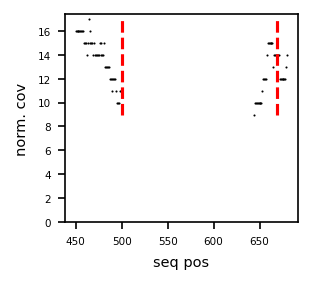

175


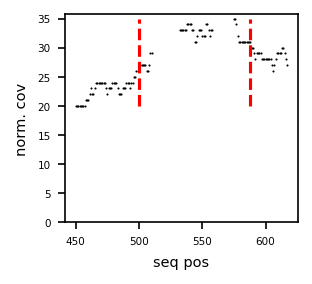

176


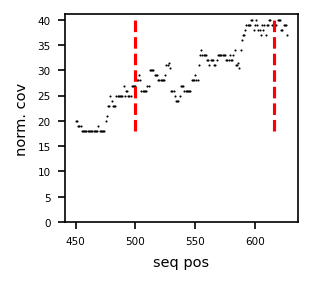

177


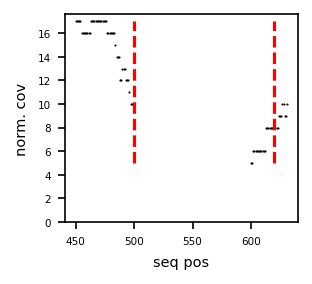

178


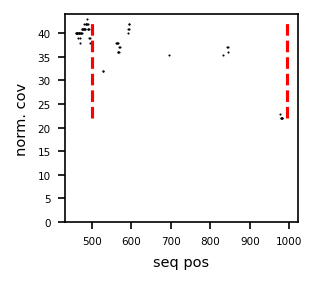

179


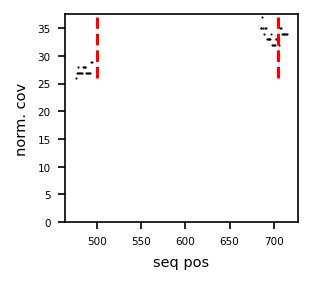

180


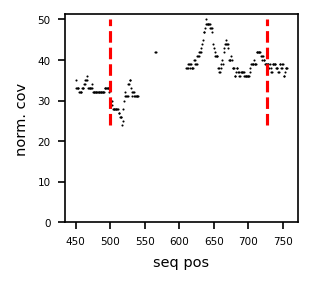

181


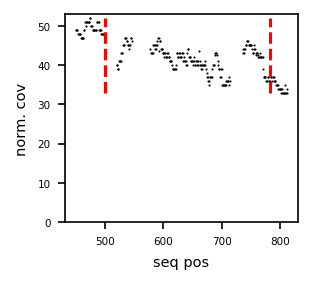

182


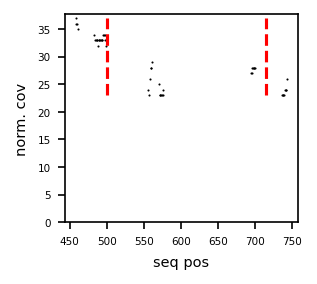

183


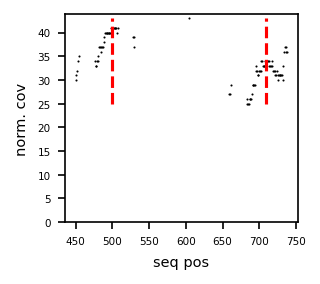

184


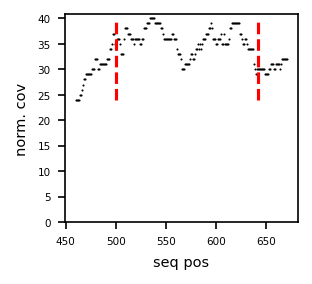

185


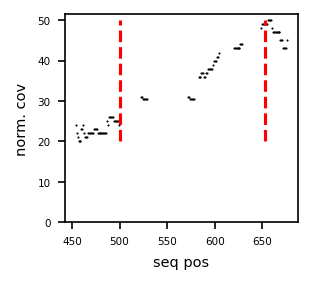

186


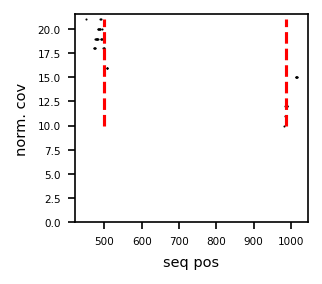

187


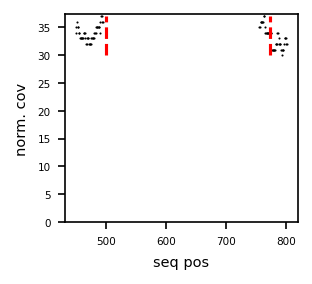

188


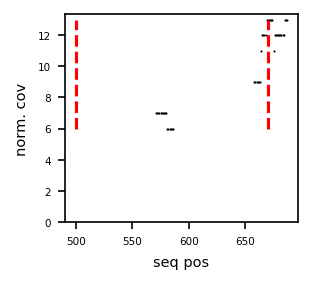

189


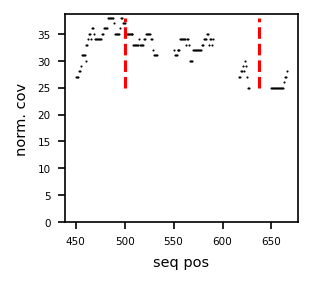

190


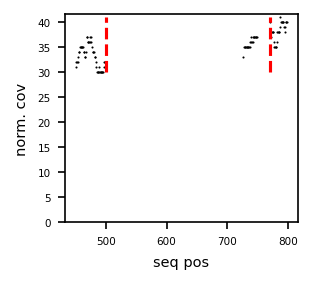

191


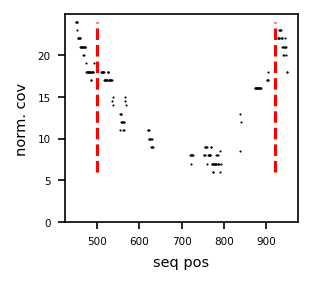

192


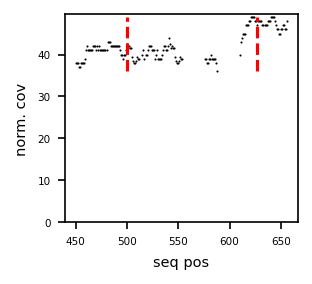

193


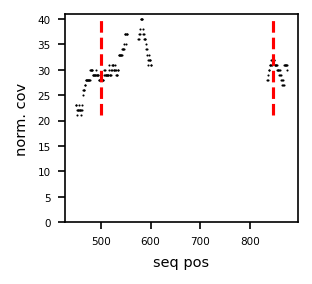

194


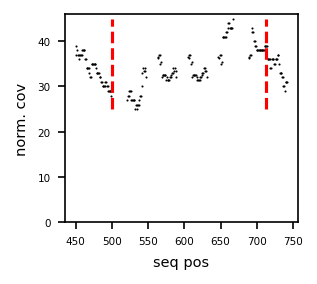

195


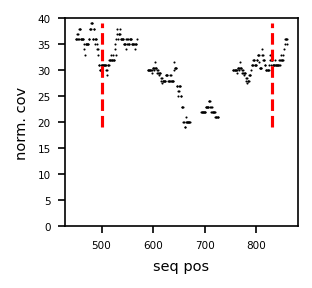

196


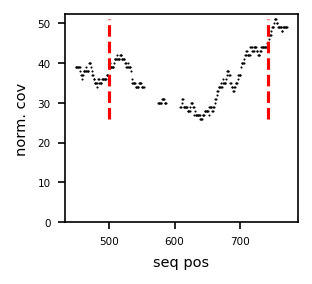

197


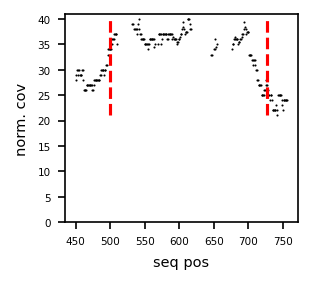

198


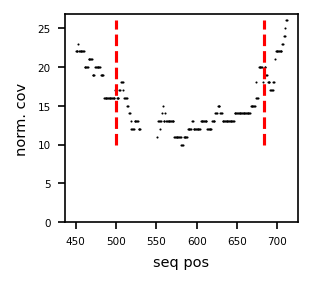

199


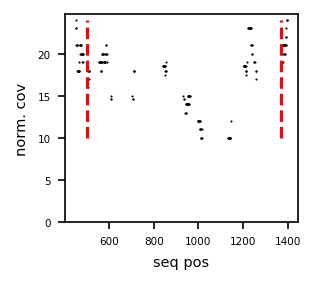

200


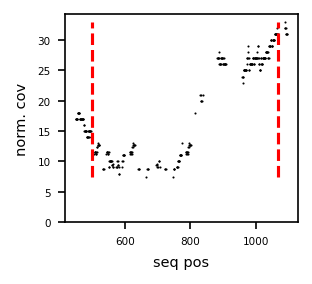

201


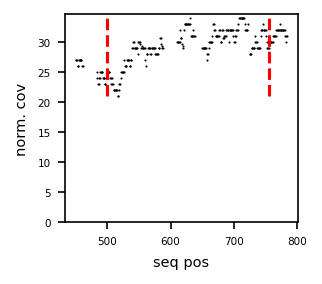

202


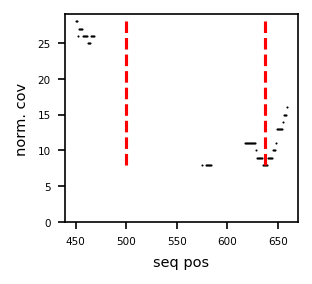

203


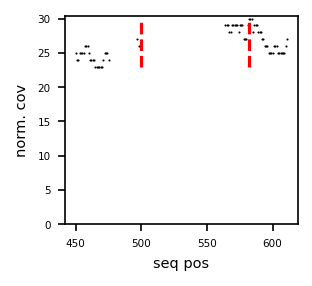

204


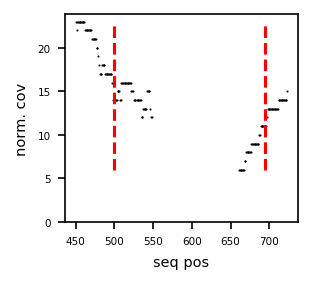

205


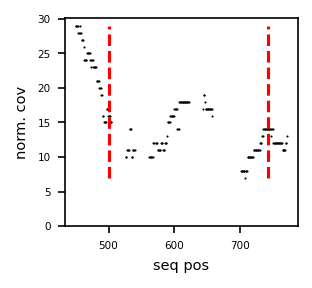

206


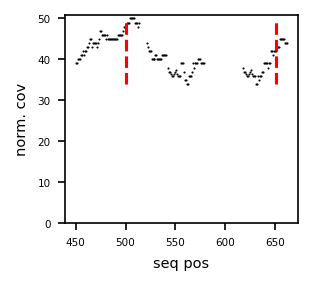

207


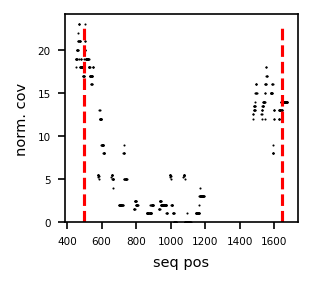

208


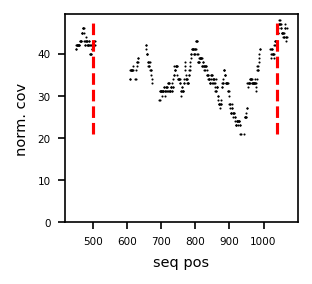

209


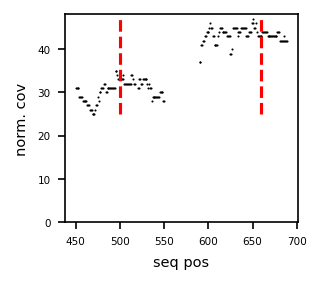

210


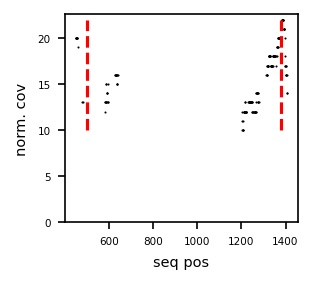

211


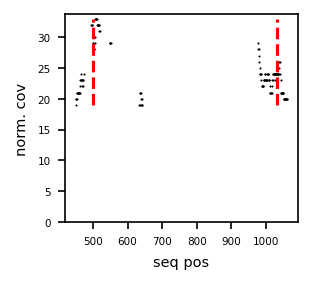

212


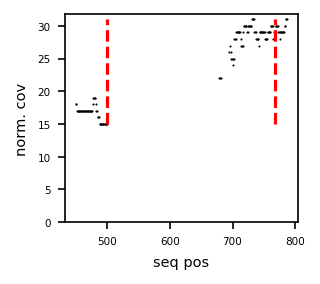

213


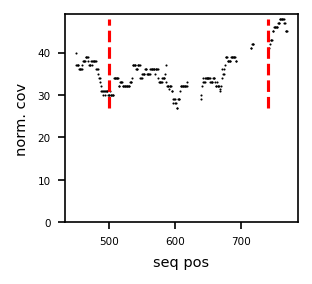

214


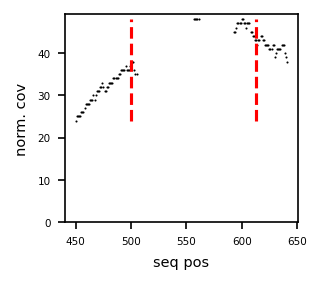

215


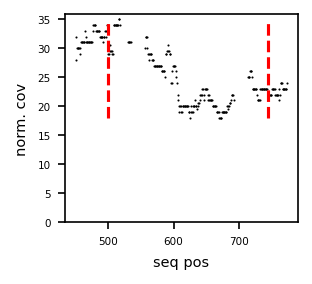

216


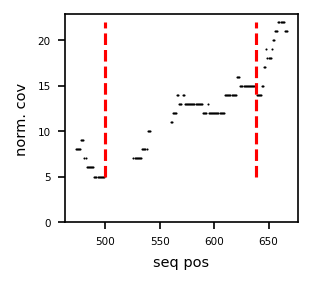

217


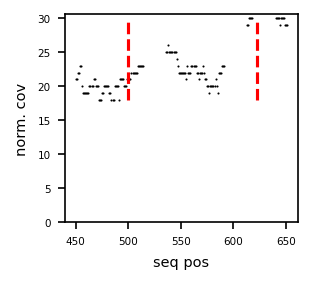

218


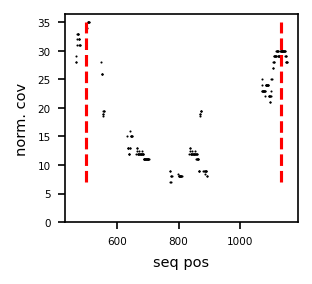

219


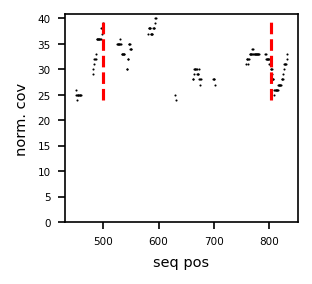

220


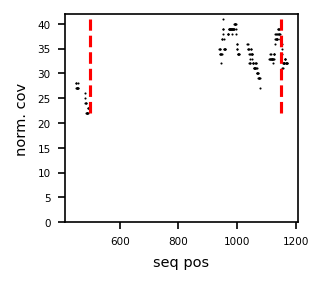

221


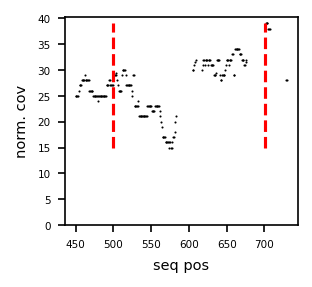

222


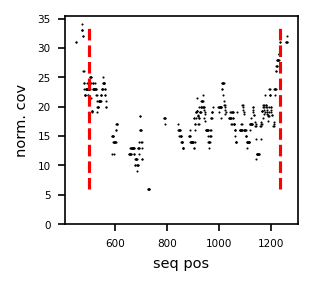

223


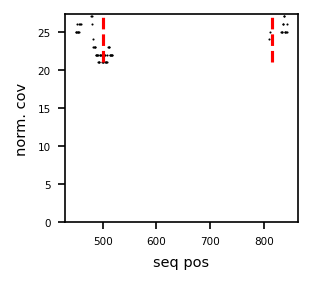

224


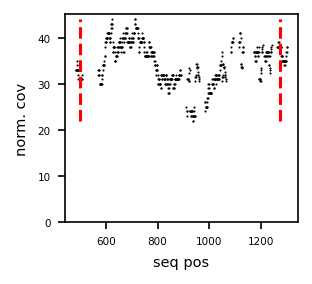

225


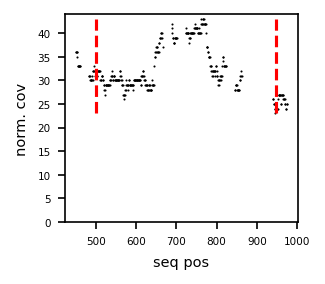

226


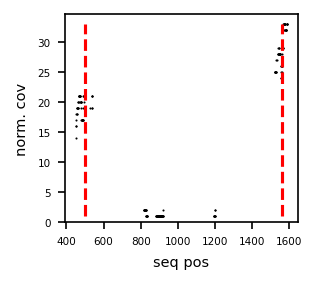

227


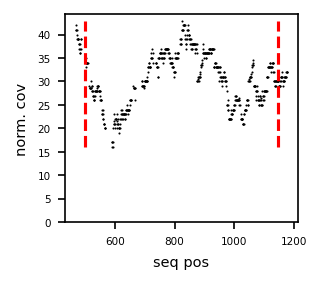

228


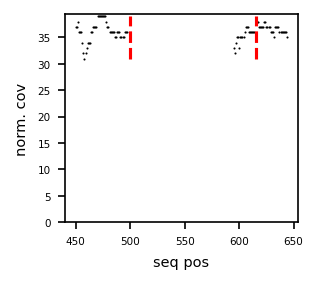

229


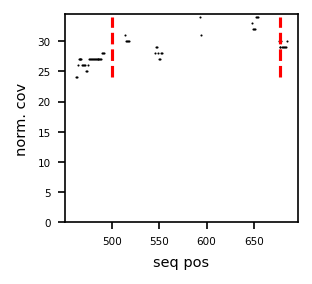

230


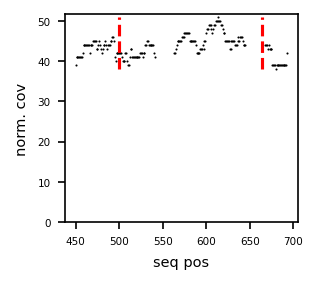

231


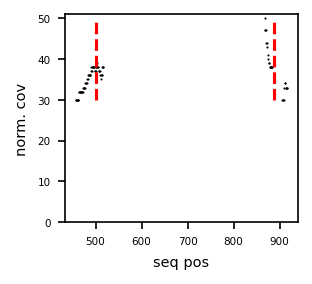

232


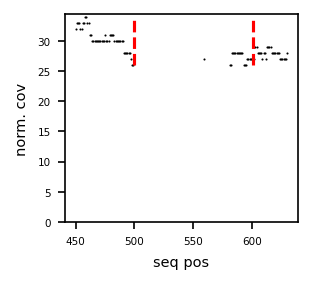

233


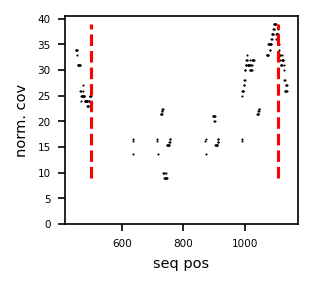

234


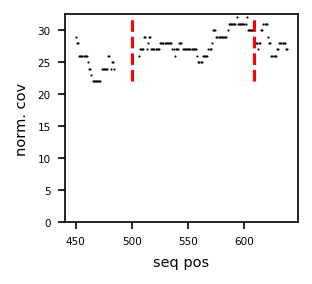

235


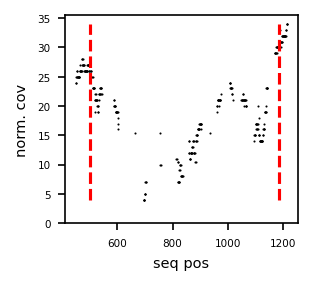

236


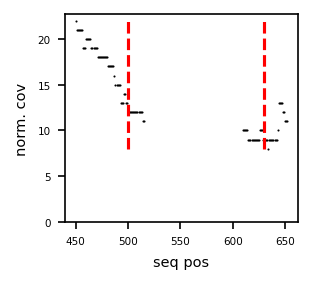

237


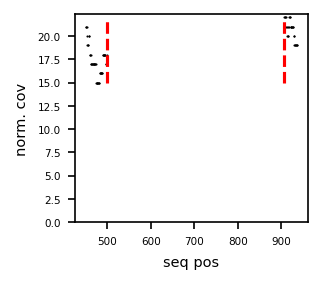

238


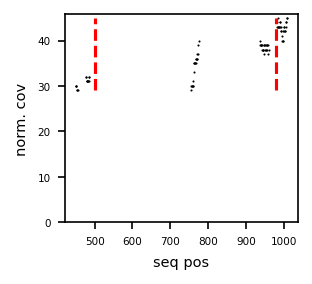

239


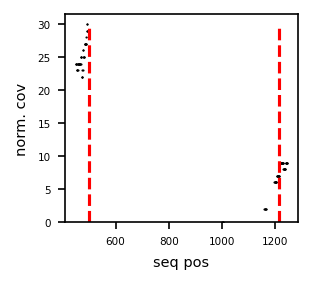

240


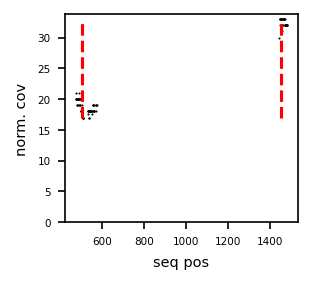

241


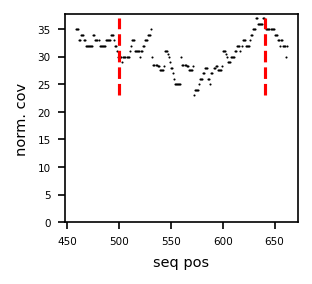

242


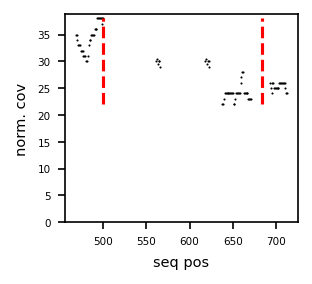

243


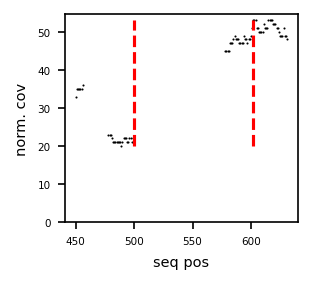

244


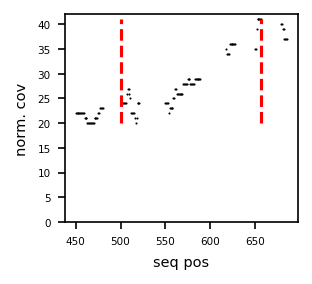

245


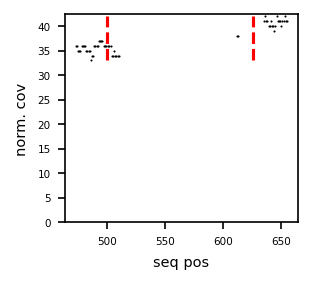

246


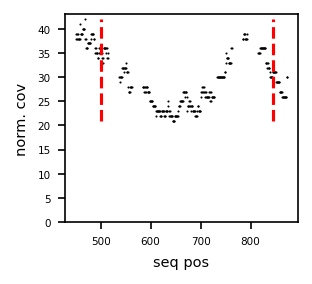

247


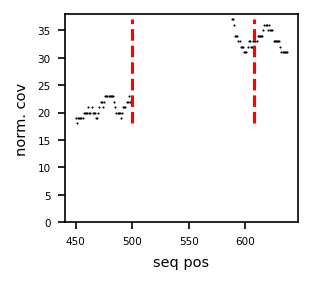

248


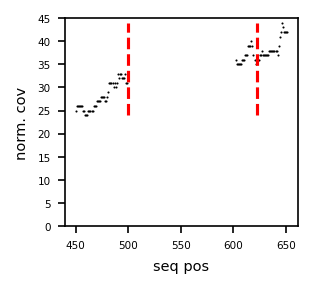

249


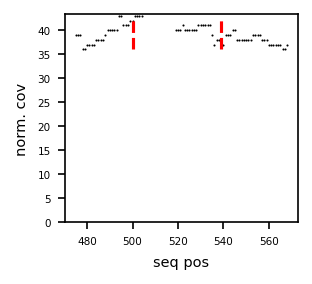

250


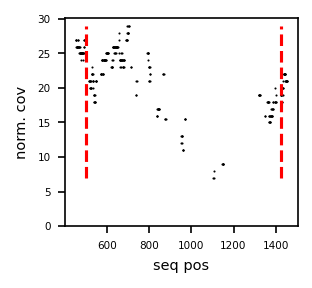

251


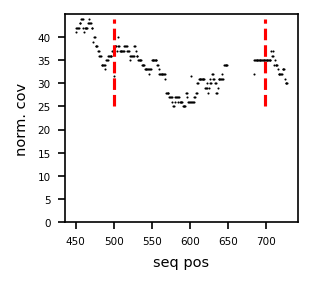

252


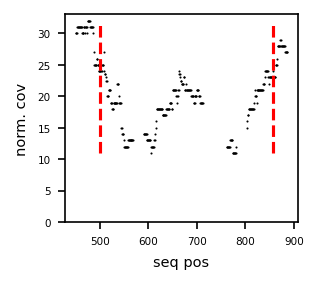

253


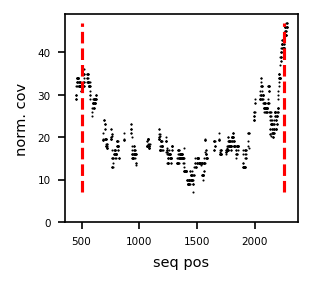

254


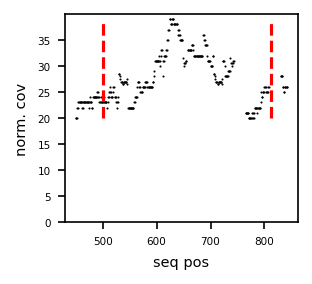

255


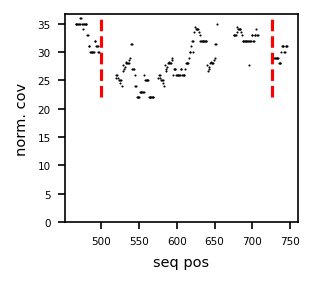

256


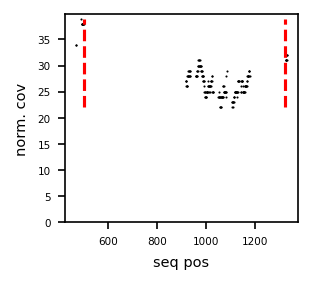

257


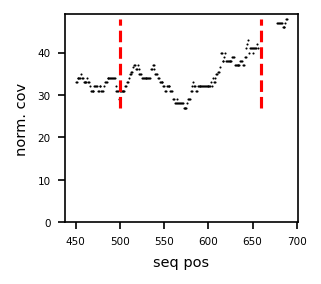

258


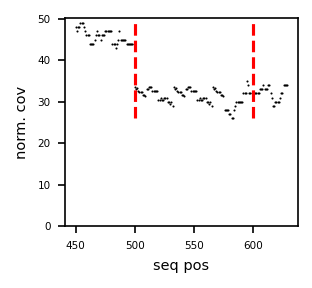

259


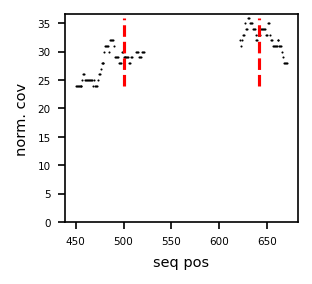

260


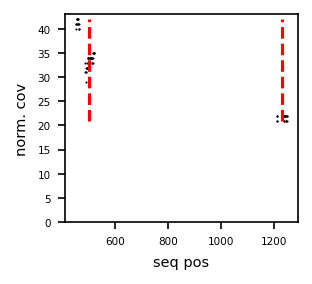

261


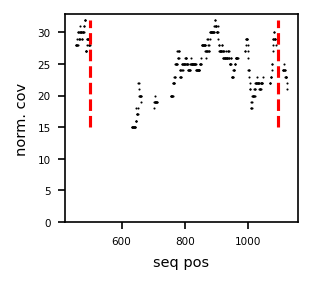

262


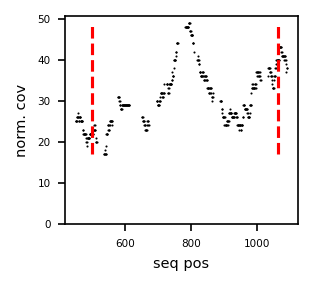

263


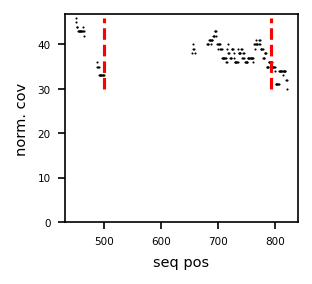

264


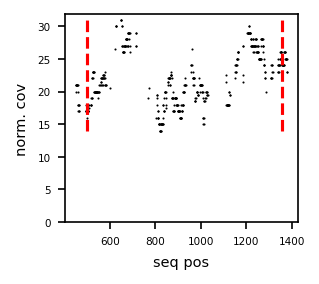

265


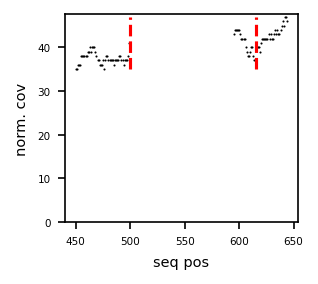

266


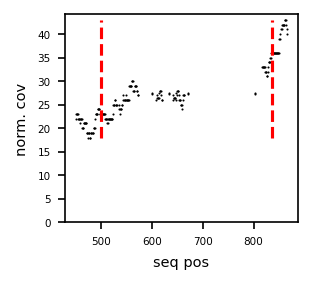

267


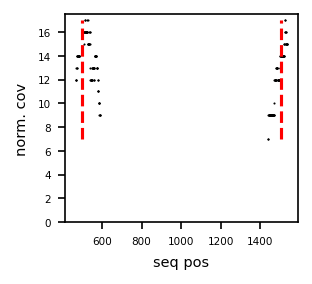

268


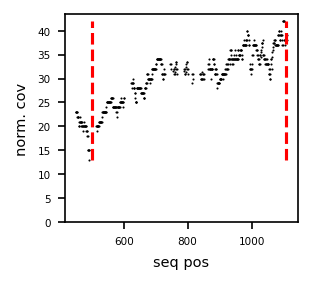

269


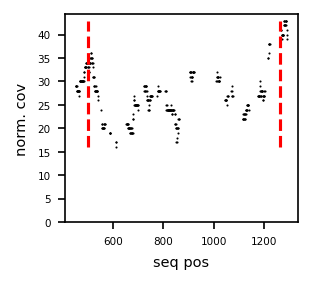

270


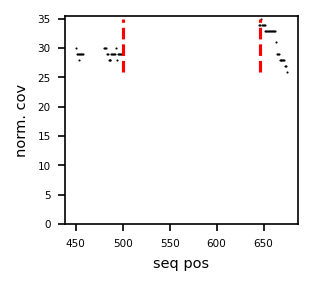

271


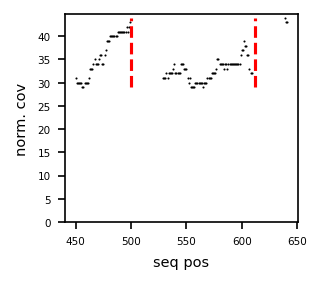

272


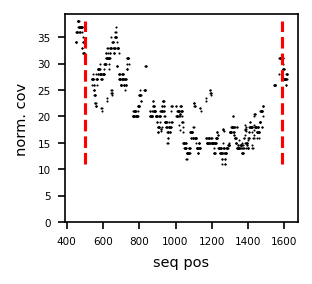

273


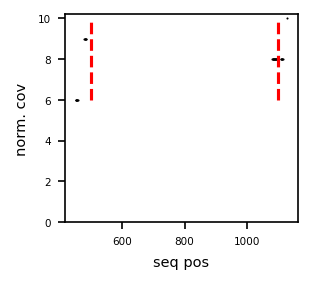

274


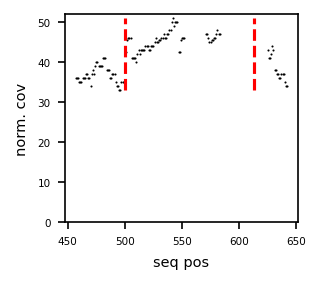

275


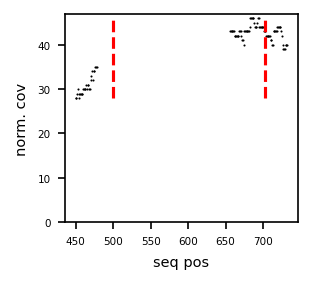

276


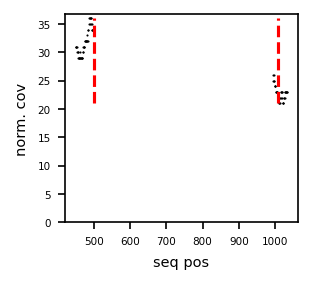

277


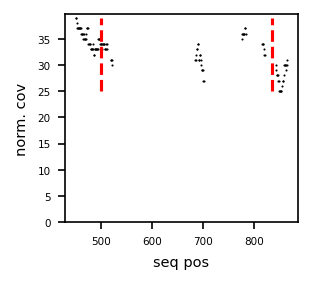

278


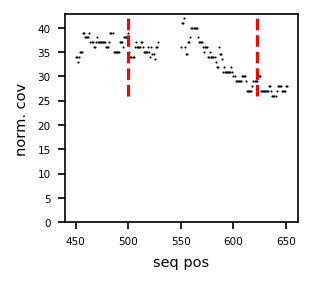

279


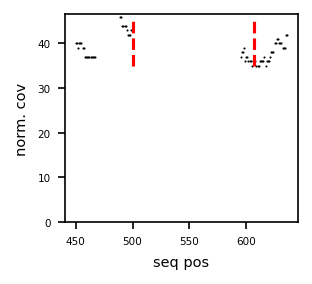

280


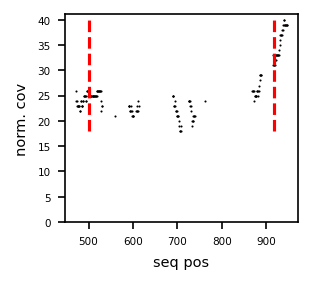

281


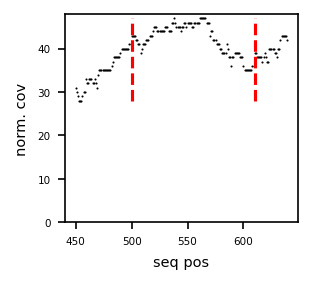

282


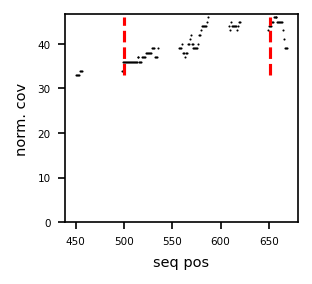

283


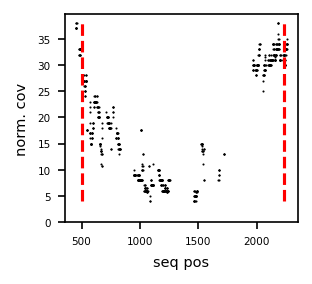

284


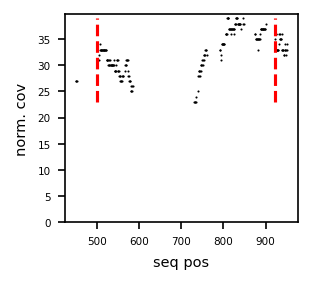

285


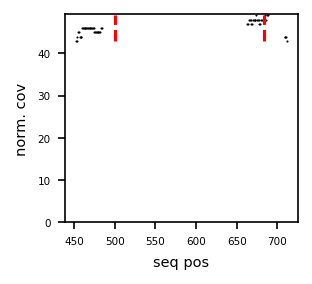

286


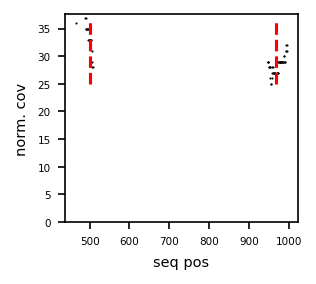

287


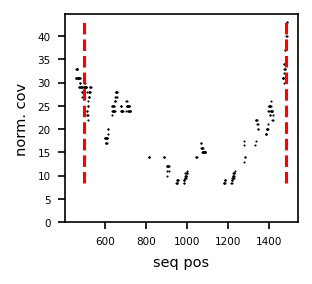

288


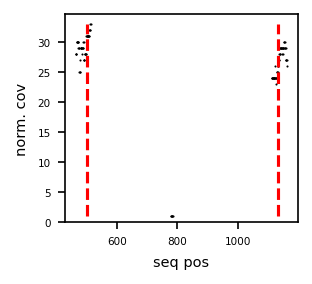

289


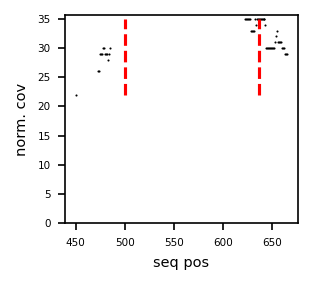

290


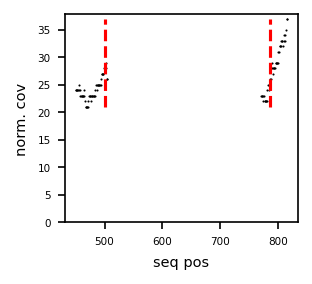

291


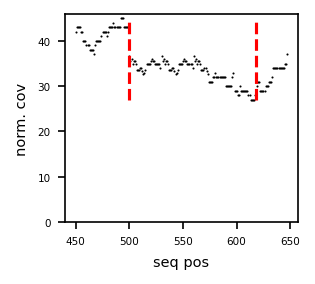

292


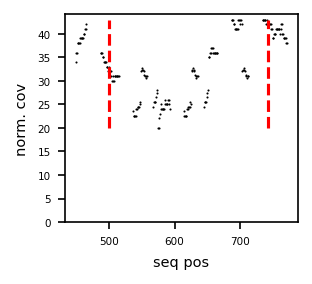

293


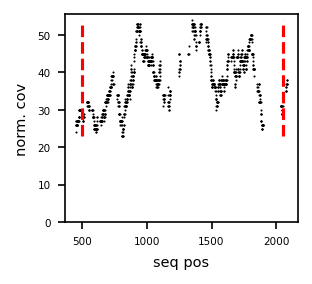

294


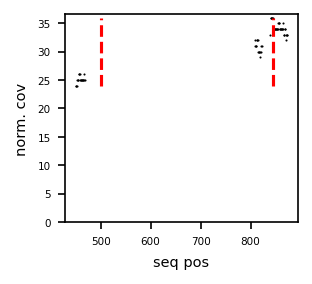

295


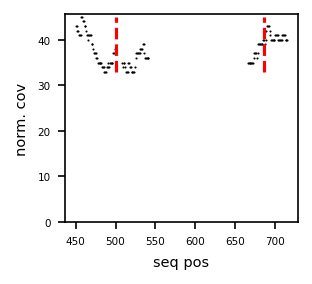

296


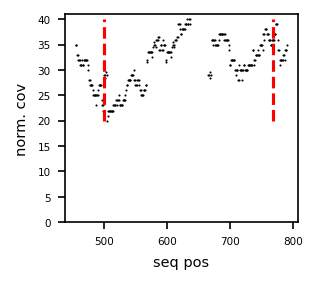

297


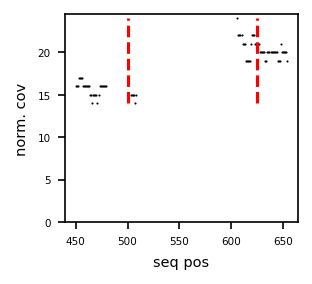

298


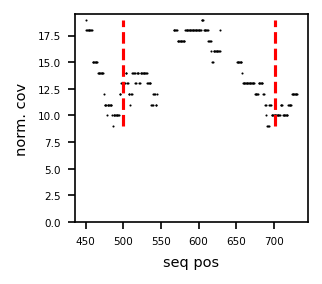

299


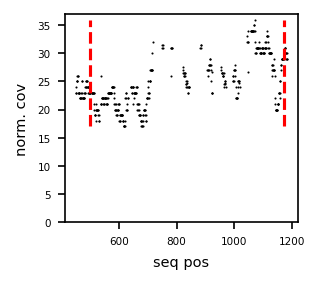

300


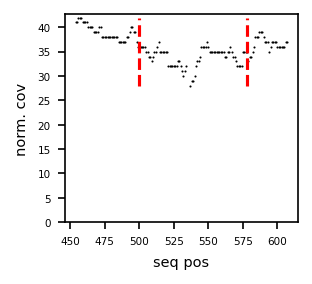

301


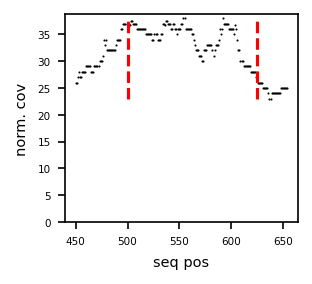

302


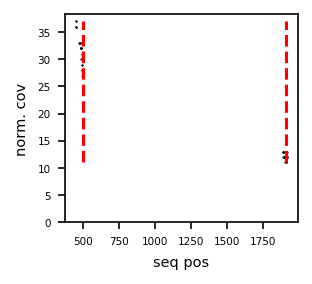

303


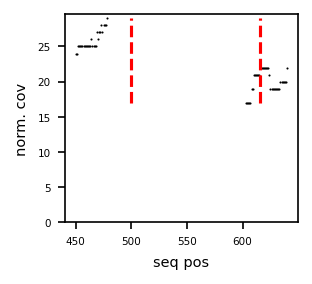

304


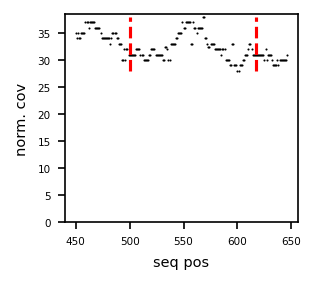

305


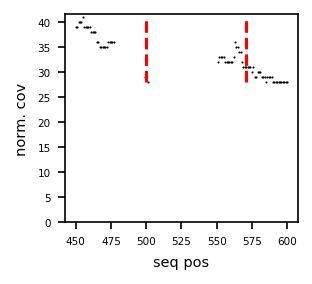

306


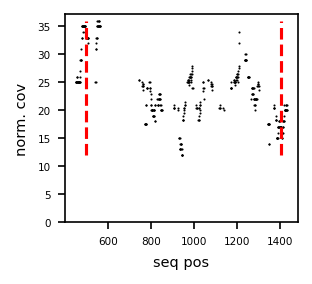

307


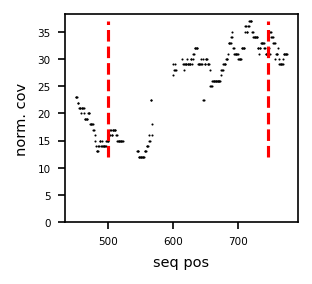

308


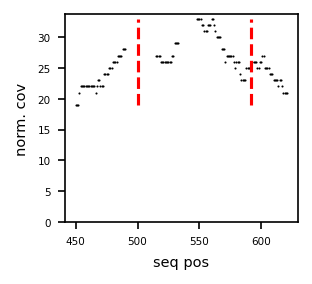

309


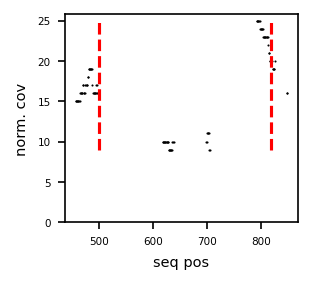

310


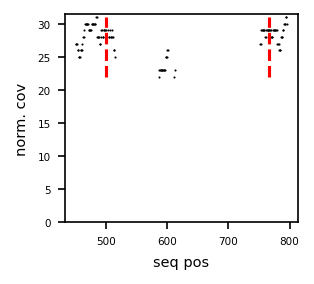

311


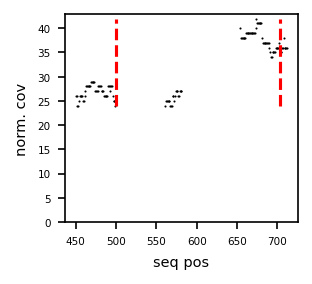

312


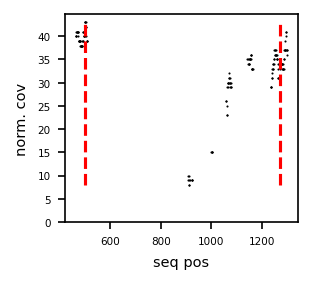

313


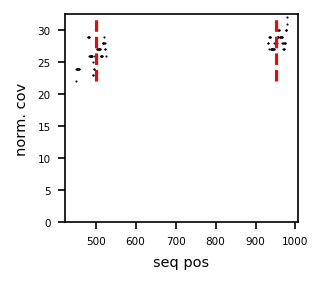

314


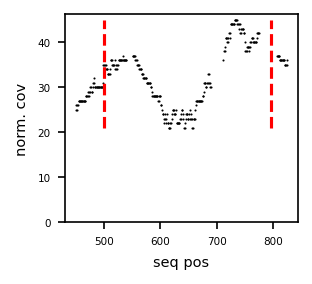

315


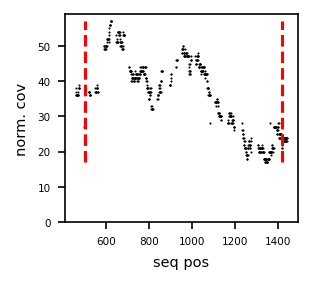

316


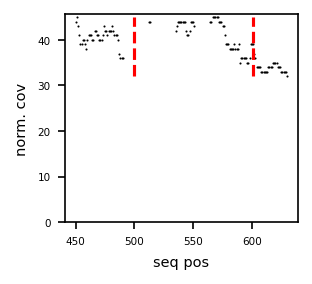

317


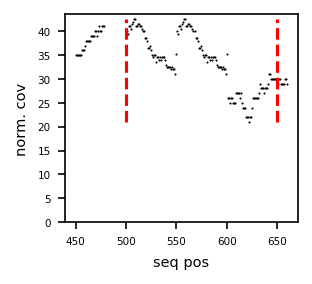

318


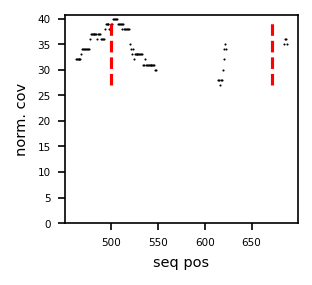

319


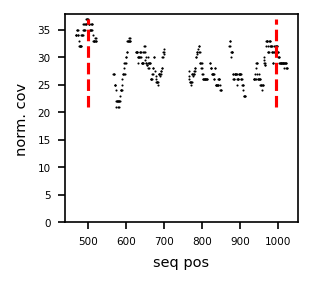

320


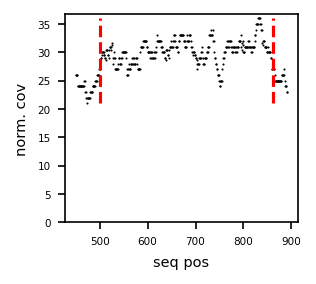

321


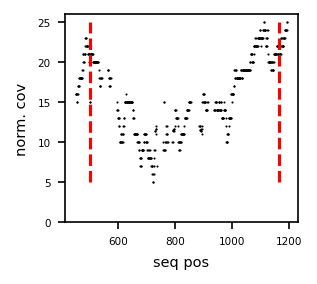

322


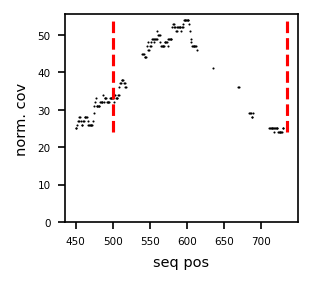

323


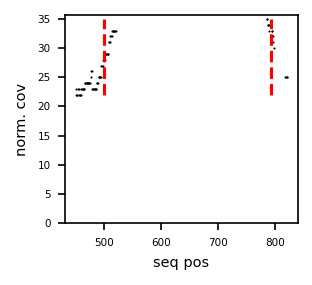

324


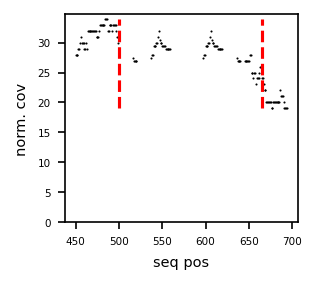

325


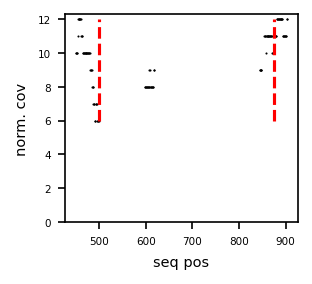

326


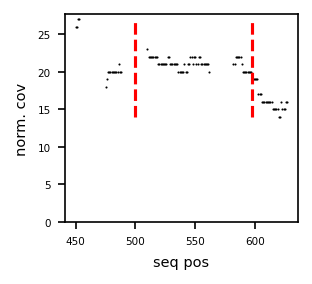

327


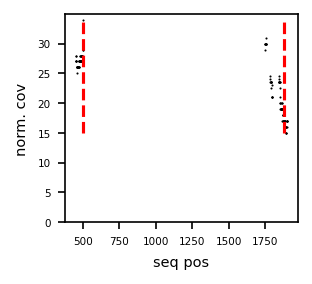

328


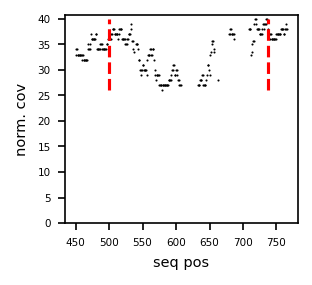

329


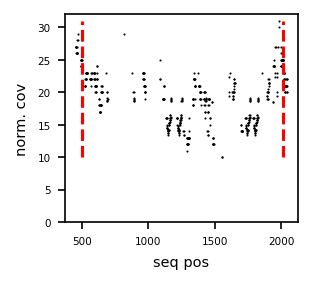

330


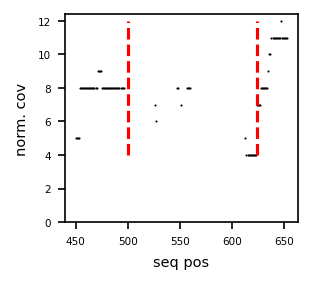

331


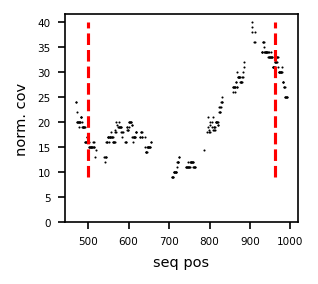

332


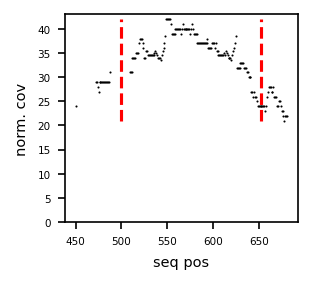

333


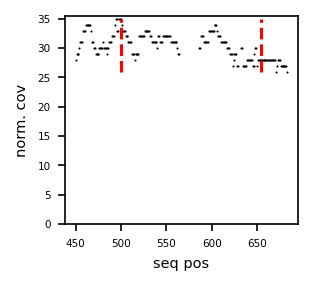

334


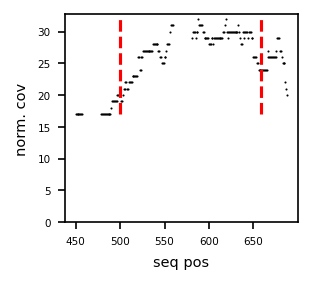

335


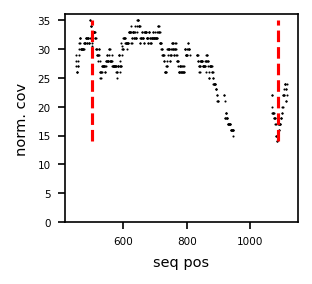

336


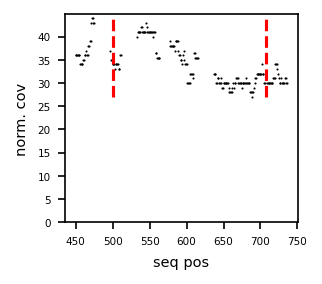

337


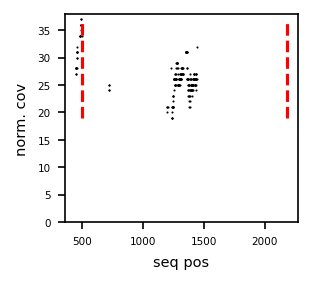

338


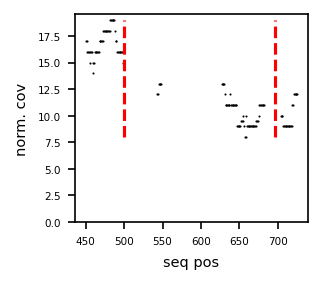

339


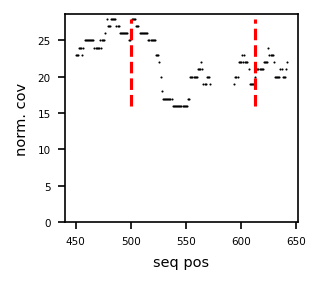

340


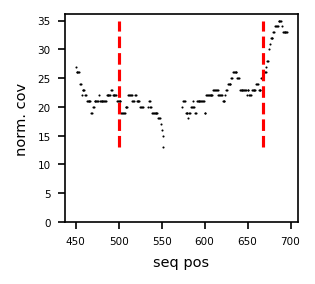

341


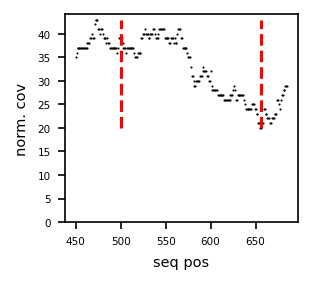

342


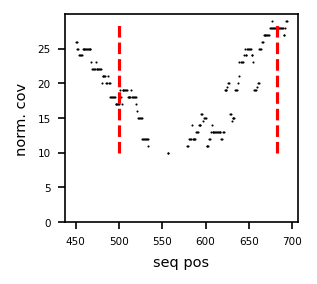

343


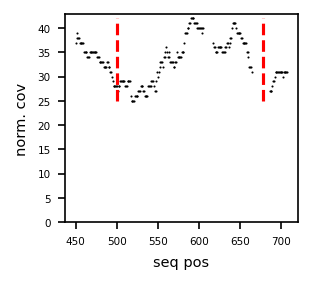

344


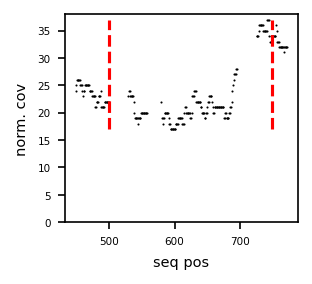

345


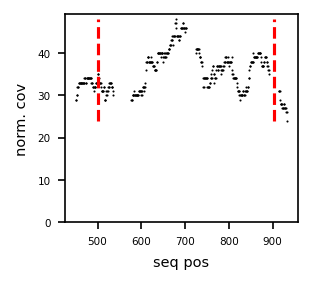

346


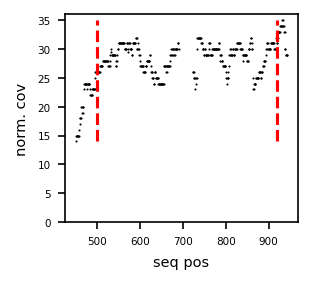

347


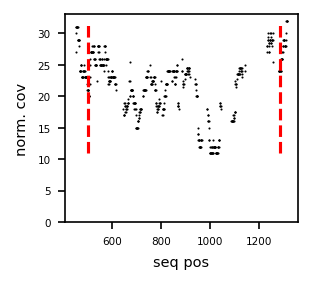

348


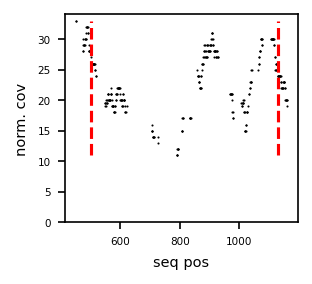

349


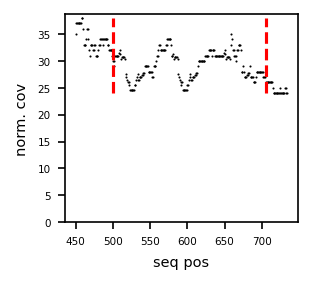

350


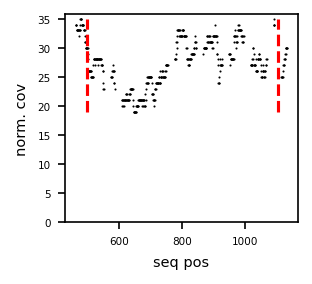

351


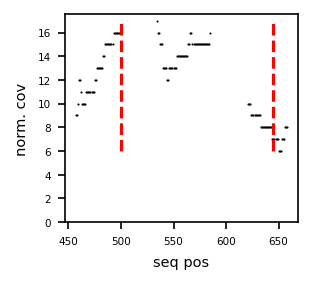

352


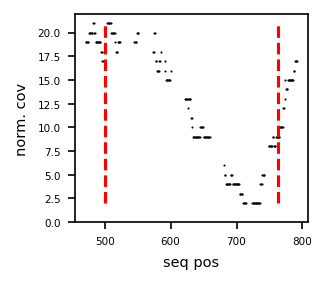

353


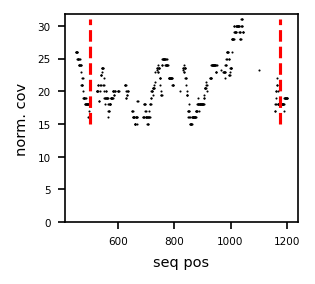

354


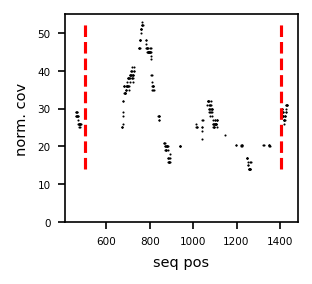

355


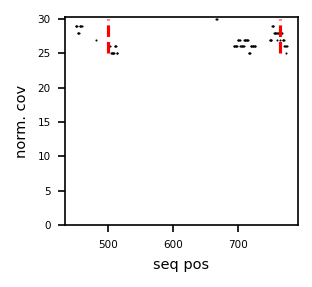

356


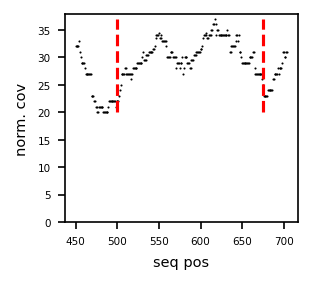

357


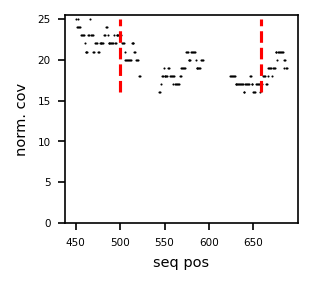

358


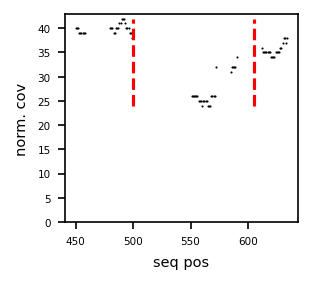

359


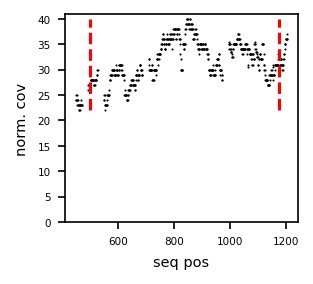

360


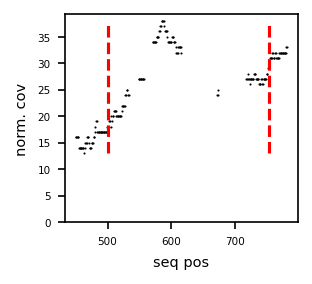

361


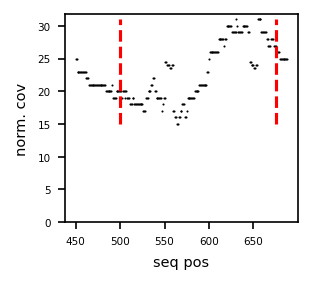

362


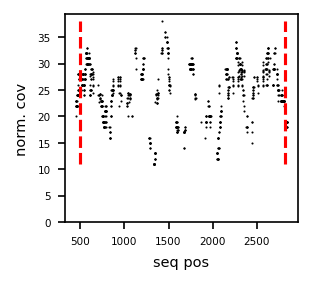

363


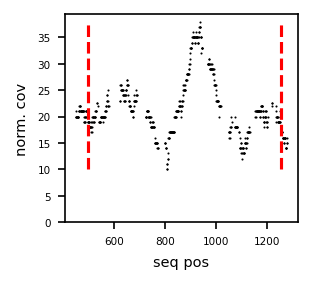

364


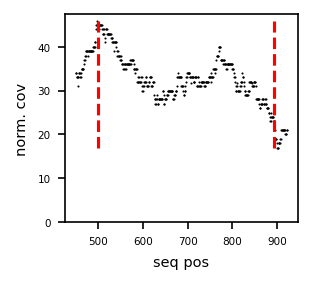

365


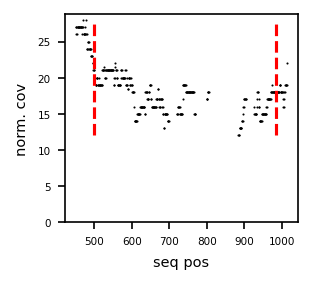

366


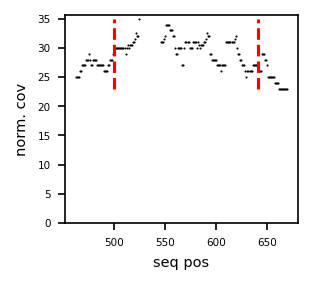

367


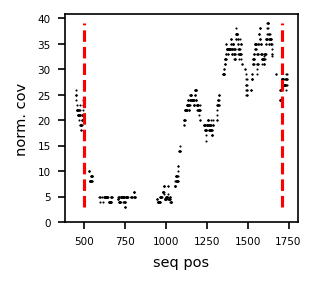

368


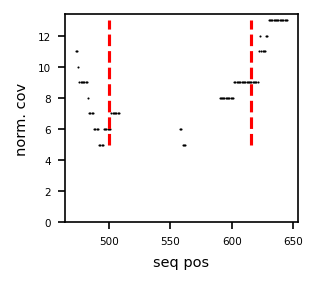

369


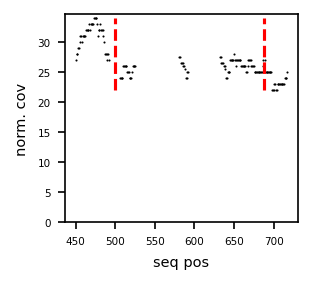

370


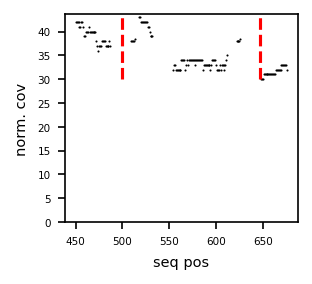

371


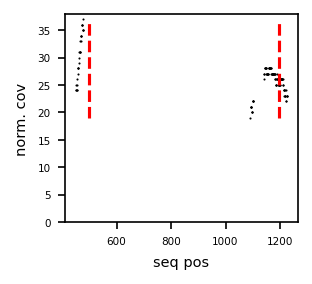

372


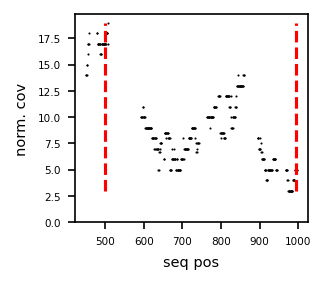

373


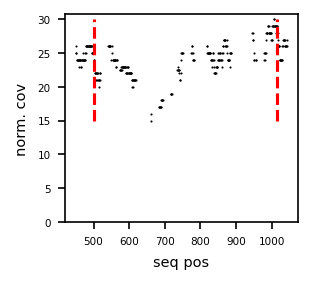

374


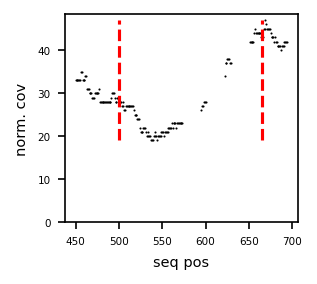

375


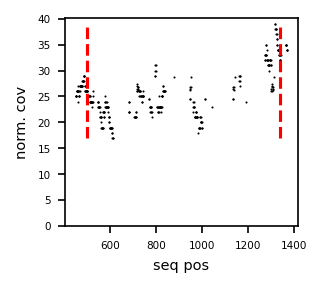

376


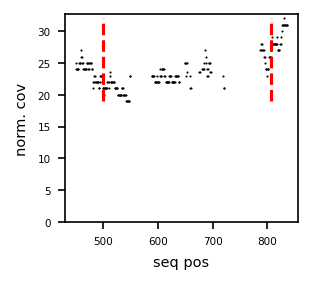

377


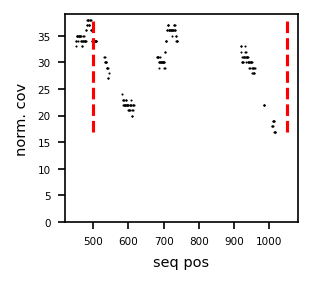

378


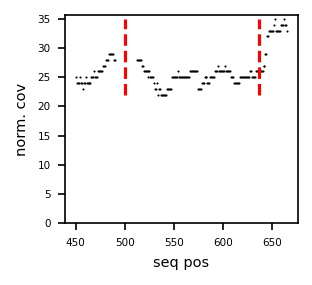

379


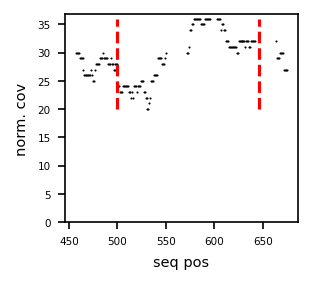

380


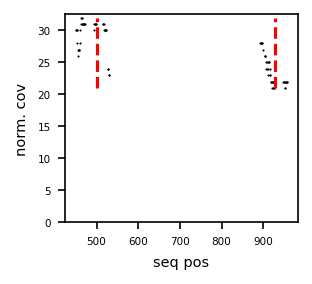

381


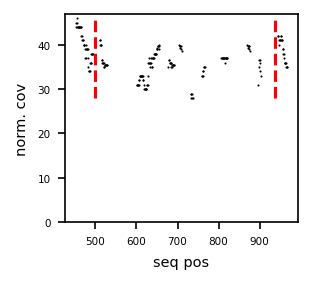

382


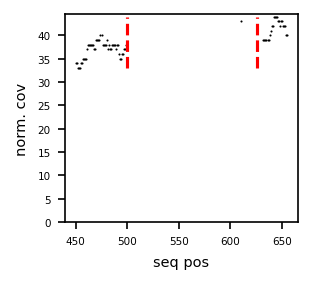

383


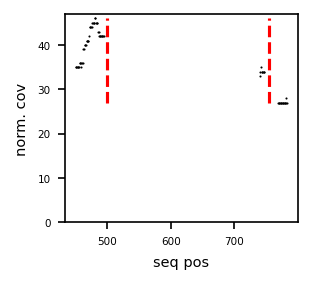

384


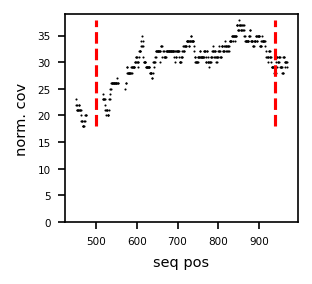

385


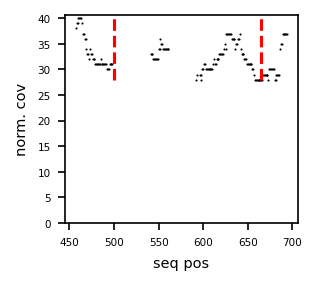

386


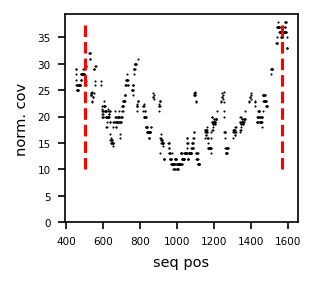

387


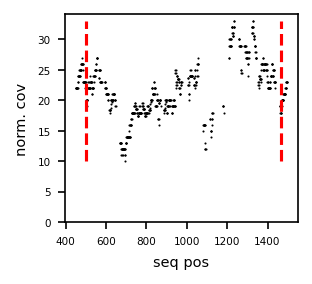

388


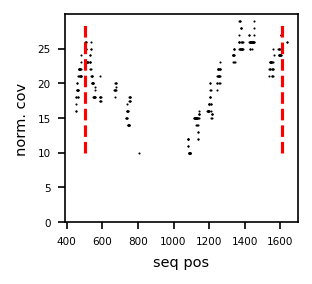

389


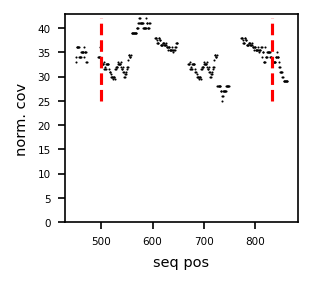

390


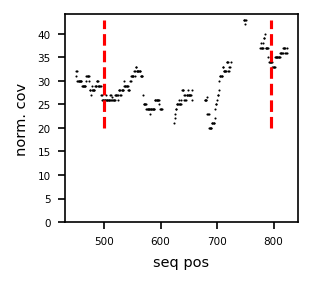

391


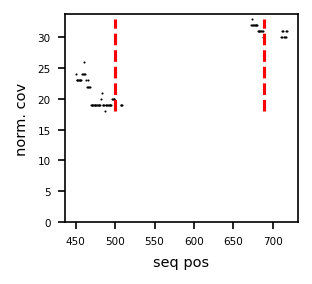

392


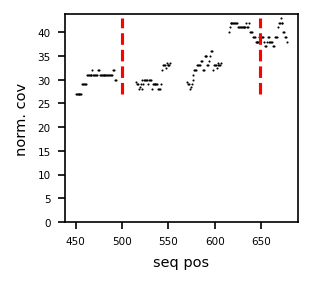

393


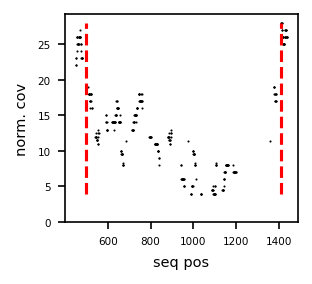

394


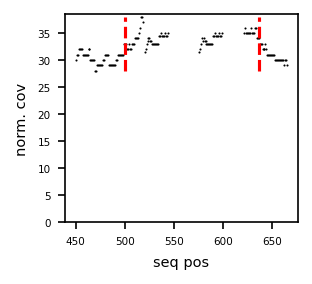

395


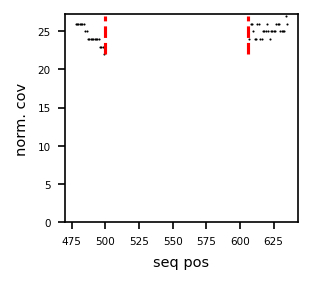

396


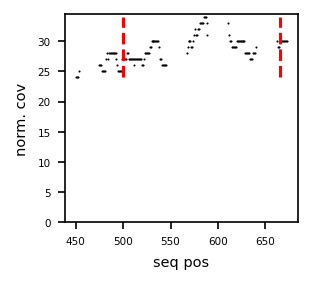

397


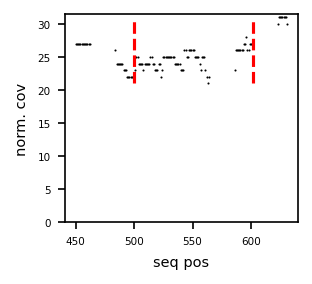

398


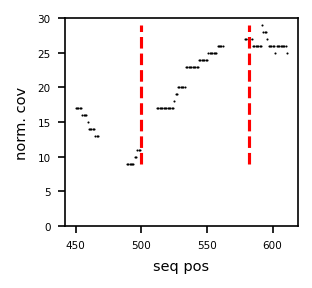

399


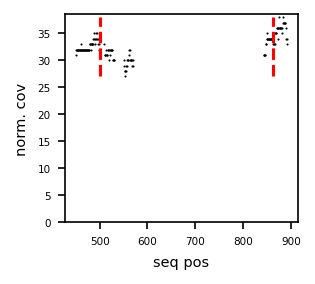

400


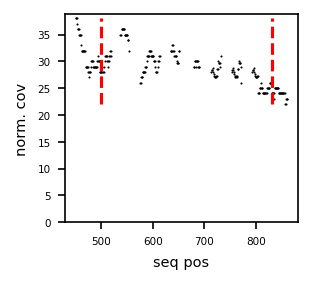

401


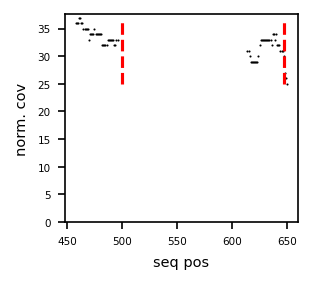

402


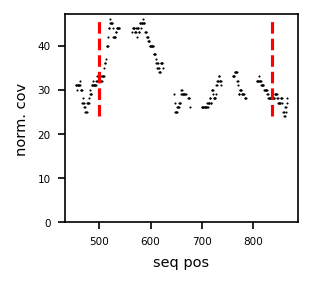

403


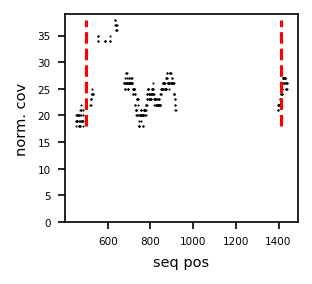

404


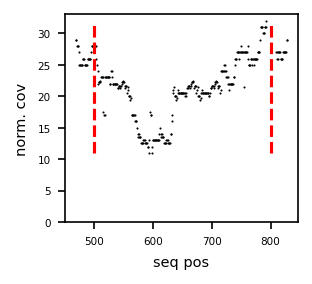

405


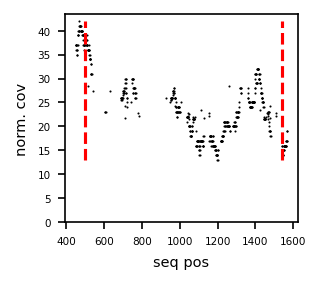

406


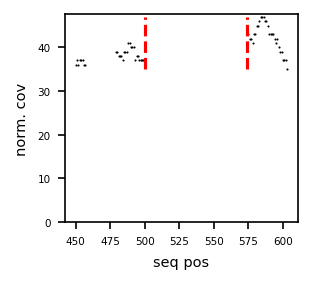

407


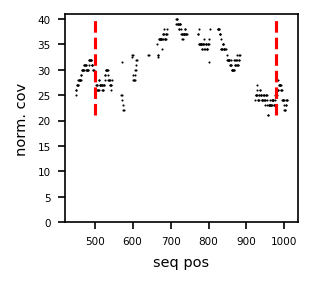

408


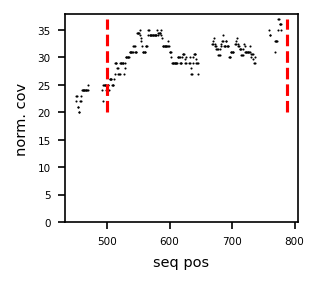

409


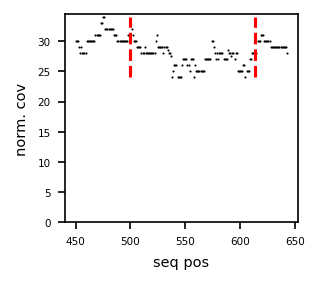

410


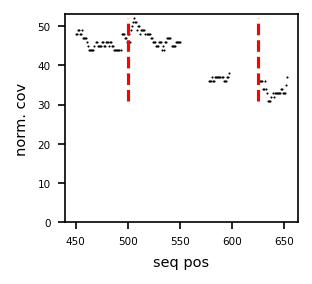

411


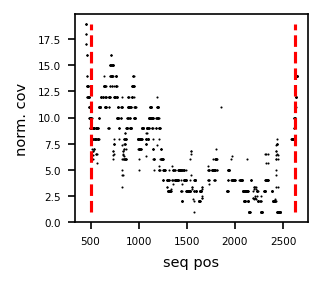

412


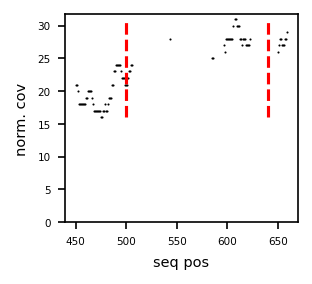

413


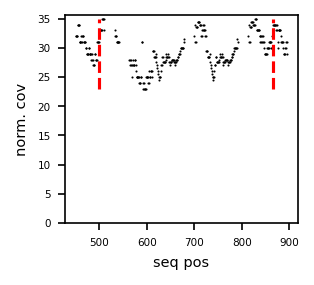

414


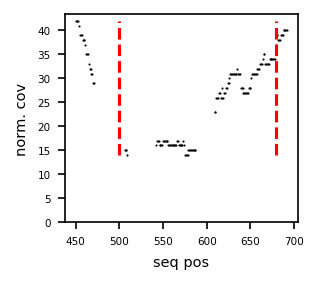

415


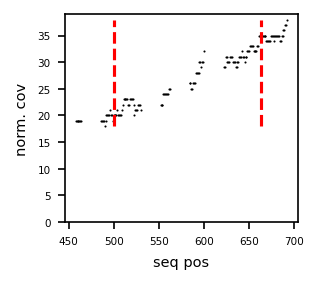

416


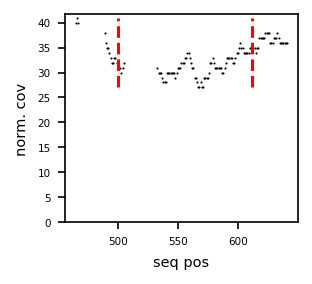

417


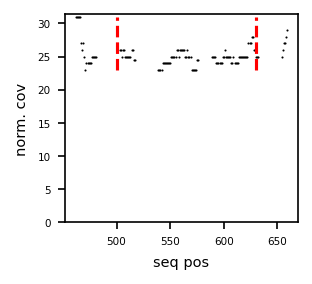

418


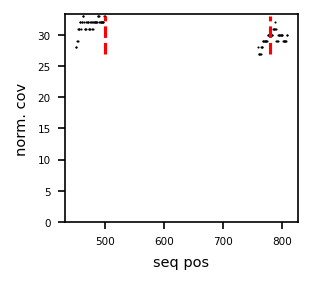

419


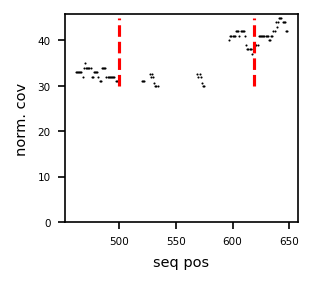

420


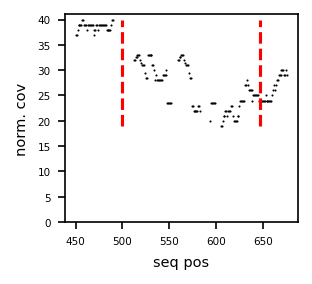

421


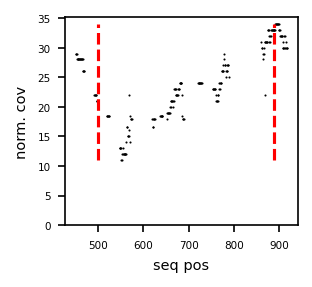

422


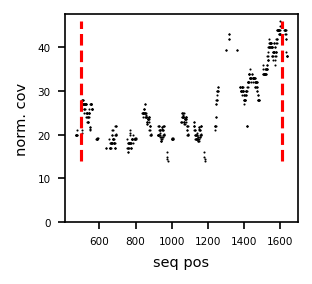

423


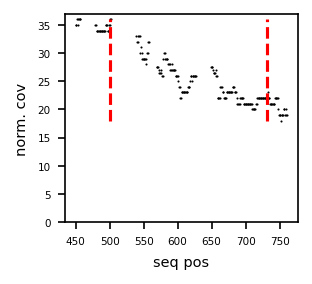

424


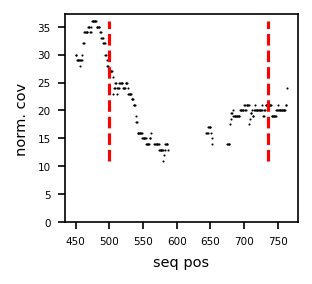

425


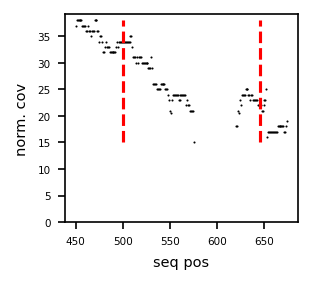

426


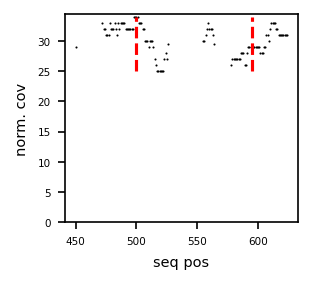

427


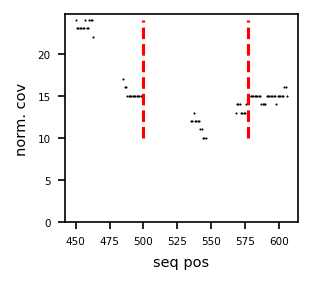

428


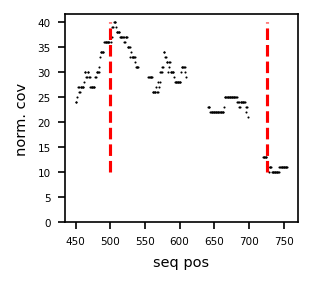

429


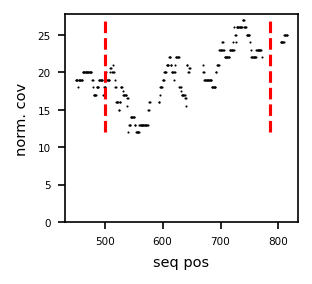

430


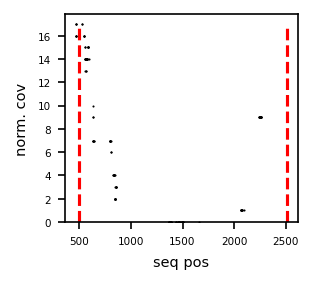

431


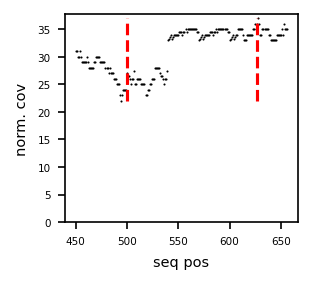

432


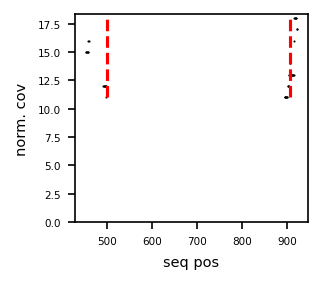

433


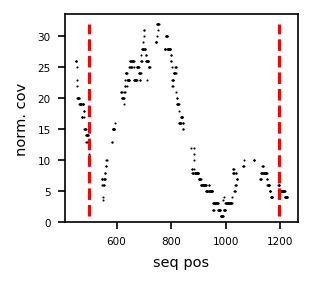

434


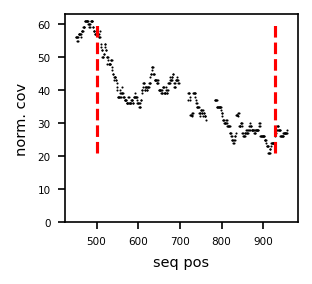

435


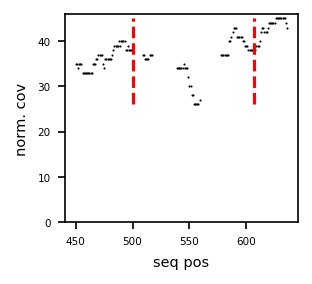

436


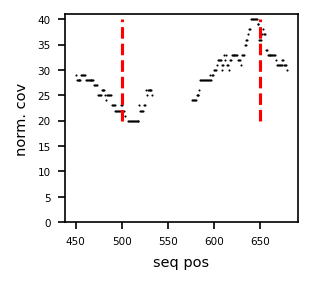

437


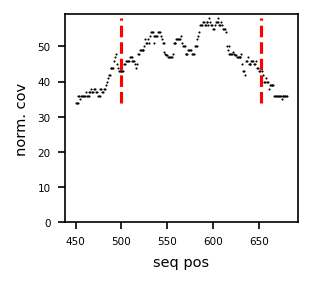

438


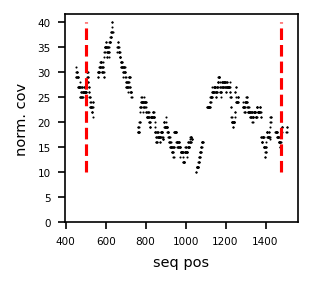

439


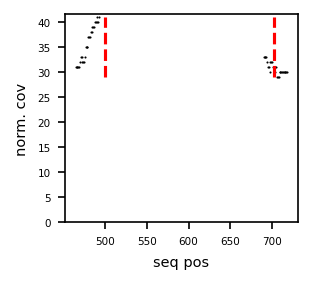

440


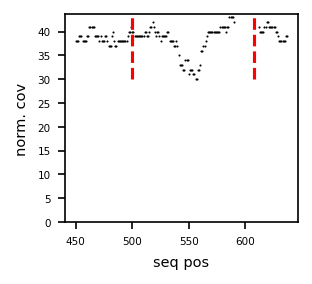

441


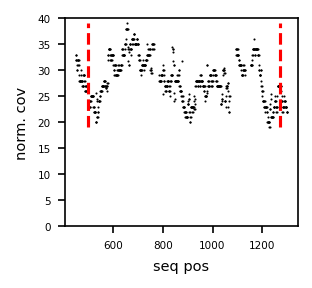

442


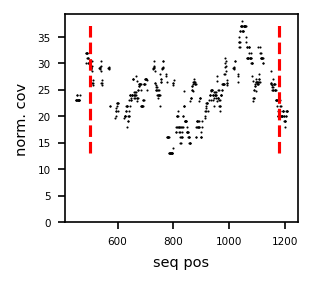

443


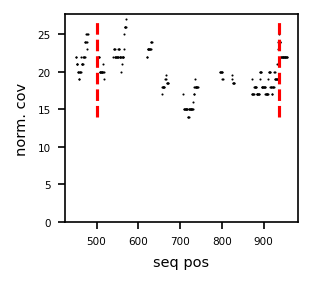

444


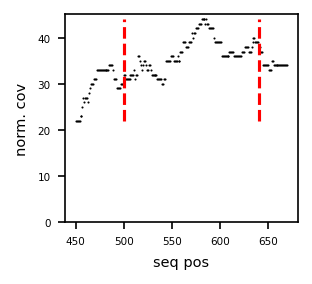

445


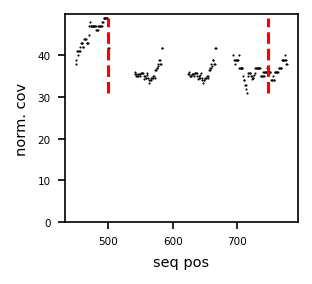

446


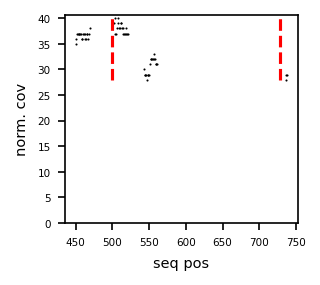

447


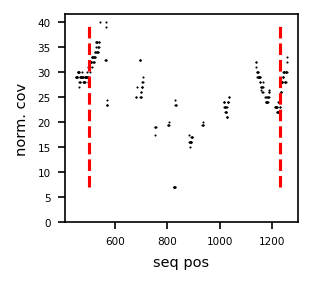

448


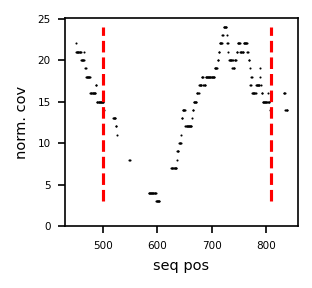

449


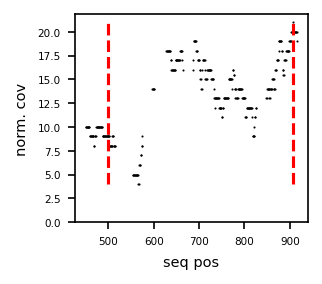

450


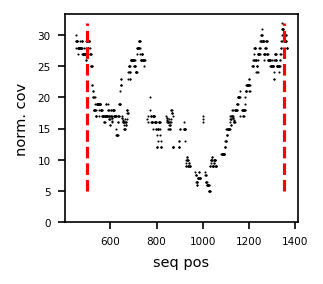

451


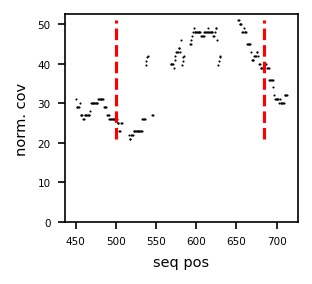

452


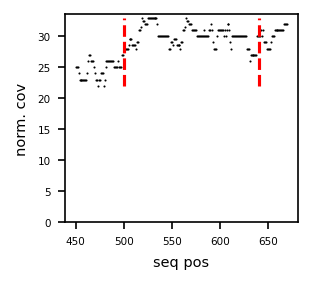

453


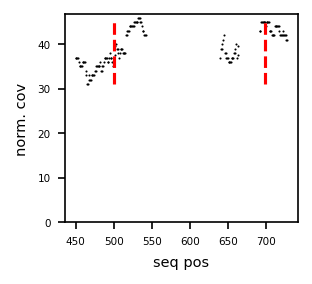

454


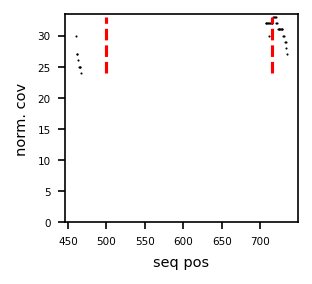

455


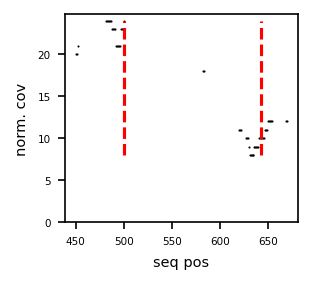

456


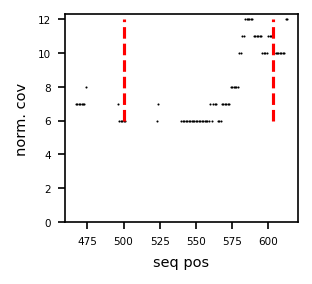

457


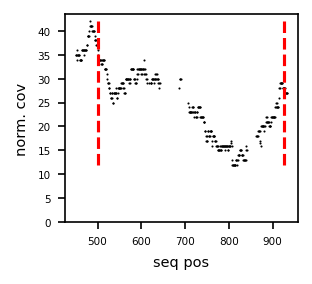

458
459


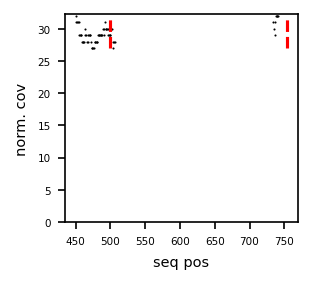

460


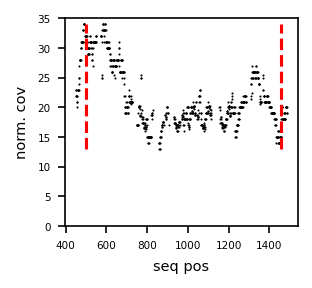

461


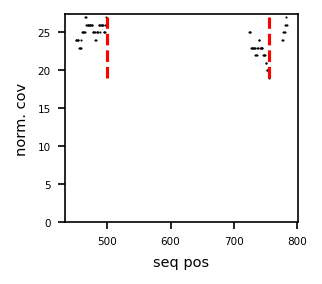

462


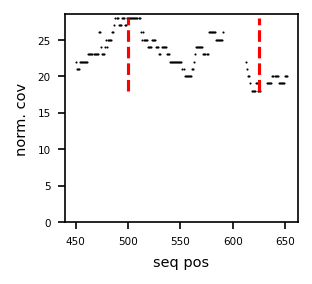

463


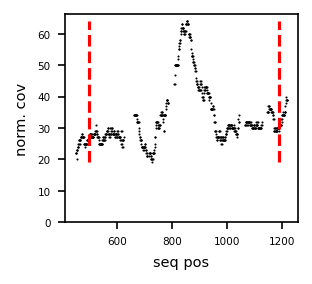

464


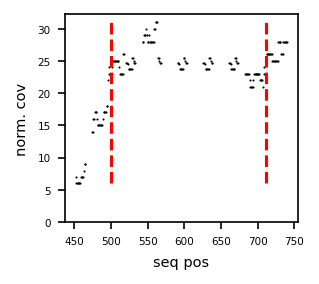

465


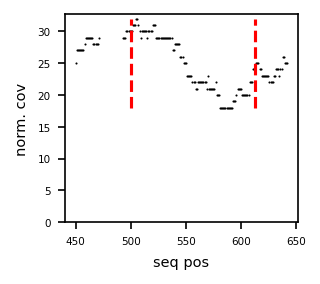

466


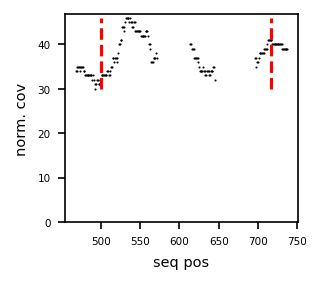

467


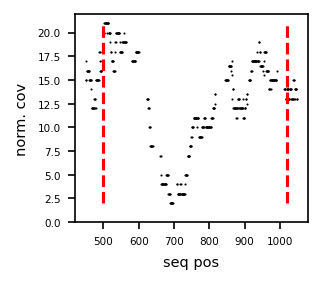

468


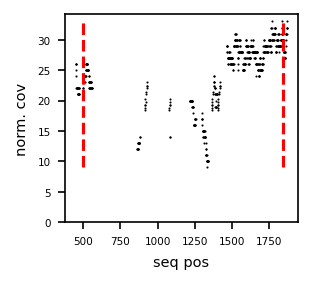

469


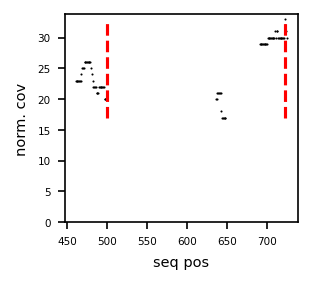

470


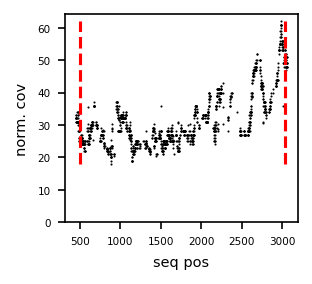

471


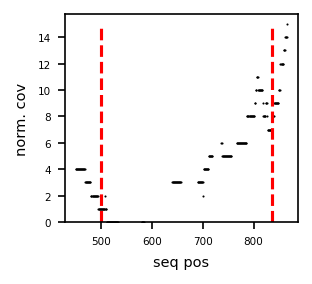

472


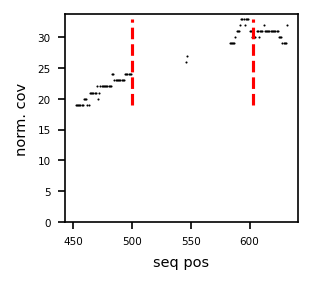

473


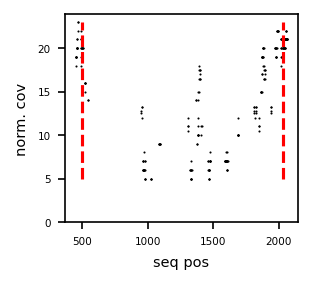

474


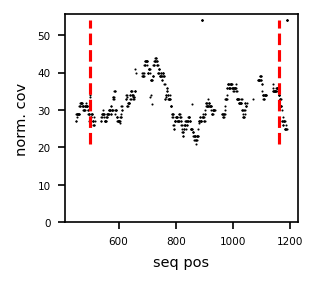

475


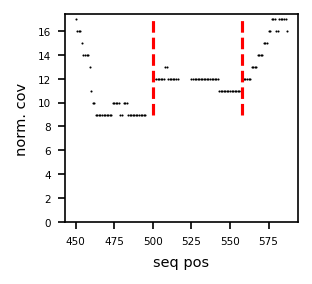

476


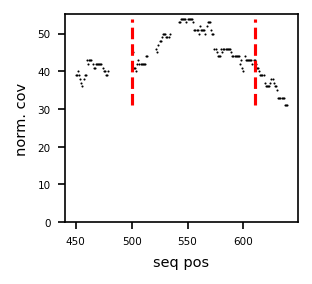

477


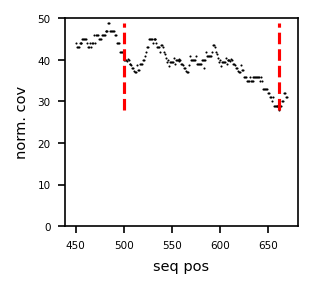

478


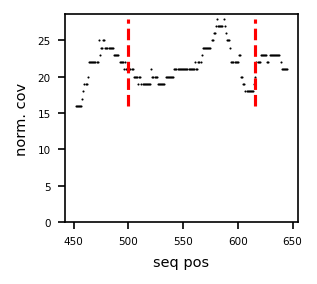

479


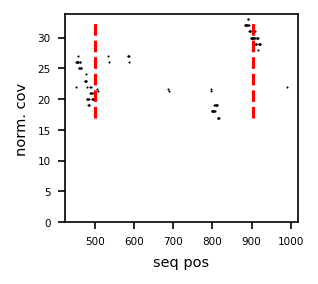

480


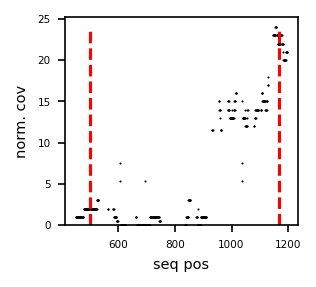

481


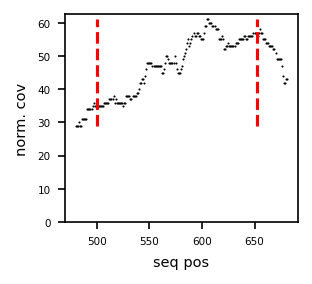

482


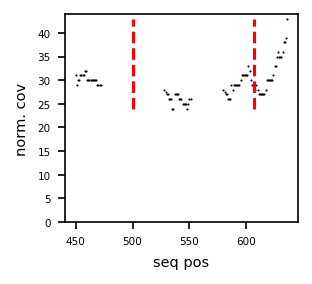

483


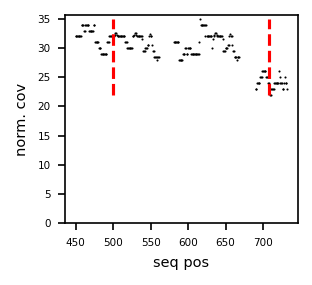

484


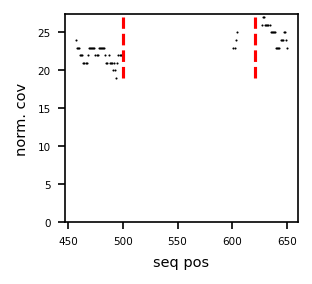

485


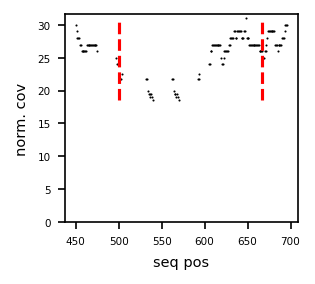

486


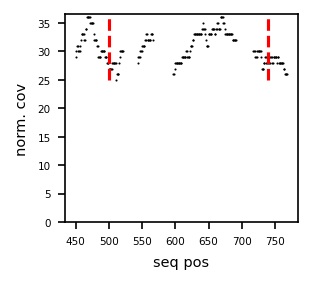

487


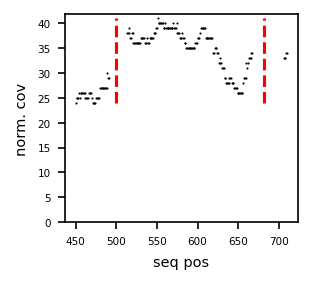

488


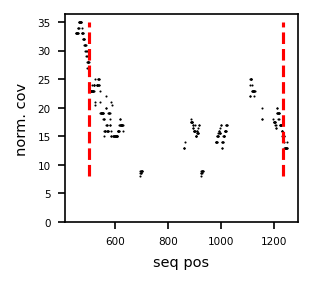

489


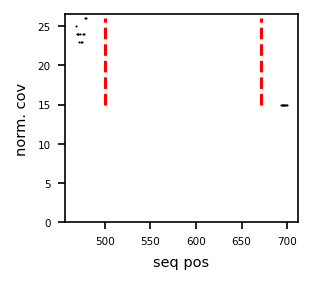

490


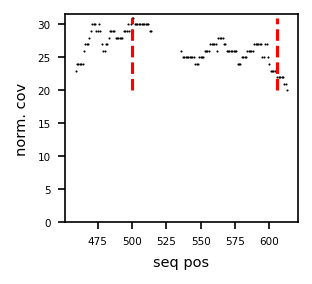

491


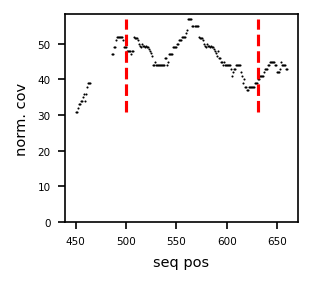

492


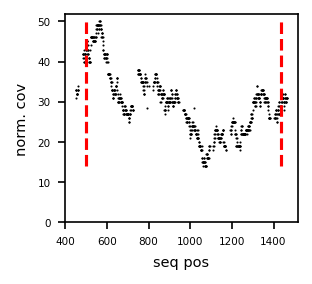

493


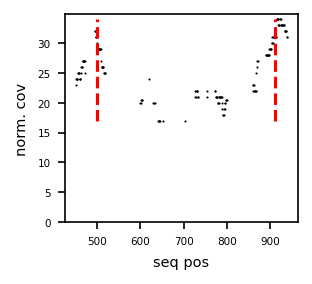

494


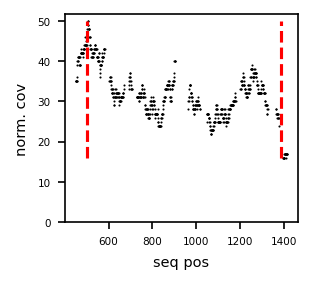

495


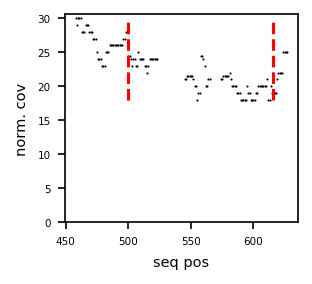

496


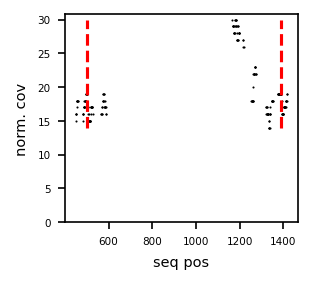

497


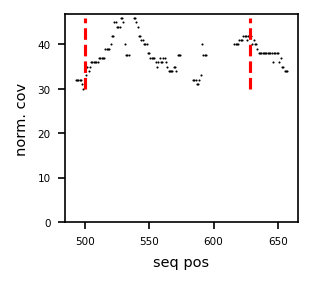

498


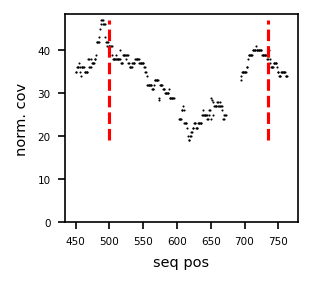

499


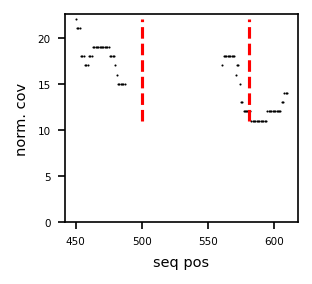

500


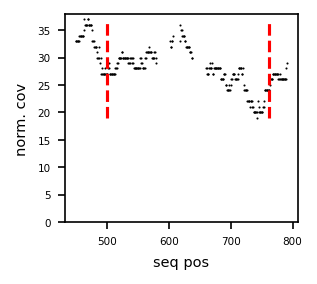

501


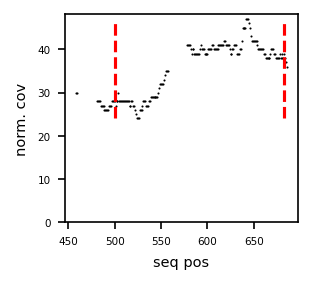

In [186]:
# visualize cov fluctuation at ikmers
def test():
    with open("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hprc/full.v1/analysis8/mapping/hprc/output1/HG00438.inv.name.kmers") as f:
        tri = -1
        for line in f:
            if line[0] == ">":
                if tri >= 0:
                    print(tri)
                    if xs:
                        fig, ax = utils.plot(xs, cts, "seq pos", "norm. cov", get_ax=True)
                        L = np.nanmin([len(v) if v else np.nan for v in trseqs[tri]])
                        m, M = min(cts), max(max(cts), min(cts)+1)
                        ax.plot([500,500], [m,M], '--r')
                        ax.plot([L-500,L-500], [m,M], '--r')
                        ax.set_ylim([0,None])
                        plt.show(); plt.close()
                    if tri > 500:
                        return
                tri += 1
                xs = []
                cts = []
                cts0, cts1 = [], [] # flank, TR
            else:
                km, ct = [int(v) for v in line.split()]
                if km in fl_tri2km2i[tri]: # ikmer in flank
                    ki = fl_tri2km2i[tri][km]
                    if km not in tri2ik2i[tri]:
                        # !!!!!! not sure why
                        print(f"{tri} flank missing pos info for {km}")
                        continue
                    ct_ = ct / fl_ikstats[ki,0]
                    for x in tri2ik2i[tri][km]:
                        xs.append(x)
                        cts.append(ct_)
                if km in tri2km2i[tri]: # ikmer in TR
                    ki = tri2km2i[tri][km]
                    ct_ = ct / ikstats[ki,0]
                    for x in tri2ik2i[tri][km]:
                        xs.append(x)
                        cts.append(ct_)

test()

In [20]:
def test():
    tri2ik2w = {} # >0 if is flank, <0 otherwise
    df = pd.DataFrame()
    df["name"] = ikdb.n
    df["tri"] = ikdb.i
    df["type"] = ikdb.t # TR=0, flank=1
    df["copy"] = ikdb.c
    df["weight"] = ikdb.w
    df["copy"] = df["copy"].astype(int)
    df["weight"] = df["weight"].astype(float)
    for dfi, (km, tri, t, w) in enumerate(zip(ikdb.n, ikdb.i, ikdb.t, ikdb.w)):
        if tri not in tri2ik2w:
            tri2ik2w[tri] = {}
        tri2ik2w[tri][km] = w if t else -w # w > 0 if flank else < 0
    return df, tri2ik2w
ik_df, tri2ik2w = test()

In [320]:
ik_df.iloc[0,:]#.iloc[[2,4]]#.to_numpy()

name      2.012882e+12
tri       0.000000e+00
type      1.000000e+00
copy      1.000000e+00
weight    5.681818e-03
Name: 0, dtype: float64

In [211]:
ik_df[ik_df.iloc[:,1]==2]#.iloc[:,3].tolist()

name  tri  type  copy    weight
162   499187197780    2     1     1  0.001286
163  1996748791122    2     1     1  0.001286
164   526301078776    2     1     1  0.014786
165  1200728641873    2     1     1  0.014786
166   404868056388    2     1     1  0.001286
..             ...  ...   ...   ...       ...
406  3173691747524    2     1     1  0.001286
407  3076518070084    2     1     1  0.001286
408  3222012710604    2     1     1  0.001286
409   845777499204    2     1     1  0.001286
410  3225032770796    2     1     1  0.001286

[249 rows x 5 columns]

In [303]:
def test():
    ntr = ki_tr.size
    for tri in range(ntr):
        m = ik_df.iloc[:,1] == tri
        if np.sum(m):
            assert np.isclose(np.sum(ik_df[m].iloc[:,4]), 1)
test()

In [24]:
def test():
    ntr = ki_tr.size
    gs = np.loadtxt(ilgsfile, dtype=object)
    ng = gs.size
    covs = np.full([ntr, ng, 2], np.nan)
    for gi, gn in enumerate(gs):
        print(".", end="")
        with open(f"/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hprc/full.v1/analysis8/mapping/hprc/output1/{gn}.inv.name.kmers") as f:
            tri = -1
            for line in f:
                if line[0] == ">":
                    if tri >= 0 and cov != 0:
                        covs[tri,gi] = cov
                    tri += 1
                    cov = [0,0]
                else:
                    km, ct = [int(v) for v in line.split()]
                    # if km not in tri2ik2dfi[tri]:
                    #     print(f"locus {tri} ikmer {km} missing from ikdb")
                    #     continue
                    w = tri2ik2w[tri][km]
                    if w > 0: # w > 0 if flank else < 0
                        cov[1] += ct*w
                    else:
                        cov[0] += -(ct*w)
    return covs
ikcovmat = test()

........................................

In [30]:
# pickle.dump(ikcovmat, open("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hprc/full.v1/analysis8/mapping/hprc/ikcovmat.pickle", 'wb'))

In [13]:
ikcovmat = pickle.load(open("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hprc/full.v1/analysis8/mapping/hprc/ikcovmat.pickle", 'rb'))

In [113]:
def test():
    ntr = ki_tr.size
    gs = np.loadtxt(ilgsfile, dtype=object)
    ng = gs.size
    bias = np.sum(ikcovmat, axis=2)
    bias[bias==0] = np.nan
    rds = np.loadtxt("/project/mchaisso_100/cmb-17/vntr_genotyping/analysis/read_depth/ctrl/HPRC.chr1.cov.tsv", usecols=1)
    bias /= rds
    bias /= np.nanmean(bias, axis=1)[:,None]
    bias[~np.isfinite(bias)] = 1 
    return bias
bias_v1 = test()

/tmp/SLURM_23715689/ipykernel_1118/4059541233.py:9: RuntimeWarning: Mean of empty slice
  bias /= np.nanmean(bias, axis=1)[:,None]


In [114]:
# np.savetxt("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hprc/full.v1/analysis8/mapping/hprc/bias_v1.tsv.gz", bias_v1, fmt="%s", delimiter="\t")

In [14]:
bias_v1 = np.loadtxt("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hprc/full.v1/analysis8/mapping/hprc/bias_v1.tsv.gz")

In [115]:
def test():
    ntr = len(ki_tr)
    ilagt_bc_v1 = np.copy(ilagt)
    for tri in range(ntr):
        si, ei = get_ki(tri)
        ilagt_bc_v1[si:ei] /= bias_v1[tri]
        
    return ilagt_bc_v1
ilagt_bc_v1 = test()

In [ ]:
# obsolete, need to save again
np.savetxt("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hprc/full.v1/analysis8/mapping/hprc/ilagt_bc_v1.tsv.gz", ilagt_bc_v1, fmt="%s", delimiter="\t")

# Rerun batch-r2 with correction method v1

In [22]:
def test():
    ntr, ng = bias_v1.shape
    nk = ki_tr[-1]
    r2s_v1 = np.full(ntr, np.nan)
    famat = fagt[:,gsmask]
    ilmat = np.copy(ilagt)
    n = 0
    for tri in range(ntr):
        if tri % 1000 == 0: print(".", end="", flush=True)
        if np.all(bias_v1[tri]==1):
            n += 1
            continue
        si = ki_tr[tri-1] if tri else 0
        ei = ki_tr[tri]
        X = np.sum(famat[si:ei,:], axis=0)
        Y = np.sum(ilmat[si:ei,:], axis=0)
        Ya = Y / bias_v1[tri]
        m = np.isfinite(X)
        x = np.insert(X[m],0,0)
        ya = np.insert(Ya[m],0,0)
        if np.unique(x).size == 1 or np.all(ya==0):
            continue
        rega = sm.OLS(ya, sm.add_constant(x)).fit()
        r2s_v1[tri] = rega.rsquared
    return r2s_v1
r2s_v1 = test()

...............................

# of corrected loci in v0/v1 = 27543 (90.3%) --> 30252 (99.2%)
mean batch-r2 0.744 --> 0.737


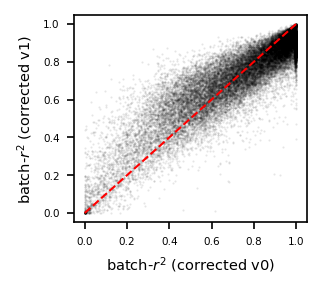

mean batch-r2 0.461 --> 0.548 for loci not estimated in v0


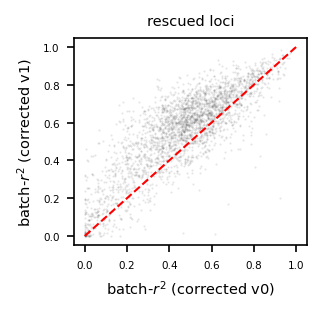

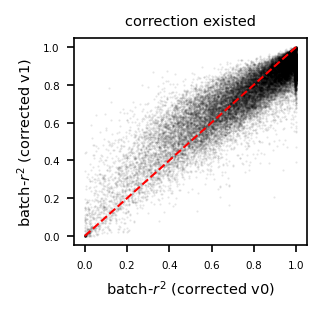

In [117]:
def test():
    df = pd.read_csv("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hprc/full.v1/analysis8/r2/output/dosage.r2.tsv", sep="\t", na_values=".")
    r2s = df["dosage.r2.corrected"].to_numpy()
    r2s_ = df["dosage.r2.uncorrected"].to_numpy()
    m0 = np.isfinite(r2s)
    m1 = np.isfinite(r2s_v1)
    n0 = np.sum(np.isfinite(r2s) & (r2s!=r2s_))
    n1 = np.sum(m1)
    N = r2s.size
    print(f"# of corrected loci in v0/v1 = {n0} ({n0/N:.1%}) --> {n1} ({n1/N:.1%})")
    mn0 = np.mean(r2s[m0])
    mn1 = np.mean(r2s_v1[m1])
    print(f"mean batch-r2 {mn0:.3f} --> {mn1:.3f}")
    
    fig, ax = utils.plot(r2s, r2s_v1, "batch-$r^2$ (corrected v0)", "batch-$r^2$ (corrected v1)", alpha=0.1, get_ax=True)
    ax.plot([0,1],[0,1], '--r', lw=1)
    plt.show(); plt.close()
    
    m = (r2s==r2s_)
    mn0 = np.mean(r2s[m])
    r2s_v1_ = np.copy(r2s_v1)
    m1 = ~np.isfinite(r2s_v1_)
    r2s_v1_[m1] = r2s_[m1]
    mn1 = np.mean(r2s_v1_[m])
    print(f"mean batch-r2 {mn0:.3f} --> {mn1:.3f} for loci not estimated in v0")
    fig, ax = utils.plot(r2s[m], r2s_v1[m], "batch-$r^2$ (corrected v0)", "batch-$r^2$ (corrected v1)", "rescued loci", alpha=0.1, get_ax=True)
    ax.plot([0,1],[0,1], '--r', lw=1)
    plt.show(); plt.close()
    
    fig, ax = utils.plot(r2s[~m], r2s_v1[~m], "batch-$r^2$ (corrected v0)", "batch-$r^2$ (corrected v1)", "correction existed", alpha=0.1, get_ax=True)
    ax.plot([0,1],[0,1], '--r', lw=1)
    plt.show(); plt.close()
    

    return r2s
r2s = test()

# Bias correction v2.1
- weight over TR:flank

In [118]:
def test():
    ntr = ki_tr.size
    gs = np.loadtxt(ilgsfile, dtype=object)
    ng = gs.size
    ws = np.arange(0,0.22,0.02)
    nw = ws.size
    biasXw = np.full([ntr,ng,nw], np.nan)
    rds = np.loadtxt("/project/mchaisso_100/cmb-17/vntr_genotyping/analysis/read_depth/ctrl/HPRC.chr1.cov.tsv", usecols=1)
    for i2, w in enumerate(ws):
        bias = w*ikcovmat[:,:,1] + (1-w)*ikcovmat[:,:,0]
        bias[bias==0] = np.nan
        bias /= rds
        bias /= np.nanmean(bias, axis=1)[:,None]
        bias[~np.isfinite(bias)] = 1 
        biasXw[:,:,i2] = bias
    return biasXw
biasXw = test()

/tmp/SLURM_23715689/ipykernel_1118/2957594249.py:13: RuntimeWarning: Mean of empty slice
  bias /= np.nanmean(bias, axis=1)[:,None]


In [15]:
def test():
    ntr = ki_tr.size
    gs = np.loadtxt(ilgsfile, dtype=object)
    ng = gs.size
    w = 0.14
    bias = np.full([ntr,ng], np.nan)
    rds = np.loadtxt("/project/mchaisso_100/cmb-17/vntr_genotyping/analysis/read_depth/ctrl/HPRC.chr1.cov.tsv", usecols=1)
    bias = w*ikcovmat[:,:,1] + (1-w)*ikcovmat[:,:,0]
    bias[bias==0] = np.nan
    bias /= rds
    bias /= np.nanmean(bias, axis=1)[:,None]
    bias[~np.isfinite(bias)] = 1 
    return bias
bias_v21 = test()

/tmp/SLURM_23762154/ipykernel_62717/1525462230.py:11: RuntimeWarning: Mean of empty slice
  bias /= np.nanmean(bias, axis=1)[:,None]


In [119]:
def test():
    ntr, ng = bias_v1.shape
    ws = np.arange(0,0.22,0.02)
    nw = ws.size
    r2s_ws = np.full([ntr,nw], np.nan)
    famat = fagt[:,gsmask]
    ilmat = np.copy(ilagt)
    for tri in range(ntr):
        if tri % 1000 == 0: print(".", end="", flush=True)
        
        si = ki_tr[tri-1] if tri else 0
        ei = ki_tr[tri]
        X = np.sum(famat[si:ei,:], axis=0)
        Y = np.sum(ilmat[si:ei,:], axis=0)
        m = np.isfinite(X)
        x = np.insert(X[m],0,0)
        for wi, w in enumerate(ws):
            if np.all(biasXw[tri,:,wi]==1):
                continue
            Ya = Y / biasXw[tri,:,wi]
            ya = np.insert(Ya[m],0,0)
            if np.unique(x).size == 1 or np.all(ya==0):
                continue
            rega = sm.OLS(ya, sm.add_constant(x)).fit()
            r2s_ws[tri,wi] = rega.rsquared
    return r2s_ws
r2s_ws = test()

...............................

In [20]:
def test():
    ntr, ng = bias_v1.shape
    r2s = np.full(ntr, np.nan)
    famat = fagt[:,gsmask]
    ilmat = np.copy(ilagt)
    for tri in range(ntr):
        if tri % 1000 == 0: print(".", end="", flush=True)
        
        si = ki_tr[tri-1] if tri else 0
        ei = ki_tr[tri]
        X = np.sum(famat[si:ei,:], axis=0)
        Y = np.sum(ilmat[si:ei,:], axis=0)
        m = np.isfinite(X)
        x = np.insert(X[m],0,0)
        if np.all(bias_v21[tri]==1):
            continue
        Ya = Y / bias_v21[tri]
        ya = np.insert(Ya[m],0,0)
        if np.unique(x).size == 1 or np.all(ya==0):
            continue
        rega = sm.OLS(ya, sm.add_constant(x)).fit()
        r2s[tri] = rega.rsquared
    return r2s
r2s_v21 = test()

...............................

In [120]:
def test():
    ws = np.arange(0,0.22,0.02)
    for wi, w in enumerate(ws):
        xs = r2s_ws[:,wi]
        print(w, np.nanmean(xs), np.sum(np.isfinite(xs)))
test()
# w = 0.14 gives the best results

0.0 0.794096620177057 27543
0.02 0.7750548070746338 30252
0.04 0.7767899620902307 30252
0.06 0.7780961443317068 30252
0.08 0.7790260757248116 30252
0.1 0.7796112165490328 30252
0.12 0.7798725983568907 30252
0.14 0.7798269739831208 30252
0.16 0.779488433798755 30252
0.18 0.7788690764160223 30252
0.2 0.7779794138642198 30252


In [125]:
def test():
    ws = np.arange(0,0.22,0.02)
    w = 0.12
    wi = np.nonzero(ws==w)[0][0]
    np.savetxt("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hprc/full.v1/analysis8/mapping/hprc/bias_v2.tsv.gz", biasXw[:,:,wi], fmt="%s", delimiter="\t")
# test()

mean batch-r2 0.7438 (n=27550)--> 0.7799 (n=30252)


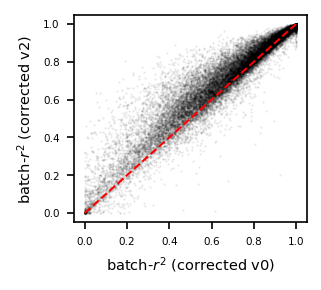

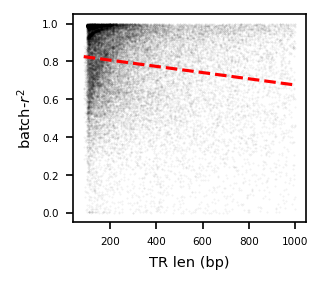

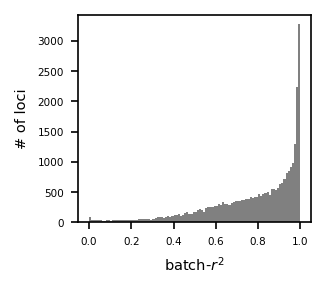

mean batch-r2 0.461 --> 0.548 for loci not estimated in v0


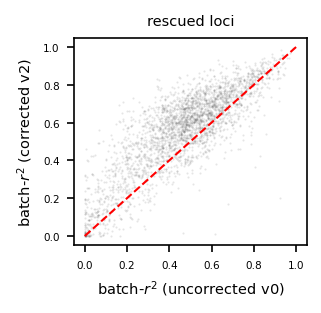

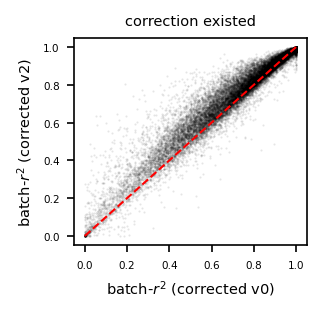

In [162]:
def test():
    df = pd.read_csv("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hprc/full.v1/analysis8/r2/output/dosage.r2.tsv", sep="\t", na_values=".")
    r2s = df["dosage.r2.corrected"].to_numpy()
    r2s_ = df["dosage.r2.uncorrected"].to_numpy()
    ws = np.arange(0,0.22,0.02)
    w = 0.12
    wi = np.nonzero(ws==w)[0][0]
    r2s_v2 = r2s_ws[:,wi]
    
    m0 = np.isfinite(r2s)
    m1 = np.isfinite(r2s_v2)
    mn0 = np.mean(r2s[m0])
    mn1 = np.mean(r2s_v2[m1])
    n0 = np.sum(r2s!=r2s_)
    n1 = np.sum(m1)
    print(f"mean batch-r2 {mn0:.4f} (n={n0})--> {mn1:.4f} (n={n1})")

    
    fig, ax = utils.plot(r2s, r2s_v2, "batch-$r^2$ (corrected v0)", "batch-$r^2$ (corrected v2)", alpha=0.1, get_ax=True)
    ax.plot([0,1],[0,1], '--r', lw=1)
    plt.show(); plt.close()
    
    xs = np.nanmean(trlens[:,gsmask], axis=1)
    m = (xs < 1000) & (xs > 85)
    xs, ys = xs[m], r2s_v2[m]
    xym = np.isfinite(xs) & np.isfinite(ys)
    xs, ys = xs[xym], ys[xym]
    bs = sm.OLS(ys, sm.add_constant(xs)).fit().params
    xps = np.array([min(xs), max(xs)])
    yps = bs[0] + bs[1]*xps
    fig, ax = utils.plot(xs, ys, "TR len (bp)", "batch-$r^2$", alpha=0.05, get_ax=True)
    ax.plot(xps, yps, '--r')
    plt.show(); plt.close()
    
    utils.hist(r2s_v2, "batch-$r^2$", "# of loci")

    m = (r2s==r2s_)
    mn0 = np.mean(r2s[m])
    r2s_v2_ = np.copy(r2s_v2)
    m1 = ~np.isfinite(r2s_v2_)
    r2s_v2_[m1] = r2s_[m1]
    mn1 = np.mean(r2s_v2_[m])
    print(f"mean batch-r2 {mn0:.3f} --> {mn1:.3f} for loci not estimated in v0")
    fig, ax = utils.plot(r2s[m], r2s_v2[m], "batch-$r^2$ (uncorrected v0)", "batch-$r^2$ (corrected v2)", "rescued loci", alpha=0.1, get_ax=True)
    ax.plot([0,1],[0,1], '--r', lw=1)
    plt.show(); plt.close()

    fig, ax = utils.plot(r2s[~m], r2s_v2[~m], "batch-$r^2$ (corrected v0)", "batch-$r^2$ (corrected v2)", "correction existed", alpha=0.1, get_ax=True)
    ax.plot([0,1],[0,1], '--r', lw=1)
    plt.show(); plt.close()
test()

# v2.1 check w/o 0 insertion

In [16]:
def test():
    ntr, ng = bias_v1.shape
    r2s = np.full(ntr, np.nan)
    famat = fagt[:,gsmask]
    ilmat = np.copy(ilagt)
    for tri in range(ntr):
        if tri % 1000 == 0: print(".", end="", flush=True)
        
        si = ki_tr[tri-1] if tri else 0
        ei = ki_tr[tri]
        X = np.sum(famat[si:ei,:], axis=0)
        Y = np.sum(ilmat[si:ei,:], axis=0)
        m = np.isfinite(X)
        x = X[m]
        if np.all(bias_v21[tri]==1):
            continue
        Ya = Y / bias_v21[tri]
        ya = Ya[m]
        if np.unique(x).size == 1 or np.all(ya==0):
            continue
        rega = sm.OLS(ya, sm.add_constant(x)).fit()
        r2s[tri] = rega.rsquared
    return r2s
r2s_v21_no0 = test()

...............................

In [31]:
np.sum(r2s_v21_no0>0.1)

10175

In [28]:
def test():
    ntr, ng = bias_v1.shape
    r2s = np.full([ntr], np.nan)
    famat = fagt[:,gsmask]
    ilmat = np.copy(ilagt)
    for tri in range(ntr):
        if tri % 1000 == 0: print(".", end="", flush=True)
        
        si = ki_tr[tri-1] if tri else 0
        ei = ki_tr[tri]
        X = np.sum(famat[si:ei,:], axis=0)
        Y = np.sum(ilmat[si:ei,:], axis=0)
        m = np.isfinite(X)
        x = X[m]
        y = Y[m]
        if np.unique(x).size == 1 or np.all(y==0):
            continue
        rega = sm.OLS(y, sm.add_constant(x)).fit()
        r2s[tri] = rega.rsquared
    return r2s
r2s_nocor_no0 = test()

...............................

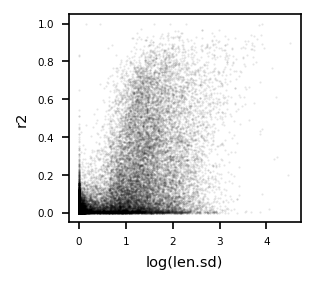

0.5309755084267587


In [30]:
def test():
    sds = np.nanstd(trlens, axis=1)
    utils.plot(np.log10(sds+1), r2s_v21_no0, "log(len.sd)", "r2", alpha=0.1)
    m = sds > 1000
    print(np.nanmean(r2s_v21_no0[m]))
test()

200 confident loci (r2>0.7) w/o correction got worse in v2.1
863 confident loci (r2>0.7) in v2.1 was worse w/o correction


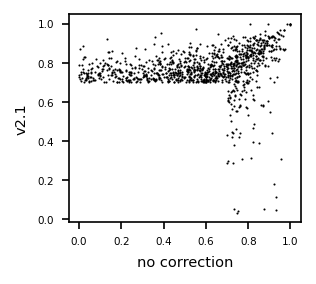

In [181]:
def test():
    TH = 0.7
    m =  (r2s_nocor_no0 > TH) | (r2s_ws_no0[:,7] > TH)
    n0 = np.sum((r2s_nocor_no0 > TH) & (r2s_nocor_no0 > r2s_ws_no0[:,7]))
    n1 = np.sum((r2s_ws_no0[:,7] > TH) & (r2s_nocor_no0 < r2s_ws_no0[:,7]))
    print(f"{n0} confident loci (r2>{TH}) w/o correction got worse in v2.1")
    print(f"{n1} confident loci (r2>{TH}) in v2.1 was worse w/o correction")
    xs = r2s_nocor_no0[m]
    ys = r2s_ws_no0[m,7]
    utils.plot(xs, ys, "no correction", "v2.1")
test()

mean batch-r2 0.7438 (n=27550)--> 0.1627 (n=25875)


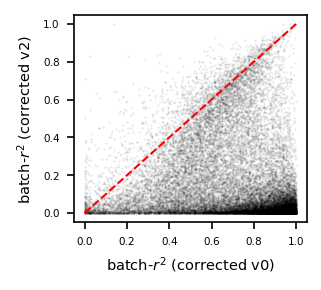

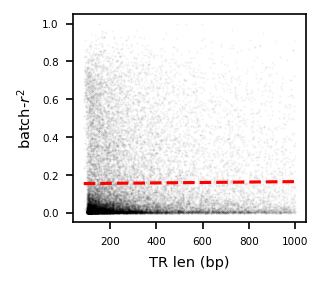

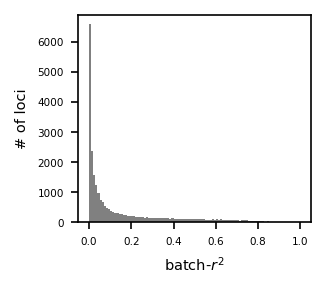

mean batch-r2 0.461 --> 0.371 for loci not estimated in v0


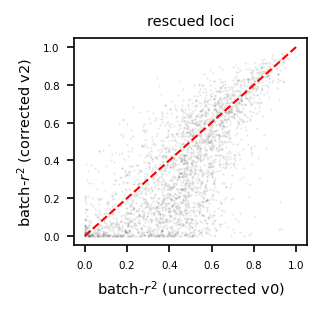

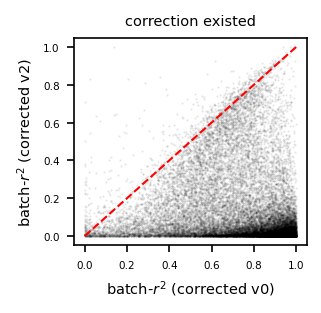

In [165]:
# test no 0 insertion
def test():
    df = pd.read_csv("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hprc/full.v1/analysis8/r2/output/dosage.r2.tsv", sep="\t", na_values=".")
    r2s = df["dosage.r2.corrected"].to_numpy()
    r2s_ = df["dosage.r2.uncorrected"].to_numpy()
    ws = np.arange(0,0.22,0.02)
    w = 0.12
    wi = np.nonzero(ws==w)[0][0]
    r2s_v2 = r2s_ws_no0[:,wi]
    
    m0 = np.isfinite(r2s)
    m1 = np.isfinite(r2s_v2)
    mn0 = np.mean(r2s[m0])
    mn1 = np.mean(r2s_v2[m1])
    n0 = np.sum(r2s!=r2s_)
    n1 = np.sum(m1)
    print(f"mean batch-r2 {mn0:.4f} (n={n0})--> {mn1:.4f} (n={n1})")

    
    fig, ax = utils.plot(r2s, r2s_v2, "batch-$r^2$ (corrected v0)", "batch-$r^2$ (corrected v2)", alpha=0.1, get_ax=True)
    ax.plot([0,1],[0,1], '--r', lw=1)
    plt.show(); plt.close()
    
    xs = np.nanmean(trlens[:,gsmask], axis=1)
    m = (xs < 1000) & (xs > 85)
    xs, ys = xs[m], r2s_v2[m]
    xym = np.isfinite(xs) & np.isfinite(ys)
    xs, ys = xs[xym], ys[xym]
    bs = sm.OLS(ys, sm.add_constant(xs)).fit().params
    xps = np.array([min(xs), max(xs)])
    yps = bs[0] + bs[1]*xps
    fig, ax = utils.plot(xs, ys, "TR len (bp)", "batch-$r^2$", alpha=0.05, get_ax=True)
    ax.plot(xps, yps, '--r')
    plt.show(); plt.close()
    
    utils.hist(r2s_v2, "batch-$r^2$", "# of loci")

    m = (r2s==r2s_)
    mn0 = np.mean(r2s[m])
    r2s_v2_ = np.copy(r2s_v2)
    m1 = ~np.isfinite(r2s_v2_)
    r2s_v2_[m1] = r2s_[m1]
    mn1 = np.mean(r2s_v2_[m])
    print(f"mean batch-r2 {mn0:.3f} --> {mn1:.3f} for loci not estimated in v0")
    fig, ax = utils.plot(r2s[m], r2s_v2[m], "batch-$r^2$ (uncorrected v0)", "batch-$r^2$ (corrected v2)", "rescued loci", alpha=0.1, get_ax=True)
    ax.plot([0,1],[0,1], '--r', lw=1)
    plt.show(); plt.close()

    fig, ax = utils.plot(r2s[~m], r2s_v2[~m], "batch-$r^2$ (corrected v0)", "batch-$r^2$ (corrected v2)", "correction existed", alpha=0.1, get_ax=True)
    ax.plot([0,1],[0,1], '--r', lw=1)
    plt.show(); plt.close()
test()

In [ ]:
# check highly variable loci

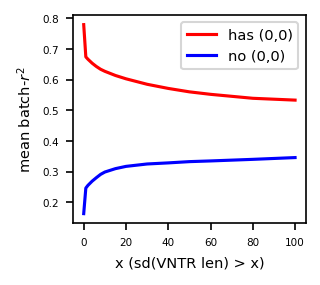

In [29]:
def test():
    sds = np.nanstd(trlens, axis=1)
    sd_ths = np.array([0,1,2,4,6,8,10,15,20,30,40,50,60,80,100])
    N = sd_ths.size
    ns = np.zeros(N)
    ys_no0 = np.zeros(N)
    ys_0 = np.zeros(N)
    for i, sd_th in enumerate(sd_ths):
        trimask = sds >= sd_th
        ns[i] = np.sum(trimask)
        ys_no0[i] = np.nanmean(r2s_v21_no0[trimask])
        ys_0[i] = np.nanmean(r2s_v21[trimask])
    fig, ax = utils.plot(sd_ths, ys_0, "x (sd(VNTR len) > x)", "mean batch-$r^2$", m='-', c='r', get_ax=True, label="has (0,0)")
    ax.plot(sd_ths, ys_no0, '-b', label="no (0,0)")
    
    plt.legend()
    plt.show(); plt.close()
    return
test()

In [ ]:
def test():
    

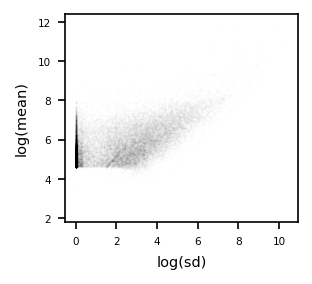

2733 highly variable loci (sd>100)


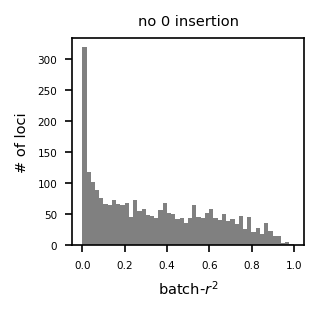

mean r2 w/o 0 insertion for those loci = 0.346


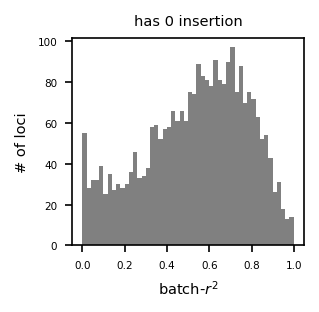

mean r2 w 0 insertion for those loci = 0.533
...............................
r2 0.977 if locus-specific biases are removed


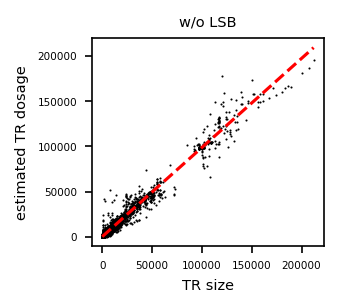

r2 0.047 if locus-specific biases are present


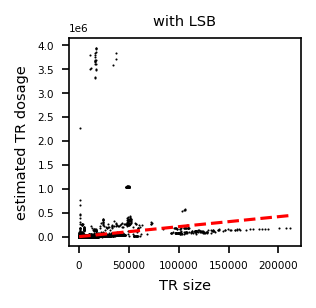

checking only loci w sd<=100
r2 0.983 if locus-specific biases are removed


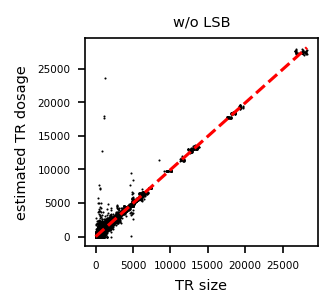

r2 0.315 if locus-specific biases are present


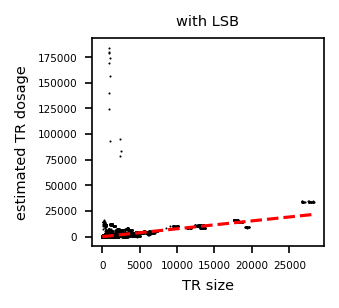

In [22]:
def test():
    sds = np.nanstd(trlens, axis=1)
    mns = np.nanmean(trlens, axis=1)
    utils.plot(np.log(sds+1), np.log(mns+1), "log(sd)", "log(mean)", alpha=0.01)
    n0 = np.sum(trimask)
    print(f"{n0} highly variable loci (sd>100)")

    utils.hist(r2s_v21_no0[trimask], "batch-$r^2$", "# of loci", "no 0 insertion", bins=50)
    v1 = np.nanmean(r2s_v21_no0[trimask])
    print(f"mean r2 w/o 0 insertion for those loci = {v1:.3f}")

    utils.hist(r2s_v21[trimask], "batch-$r^2$", "# of loci", "has 0 insertion", bins=50)
    v2 = np.nanmean(r2s_v21[trimask])
    print(f"mean r2 w 0 insertion for those loci = {v2:.3f}")
    
    ntr, ng = bias_v1.shape
    famat = fagt[:,gsmask]
    ilmat = np.copy(ilagt)
    Xoi = np.full([ntr,ng], np.nan)
    Yoi = np.full([ntr,ng], np.nan)
    lbs = np.full(ntr, np.nan)
    for tri in range(ntr):
        if tri % 1000 == 0: print(".", end="", flush=True)
        
        si = ki_tr[tri-1] if tri else 0
        ei = ki_tr[tri]
        X = np.sum(famat[si:ei,:], axis=0)
        Y = np.sum(ilmat[si:ei,:], axis=0)
        m = np.isfinite(X)
        x = X[m]
        ya = Y[m] / bias_v21[tri,m]
        if np.unique(x).size == 1 or np.all(ya==0):
            continue
        Xoi[tri,m] = x
        mnx = np.mean(x)
        lbs[tri] = np.mean(ya) / mnx
        Yoi[tri,m] = ya / lbs[tri]
    print()
    
    m = np.isfinite(Xoi)
    xs = Xoi[m].flatten()
    ys = Yoi[m].flatten()
    rega = sm.OLS(ys, sm.add_constant(xs)).fit()
    r2 = rega.rsquared
    bs = rega.params
    fig, ax = utils.plot(xs, ys, "TR size", "estimated TR dosage", "w/o LSB", get_ax=True)
    xps = np.array([min(xs), max(xs)])
    yps = bs[0] + bs[1]*xps
    ax.plot(xps, yps, '--r')
    print(f"r2 {r2:.3f} if locus-specific biases are removed")
    plt.show(); plt.close()
    
    ys_raw = (Yoi*lbs[:,None])[m].flatten()
    rega = sm.OLS(ys_raw, sm.add_constant(xs)).fit()
    r2 = rega.rsquared
    bs = rega.params
    fig, ax = utils.plot(xs, ys_raw, "TR size", "estimated TR dosage", "with LSB", get_ax=True)
    xps = np.array([min(xs), max(xs)])
    yps = bs[0] + bs[1]*xps
    ax.plot(xps, yps, '--r')
    print(f"r2 {r2:.3f} if locus-specific biases are present")
    plt.show(); plt.close()
    
    print("checking only loci w sd<=100")
    Xoi1 = Xoi[~trimask]
    Yoi1 = Yoi[~trimask]
    m = np.isfinite(Xoi1)
    xs = Xoi1[m].flatten()
    ys = Yoi1[m].flatten()
    rega = sm.OLS(ys, sm.add_constant(xs)).fit()
    r2 = rega.rsquared
    bs = rega.params
    fig, ax = utils.plot(xs, ys, "TR size", "estimated TR dosage", "w/o LSB", get_ax=True)
    xps = np.array([min(xs), max(xs)])
    yps = bs[0] + bs[1]*xps
    ax.plot(xps, yps, '--r')
    print(f"r2 {r2:.3f} if locus-specific biases are removed")
    plt.show(); plt.close()
    
    ys_raw = (Yoi1*lbs[~trimask,None])[m].flatten()
    rega = sm.OLS(ys_raw, sm.add_constant(xs)).fit()
    r2 = rega.rsquared
    bs = rega.params
    fig, ax = utils.plot(xs, ys_raw, "TR size", "estimated TR dosage", "with LSB", get_ax=True)
    xps = np.array([min(xs), max(xs)])
    yps = bs[0] + bs[1]*xps
    ax.plot(xps, yps, '--r')
    print(f"r2 {r2:.3f} if locus-specific biases are present")
    plt.show(); plt.close()

test()

# Bias correction v2.2
- remove weight over TR:flank
- if has TR ikmer: compute bias using TR ikmer
- else:
    - if has flank ikmer: compute bias using flank ikmer
    - else: set bias to 1

In [107]:
def test():
    # loci with TR ikmer
    m = ikcovmat[:,0,0].astype(bool) # ikcovmat[:,:,t] t=1 for flank, t=0 for TR
    bias_v2 = np.copy(ikcovmat[:,:,0])
    bias_v2[~m] = ikcovmat[~m,:,1]
    bias_v2[bias_v2==0] = np.nan
    rds = np.loadtxt("/project/mchaisso_100/cmb-17/vntr_genotyping/analysis/read_depth/ctrl/HPRC.chr1.cov.tsv", usecols=1)
    bias_v2 /= rds
    bias_v2 /= np.nanmean(bias_v2, axis=1)[:,None]
    bias_v2[~np.isfinite(bias_v2)] = 1 
    return bias_v2
bias_v2 = test()

/tmp/SLURM_23715689/ipykernel_1118/889063209.py:9: RuntimeWarning: Mean of empty slice
  bias_v2 /= np.nanmean(bias_v2, axis=1)[:,None]


In [108]:
def test():
    ntr, ng = bias_v1.shape
    r2s_v2 = np.full(ntr, np.nan)
    famat = fagt[:,gsmask]
    ilmat = np.copy(ilagt)
    for tri in range(ntr):
        if tri % 1000 == 0: print(".", end="", flush=True)
        
        si = ki_tr[tri-1] if tri else 0
        ei = ki_tr[tri]
        X = np.sum(famat[si:ei,:], axis=0)
        Y = np.sum(ilmat[si:ei,:], axis=0)
        m = np.isfinite(X)
        x = np.insert(X[m],0,0)
        if np.all(bias_v2[tri]==1):
            continue
        Ya = Y / bias_v2[tri]
        ya = np.insert(Ya[m],0,0)
        if np.unique(x).size == 1 or np.all(ya==0):
            continue
        rega = sm.OLS(ya, sm.add_constant(x)).fit()
        r2s_v2[tri] = rega.rsquared
    return r2s_v2
r2s_v2 = test()

...............................

mean batch-r2 0.7438 (n=27550)--> 0.7730 (n=30251)


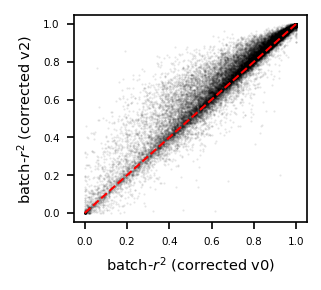

mean batch-r2 0.461 --> 0.548 for loci not estimated in v0


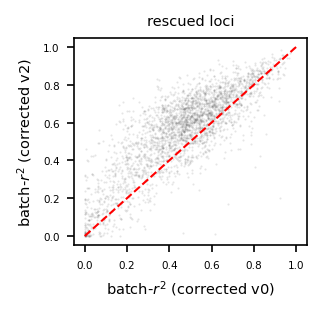

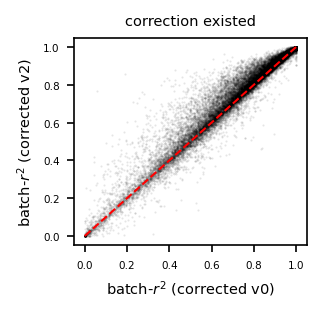

In [109]:
def test():
    df = pd.read_csv("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hprc/full.v1/analysis8/r2/output/dosage.r2.tsv", sep="\t", na_values=".")
    r2s = df["dosage.r2.corrected"].to_numpy()
    r2s_ = df["dosage.r2.uncorrected"].to_numpy()
    
    m0 = np.isfinite(r2s)
    m1 = np.isfinite(r2s_v2)
    mn0 = np.mean(r2s[m0])
    mn1 = np.mean(r2s_v2[m1])
    n0 = np.sum(r2s!=r2s_)
    n1 = np.sum(m1)
    print(f"mean batch-r2 {mn0:.4f} (n={n0})--> {mn1:.4f} (n={n1})")

    fig, ax = utils.plot(r2s, r2s_v2, "batch-$r^2$ (corrected v0)", "batch-$r^2$ (corrected v2)", alpha=0.1, get_ax=True)
    ax.plot([0,1],[0,1], '--r', lw=1)
    plt.show(); plt.close()

    m = (r2s==r2s_)
    mn0 = np.mean(r2s[m])
    r2s_v2_ = np.copy(r2s_v2)
    m1 = ~np.isfinite(r2s_v2_)
    r2s_v2_[m1] = r2s_[m1]
    mn1 = np.mean(r2s_v2_[m])
    print(f"mean batch-r2 {mn0:.3f} --> {mn1:.3f} for loci not estimated in v0")
    fig, ax = utils.plot(r2s[m], r2s_v2[m], "batch-$r^2$ (corrected v0)", "batch-$r^2$ (corrected v2)", "rescued loci", alpha=0.1, get_ax=True)
    ax.plot([0,1],[0,1], '--r', lw=1)
    plt.show(); plt.close()

    fig, ax = utils.plot(r2s[~m], r2s_v2[~m], "batch-$r^2$ (corrected v0)", "batch-$r^2$ (corrected v2)", "correction existed", alpha=0.1, get_ax=True)
    ax.plot([0,1],[0,1], '--r', lw=1)
    plt.show(); plt.close()
test()

# Bias correction v2.3
- if has TR ikmer: compute bias using TR ikmer
- else:
    - if has flank ikmer: compute bias using flank ikmer
    - else: set bias to 1
- Fix boundary problem in area-based weight
    - ikmer at TR/flank boundary is overweighted

In [59]:
# get ikmer pos. compute 
class ikmer_data_v1:
    def __init__(self):
        self.n = [] # name
        self.i = [] # TR index
        self.c = [] # copy num
        self.w = [] # weight ~ (sum of distance to neighboring (+1 or -1) ikmers) / (copy num)
        
def test():
    def get_ik2i(isTR):
        ik2i = {}
        ki_, ki = None, None
        kmc_, kmc = None, None
        ikmsi = len(ikm.n)
        ki0 = FS
        ki1 = kmers.size - FS
        if isTR:
            kis_kmers = [(ki,km) for ki, km in enumerate(kmers) if ki >= ki0 and ki < ki1]
        else:
            kis_kmers = [(ki,km) for ki, km in enumerate(kmers) if ki < ki0 or ki >= ki1]
            
        for ki, km in kis_kmers:
            if km in s_ikmers:
                if km not in ik2i:
                    ik2i[km] = [ki]
                else:
                    ik2i[km].append(ki)

                kmc = ikstats[tri2km2i[tri][km], 0] if isTR else fl_ikstats[fl_tri2km2i[tri][km], 0]
                d = ki - ki_ if ki_ is not None else 1
                ikm.n.append(km)
                ikm.i.append(tri)
                ikm.c.append(kmc)
                if ki_ is not None:
                    ikm.w[-1] += (d/kmc_)
                ikm.w.append(d/kmc)
                ki_ = ki
                kmc_ = kmc
        else:
            if kmc_ is not None:
                ikm.w[-1] += (1/kmc_)
                ikmei = len(ikm.n)
                W = np.sum(ikm.w[ikmsi:ikmei])
                for i in range(ikmsi, ikmei):
                    ikm.w[i] /= W
        return ik2i
        

    FS = 500
    ntr = ki_tr.size
    tri2ik2i_v23 = np.full(ntr, None, dtype=object)
    ikm = ikmer_data_v1()
    for tri in range(ntr):
        trlens = [len(v) if v else np.nan for v in trseqs[tri]] # this includes flanks
        hi = np.nanargmin(trlens)
        kmers = vu.read2kmers_noshift(trseqs[tri,hi], 21, dtype=int)

        # finding TR ikmer
        si = ki_tr[tri-1] if tri else 0
        ei = ki_tr[tri]
        if si != ei:
            isik = ikmer[si:ei]
            if np.sum(isik): # has TR ikmer
                ikmers_tr = km_arr[si:ei][isik]
                s_ikmers = set(ikmers_tr.tolist())
                ik2i = get_ik2i(isTR=True)
                tri2ik2i_v23[tri] = ik2i
                continue
                
        # no TR ikmer, finding flank ikmer
        si = fl_ki_tr[tri-1] if tri else 0
        ei = fl_ki_tr[tri]
        if si != ei:
            isfik = fl50_ikmer[si:ei]
            if np.sum(isfik): # has flank ikmer
                ikmers_fl = fl_km_arr[si:ei][isfik]        
                s_ikmers = set(ikmers_fl.tolist())
                ik2i = get_ik2i(isTR=False)
                tri2ik2i_v23[tri] = ik2i

    return tri2ik2i_v23, ikm
tri2ik2i_v23, ikdb_v23 = test()

In [60]:
np.unique(ikdb_v23.i).size, len(tri2ik2i_v23)

(30263, 30488)

In [61]:
def test():
    tri2ik2w_v23 = {} # >0 if is flank, <0 otherwise
    df = pd.DataFrame()
    df["name"] = ikdb_v23.n
    df["tri"] = ikdb_v23.i
    df["copy"] = ikdb_v23.c
    df["weight"] = ikdb_v23.w
    df["copy"] = df["copy"].astype(int)
    df["weight"] = df["weight"].astype(float)
    for dfi, (km, tri, w) in enumerate(zip(ikdb_v23.n, ikdb_v23.i, ikdb_v23.w)):
        if tri not in tri2ik2w_v23:
            tri2ik2w_v23[tri] = {}
        tri2ik2w_v23[tri][km] = w
    return df, tri2ik2w_v23
ik_df_v23, tri2ik2w_v23 = test()

In [63]:
def test():
    ntr = ki_tr.size
    gs = np.loadtxt(ilgsfile, dtype=object)
    ng = gs.size
    covs = np.full([ntr, ng], np.nan)
    for gi, gn in enumerate(gs):
        print(".", end="")
        with open(f"/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hprc/full.v1/analysis8/mapping/hprc/output1/{gn}.inv.name.kmers") as f:
            tri = -1
            for line in f:
                if line[0] == ">":
                    if tri >= 0 and cov != 0:
                        covs[tri,gi] = cov
                    tri += 1
                    cov = 0
                    ik2w = tri2ik2w_v23[tri] if tri in tri2ik2w_v23 else {}
                else:
                    km, ct = [int(v) for v in line.split()]
                    if km in ik2w:
                        w = ik2w[km]
                        cov += ct*w
    return covs
ikcovmat_v23 = test()

........................................

In [104]:
def test():
    # loci with TR ikmer
    bias_v23 = np.copy(ikcovmat_v23)
    bias_v23[bias_v23==0] = np.nan
    rds = np.loadtxt("/project/mchaisso_100/cmb-17/vntr_genotyping/analysis/read_depth/ctrl/HPRC.chr1.cov.tsv", usecols=1)
    bias_v23 /= rds
    bias_v23 /= np.nanmean(bias_v23, axis=1)[:,None]
    bias_v23[~np.isfinite(bias_v23)] = 1 
    return bias_v23
bias_v23 = test()

/tmp/SLURM_23715689/ipykernel_1118/2383089554.py:7: RuntimeWarning: Mean of empty slice
  bias_v23 /= np.nanmean(bias_v23, axis=1)[:,None]


In [105]:
def test():
    ntr, ng = bias_v1.shape
    r2s_v23 = np.full(ntr, np.nan)
    famat = fagt[:,gsmask]
    ilmat = np.copy(ilagt)
    for tri in range(ntr):
        if tri % 1000 == 0: print(".", end="", flush=True)
        
        si = ki_tr[tri-1] if tri else 0
        ei = ki_tr[tri]
        X = np.sum(famat[si:ei,:], axis=0)
        Y = np.sum(ilmat[si:ei,:], axis=0)
        m = np.isfinite(X)
        x = np.insert(X[m],0,0)
        if np.all(bias_v23[tri]==1):
            continue
        Ya = Y / bias_v23[tri]
        ya = np.insert(Ya[m],0,0)
        if np.unique(x).size == 1 or np.all(ya==0):
            continue
        rega = sm.OLS(ya, sm.add_constant(x)).fit()
        r2s_v23[tri] = rega.rsquared
    return r2s_v23
r2s_v23 = test()

...............................

mean batch-r2 0.7438 (n=27550)--> 0.7701 (n=30244)


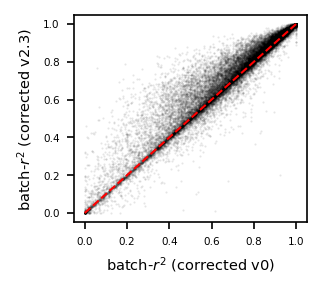

mean batch-r2 0.461 --> 0.548 for loci not estimated in v0


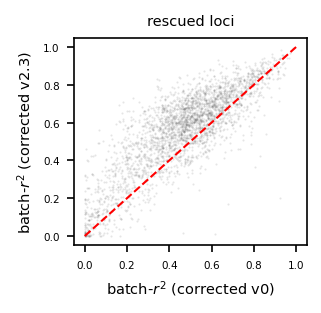

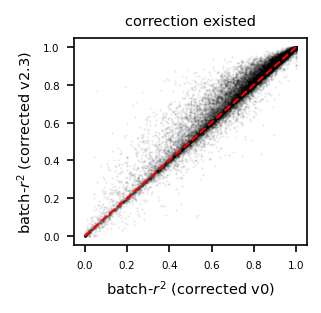

In [106]:
def test():
    df = pd.read_csv("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hprc/full.v1/analysis8/r2/output/dosage.r2.tsv", sep="\t", na_values=".")
    r2s = df["dosage.r2.corrected"].to_numpy()
    r2s_ = df["dosage.r2.uncorrected"].to_numpy()
    
    m0 = np.isfinite(r2s)
    m1 = np.isfinite(r2s_v23)
    mn0 = np.mean(r2s[m0])
    mn1 = np.mean(r2s_v23[m1])
    n0 = np.sum(r2s!=r2s_)
    n1 = np.sum(m1)
    print(f"mean batch-r2 {mn0:.4f} (n={n0})--> {mn1:.4f} (n={n1})")


    fig, ax = utils.plot(r2s, r2s_v23, "batch-$r^2$ (corrected v0)", "batch-$r^2$ (corrected v2.3)", alpha=0.1, get_ax=True)
    ax.plot([0,1],[0,1], '--r', lw=1)
    plt.show(); plt.close()

    m = (r2s==r2s_)
    mn0 = np.mean(r2s[m])
    r2s_v23_ = np.copy(r2s_v23)
    m1 = ~np.isfinite(r2s_v23_)
    r2s_v23_[m1] = r2s_[m1]
    mn1 = np.mean(r2s_v23_[m])
    print(f"mean batch-r2 {mn0:.3f} --> {mn1:.3f} for loci not estimated in v0")
    fig, ax = utils.plot(r2s[m], r2s_v23[m], "batch-$r^2$ (corrected v0)", "batch-$r^2$ (corrected v2.3)", "rescued loci", alpha=0.1, get_ax=True)
    ax.plot([0,1],[0,1], '--r', lw=1)
    plt.show(); plt.close()

    fig, ax = utils.plot(r2s[~m], r2s_v23[~m], "batch-$r^2$ (corrected v0)", "batch-$r^2$ (corrected v2.3)", "correction existed", alpha=0.1, get_ax=True)
    ax.plot([0,1],[0,1], '--r', lw=1)
    plt.show(); plt.close()
test()

mean batch-r2 0.7438 (n=27550)--> 0.7200 (n=30243)


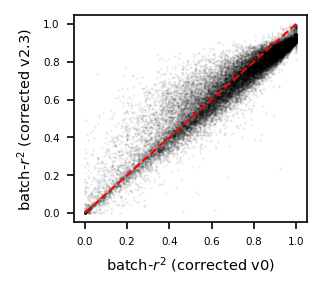

mean batch-r2 0.461 --> 0.536 for loci not estimated in v0


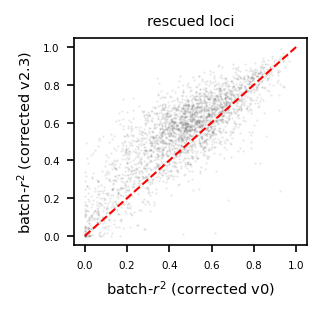

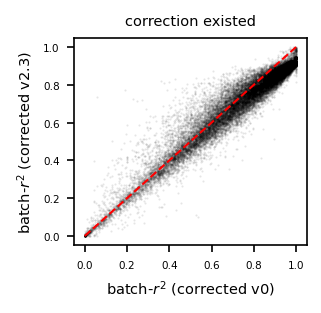

# bias correction v2.4
- same as v2.3 but unweighted. sanity check
- weighted method is indeed better

In [95]:
# get ikmer pos. compute 
class ikmer_data_v1:
    def __init__(self):
        self.n = [] # name
        self.i = [] # TR index
        self.c = [] # copy num
        self.w = [] # weight ~ (sum of distance to neighboring (+1 or -1) ikmers) / (copy num)
        
def test():
    def get_ik2i(isTR):
        ik2i = {}
        ki_, ki = None, None
        kmc_, kmc = None, None
        ikmsi = len(ikm.n)
        ki0 = FS
        ki1 = kmers.size - FS
        if isTR:
            kis_kmers = [(ki,km) for ki, km in enumerate(kmers) if ki >= ki0 and ki < ki1]
        else:
            kis_kmers = [(ki,km) for ki, km in enumerate(kmers) if ki < ki0 or ki >= ki1]
            
        for ki, km in kis_kmers:
            if km in s_ikmers:
                if km not in ik2i:
                    ik2i[km] = [ki]
                else:
                    ik2i[km].append(ki)

                kmc = ikstats[tri2km2i[tri][km], 0] if isTR else fl_ikstats[fl_tri2km2i[tri][km], 0]
                ikm.n.append(km)
                ikm.i.append(tri)
                ikm.c.append(kmc)
                ikm.w.append(1/kmc)
                kmc_ = kmc
        else:
            if kmc_ is not None:
                ikmei = len(ikm.n)
                W = np.sum(ikm.w[ikmsi:ikmei])
                for i in range(ikmsi, ikmei):
                    ikm.w[i] /= W
        return ik2i
        

    FS = 500
    ntr = ki_tr.size
    tri2ik2i_v24 = np.full(ntr, None, dtype=object)
    ikm = ikmer_data_v1()
    for tri in range(ntr):
        trlens = [len(v) if v else np.nan for v in trseqs[tri]] # this includes flanks
        hi = np.nanargmin(trlens)
        kmers = vu.read2kmers_noshift(trseqs[tri,hi], 21, dtype=int)

        # finding TR ikmer
        si = ki_tr[tri-1] if tri else 0
        ei = ki_tr[tri]
        if si != ei:
            isik = ikmer[si:ei]
            if np.sum(isik): # has TR ikmer
                ikmers_tr = km_arr[si:ei][isik]
                s_ikmers = set(ikmers_tr.tolist())
                ik2i = get_ik2i(isTR=True)
                tri2ik2i_v24[tri] = ik2i
                continue
                
        # no TR ikmer, finding flank ikmer
        si = fl_ki_tr[tri-1] if tri else 0
        ei = fl_ki_tr[tri]
        if si != ei:
            isfik = fl50_ikmer[si:ei]
            if np.sum(isfik): # has flank ikmer
                ikmers_fl = fl_km_arr[si:ei][isfik]        
                s_ikmers = set(ikmers_fl.tolist())
                ik2i = get_ik2i(isTR=False)
                tri2ik2i_v24[tri] = ik2i

    return tri2ik2i_v24, ikm
tri2ik2i_v24, ikdb_v24 = test()

In [96]:
np.unique(ikdb_v23.i).size, len(tri2ik2i_v23)

(30263, 30488)

(30263, 30488)

In [97]:
def test():
    tri2ik2w_v24 = {} # >0 if is flank, <0 otherwise
    df = pd.DataFrame()
    df["name"] = ikdb_v24.n
    df["tri"] = ikdb_v24.i
    df["copy"] = ikdb_v24.c
    df["weight"] = ikdb_v24.w
    df["copy"] = df["copy"].astype(int)
    df["weight"] = df["weight"].astype(float)
    for dfi, (km, tri, w) in enumerate(zip(ikdb_v24.n, ikdb_v24.i, ikdb_v24.w)):
        if tri not in tri2ik2w_v24:
            tri2ik2w_v24[tri] = {}
        tri2ik2w_v24[tri][km] = w
    return df, tri2ik2w_v24
ik_df_v24, tri2ik2w_v24 = test()

In [99]:
def test():
    ntr = ki_tr.size
    gs = np.loadtxt(ilgsfile, dtype=object)
    ng = gs.size
    covs = np.full([ntr, ng], np.nan)
    for gi, gn in enumerate(gs):
        print(".", end="")
        with open(f"/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hprc/full.v1/analysis8/mapping/hprc/output1/{gn}.inv.name.kmers") as f:
            tri = -1
            for line in f:
                if line[0] == ">":
                    if tri >= 0 and cov != 0:
                        covs[tri,gi] = cov
                    tri += 1
                    cov = 0
                    ik2w = tri2ik2w_v24[tri] if tri in tri2ik2w_v24 else {}
                else:
                    km, ct = [int(v) for v in line.split()]
                    if km in ik2w:
                        w = ik2w[km]
                        cov += ct*w
    return covs
ikcovmat_v24 = test()

........................................

In [110]:
def test():
    # loci with TR ikmer
    bias_v24 = np.copy(ikcovmat_v24)
    bias_v24[bias_v24==0] = np.nan
    rds = np.loadtxt("/project/mchaisso_100/cmb-17/vntr_genotyping/analysis/read_depth/ctrl/HPRC.chr1.cov.tsv", usecols=1)
    bias_v24 /= rds
    bias_v24 /= np.nanmean(bias_v24, axis=1)[:,None]
    bias_v24[~np.isfinite(bias_v24)] = 1 
    return bias_v24
bias_v24 = test()

/tmp/SLURM_23715689/ipykernel_1118/866518980.py:7: RuntimeWarning: Mean of empty slice
  bias_v24 /= np.nanmean(bias_v24, axis=1)[:,None]


In [111]:
def test():
    ntr, ng = bias_v1.shape
    r2s_v24 = np.full(ntr, np.nan)
    famat = fagt[:,gsmask]
    ilmat = np.copy(ilagt)
    for tri in range(ntr):
        if tri % 1000 == 0: print(".", end="", flush=True)
        
        si = ki_tr[tri-1] if tri else 0
        ei = ki_tr[tri]
        X = np.sum(famat[si:ei,:], axis=0)
        Y = np.sum(ilmat[si:ei,:], axis=0)
        m = np.isfinite(X)
        x = np.insert(X[m],0,0)
        if np.all(bias_v24[tri]==1):
            continue
        Ya = Y / bias_v24[tri]
        ya = np.insert(Ya[m],0,0)
        if np.unique(x).size == 1 or np.all(ya==0):
            continue
        rega = sm.OLS(ya, sm.add_constant(x)).fit()
        r2s_v24[tri] = rega.rsquared
    return r2s_v24
r2s_v24 = test()

...............................

mean batch-r2 0.7438 (n=27550)--> 0.7512 (n=30244)


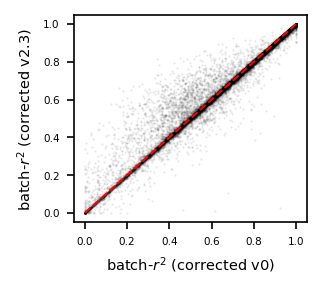

mean batch-r2 0.461 --> 0.523 for loci not estimated in v0


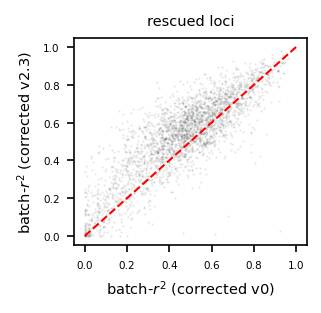

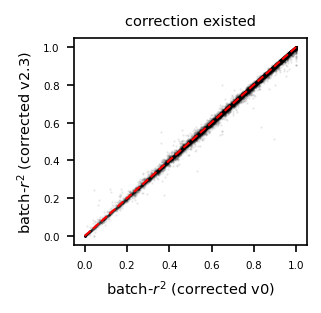

In [112]:
def test():
    df = pd.read_csv("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hprc/full.v1/analysis8/r2/output/dosage.r2.tsv", sep="\t", na_values=".")
    r2s = df["dosage.r2.corrected"].to_numpy()
    r2s_ = df["dosage.r2.uncorrected"].to_numpy()
    
    m0 = np.isfinite(r2s)
    m1 = np.isfinite(r2s_v24)
    mn0 = np.mean(r2s[m0])
    mn1 = np.mean(r2s_v24[m1])
    n0 = np.sum(r2s!=r2s_)
    n1 = np.sum(m1)
    print(f"mean batch-r2 {mn0:.4f} (n={n0})--> {mn1:.4f} (n={n1})")

    fig, ax = utils.plot(r2s, r2s_v24, "batch-$r^2$ (corrected v0)", "batch-$r^2$ (corrected v2.3)", alpha=0.1, get_ax=True)
    ax.plot([0,1],[0,1], '--r', lw=1)
    plt.show(); plt.close()

    m = (r2s==r2s_)
    mn0 = np.mean(r2s[m])
    r2s_v24_ = np.copy(r2s_v24)
    m1 = ~np.isfinite(r2s_v24_)
    r2s_v24_[m1] = r2s_[m1]
    mn1 = np.mean(r2s_v24_[m])
    print(f"mean batch-r2 {mn0:.3f} --> {mn1:.3f} for loci not estimated in v0")
    fig, ax = utils.plot(r2s[m], r2s_v24[m], "batch-$r^2$ (corrected v0)", "batch-$r^2$ (corrected v2.3)", "rescued loci", alpha=0.1, get_ax=True)
    ax.plot([0,1],[0,1], '--r', lw=1)
    plt.show(); plt.close()

    fig, ax = utils.plot(r2s[~m], r2s_v24[~m], "batch-$r^2$ (corrected v0)", "batch-$r^2$ (corrected v2.3)", "correction existed", alpha=0.1, get_ax=True)
    ax.plot([0,1],[0,1], '--r', lw=1)
    plt.show(); plt.close()
test()

# ??

# obsolete

In [362]:
# # r2 computed using /project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hgsvc/clinic/bias/invariant_kmer/log1/batch_r2.sh
# def test():
#     ntr, ng = bias.shape
#     nk = ccki_tr[-1]
#     NB = 64
#     BS = ntr // NB
#     R2 = np.full(nk, np.nan)
#     R2a = np.full(nk, np.nan)
#     for bi in range(NB):
#         with open(f"/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hgsvc/clinic/bias/invariant_kmer/output1/r2.{bi}.pickle", 'rb') as f:
#             r2, r2a = pickle.load(f)
#         tri0 = bi*BS
#         tri1 = (bi+1)*BS-1 if bi != NB-1 else ntr-1
#         si = ccki_tr[tri0-1] if tri0 else 0
#         ei = ccki_tr[tri1]
#         R2[si:ei] = r2[si:ei]
#         R2a[si:ei] = r2a[si:ei]
#     return R2, R2a
# R2_all_mtf, R2a_all_mtf = test()

In [363]:
# def test():
#     with open(f"/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hgsvc/clinic/bias/invariant_kmer/output1/R2_all_mtf.R2a_all_mtf.pickle", 'wb') as f:
#         pickle.dump((R2_all_mtf, R2a_all_mtf), f)
# # test()

/home1/tsungyul/.conda/envs/nb/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
/home1/tsungyul/.conda/envs/nb/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


All loci n=80,518
0.538 -> 0.626


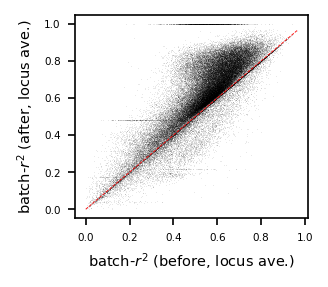

In [364]:
# def test():
#     ntr, ng = bias.shape
#     R2 = np.full(ntr, np.nan)
#     R2a = np.full(ntr, np.nan)
#     for tri in range(ntr):
#         si = ccki_tr[tri-1] if tri else 0
#         ei = ccki_tr[tri]
#         R2[tri] = np.nanmean(R2_all_mtf[si:ei])
#         R2a[tri] = np.nanmean(R2a_all_mtf[si:ei])
#     print(f"All loci n={R2.size:,}")
#     print(f"{np.nanmean(R2):.3f} -> {np.nanmean(R2a):.3f}")
#     xl = [np.nanmin(R2), np.nanmax(R2)]
#     plt.figure(dpi=150, figsize=(2,1.8))
#     plt.plot(R2, R2a, '.k', mew=0, markersize=1, alpha=0.1)
#     plt.plot(xl, xl, '--r', lw=0.4)
#     plt.xlabel("batch-$r^2$ (before, locus ave.)")
#     plt.ylabel("batch-$r^2$ (after, locus ave.)")
#     plt.show(); plt.close()
#     return R2, R2a
# R2_all_loci, R2a_all_loci = test()

All motifs n=4,456,881
0.499 -> 0.532


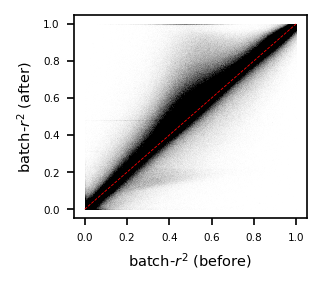

In [366]:
# def test():
#     R2, R2a = R2_all_mtf, R2a_all_mtf
#     print(f"All motifs n={R2_all_mtf.size:,}")
#     print(f"{np.nanmean(R2):.3f} -> {np.nanmean(R2a):.3f}")
#     xl = [np.nanmin(R2), np.nanmax(R2)]
#     plt.figure(dpi=150, figsize=(2,1.8))
#     plt.plot(R2, R2a, '.k', mew=0, markersize=1, alpha=0.002)
#     plt.plot(xl, xl, '--r', lw=0.4)
#     plt.xlabel("batch-$r^2$ (before)")
#     plt.ylabel("batch-$r^2$ (after)")
#     plt.show(); plt.close()
# test()

All loci n=80,518
0.534 -> 0.795


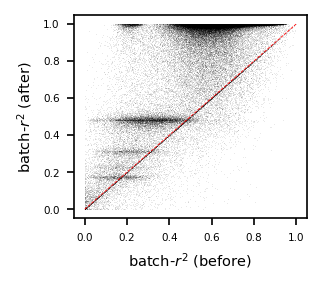

In [375]:
def test():
    ntr, ng = bias.shape
    R2 = np.full(ntr, np.nan)
    R2a = np.full(ntr, np.nan)
    for tri in range(ntr):
        si, ei = get_ki(tri)
        x = np.sum(pbgt[:,si:ei], axis=1)
        y = np.sum(ilagt[:,si:ei], axis=1)
        m = (x > 0) | (y > 0)
        ya = np.sum(ilagt[:,si:ei]/(bias[tri][:,None]), axis=1)
        x = np.insert(x[m],0,0)
        y = np.insert(y[m],0,0)
        ya = np.insert(ya[m],0,0)
        if x.size == 0 or np.unique(x).size==1:
            continue
        R2[tri] = sm.OLS(y, sm.add_constant(x)).fit().rsquared
        R2a[tri] = sm.OLS(ya, sm.add_constant(x)).fit().rsquared
    print(f"All loci n={R2.size:,}")
    print(f"{np.nanmean(R2):.3f} -> {np.nanmean(R2a):.3f}")
    xl = [np.nanmin(R2), np.nanmax(R2)]
    plt.figure(dpi=150, figsize=(2,1.8))
    plt.plot(R2, R2a, '.k', mew=0, markersize=1, alpha=0.1)
    plt.plot(xl, xl, '--r', lw=0.4)
    plt.xlabel("batch-$r^2$ (before)")
    plt.ylabel("batch-$r^2$ (after)")
    plt.show(); plt.close()
    return R2, R2a
R2_all_loci, R2a_all_loci = test()

- loci with great improvement

636


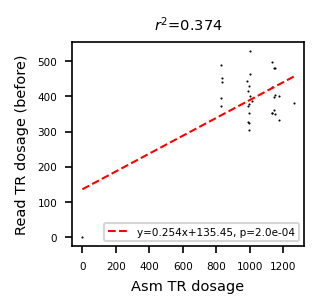

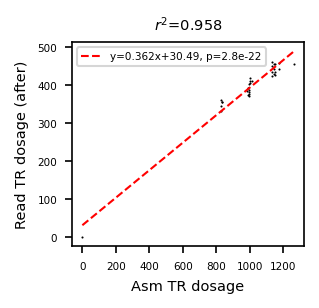

KeyboardInterrupt: Interrupted by user

In [397]:
def test():
    ntr, ng = bias.shape
    for tri in range(ntr):
        si, ei = get_ki(tri)
        x = np.sum(pbgt[:,si:ei], axis=1)
        y = np.sum(ilagt[:,si:ei], axis=1)
        m = (x > 0) | (y > 0)
        ya = np.sum(ilagt[:,si:ei]/(bias[tri][:,None]), axis=1)
        x = np.insert(x[m],0,0)
        y = np.insert(y[m],0,0)
        ya = np.insert(ya[m],0,0)
        if x.size == 0 or np.unique(x).size==1:
            continue
        r2 = sm.OLS(y, sm.add_constant(x)).fit().rsquared
        r2a = sm.OLS(ya, sm.add_constant(x)).fit().rsquared
        if r2a > 0.9 and r2 < 0.6 and np.nanstd(x[1:]) > 100:
            print(tri)
            utils.fastregplt(x, y, xlab="Asm TR dosage", ylab="Read TR dosage (before)", title=f"$r^2$={r2:.3f}")
            utils.fastregplt(x, ya, xlab="Asm TR dosage", ylab="Read TR dosage (after)", title=f"$r^2$={r2a:.3f}")
            input()
test()

- loci around y=0.5

80


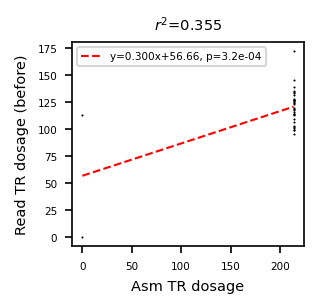

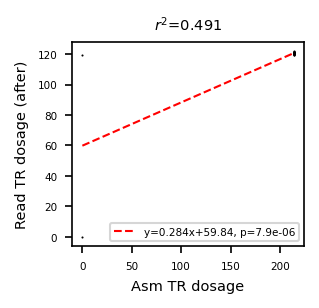

KeyboardInterrupt: Interrupted by user

In [398]:
def test():
    ntr, ng = bias.shape
    for tri in range(ntr):
        si, ei = get_ki(tri)
        x = np.sum(pbgt[:,si:ei], axis=1)
        y = np.sum(ilagt[:,si:ei], axis=1)
        m = (x > 0) | (y > 0)
        ya = np.sum(ilagt[:,si:ei]/(bias[tri][:,None]), axis=1)
        x = np.insert(x[m],0,0)
        y = np.insert(y[m],0,0)
        ya = np.insert(ya[m],0,0)
        if x.size == 0 or np.unique(x).size==1:
            continue
        r2 = sm.OLS(y, sm.add_constant(x)).fit().rsquared
        r2a = sm.OLS(ya, sm.add_constant(x)).fit().rsquared
        if abs(r2a-0.5) < 0.01 and r2 > 0.2 and r2 < 0.4:
            print(tri)
            utils.fastregplt(x, y, xlab="Asm TR dosage", ylab="Read TR dosage (before)", title=f"$r^2$={r2:.3f}")
            utils.fastregplt(x, ya, xlab="Asm TR dosage", ylab="Read TR dosage (after)", title=f"$r^2$={r2a:.3f}")
            input()
test()

- loci around y=0.33

180


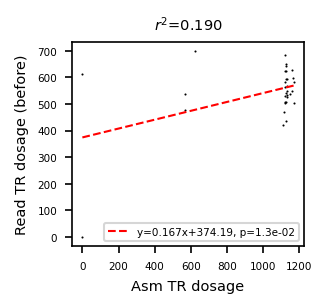

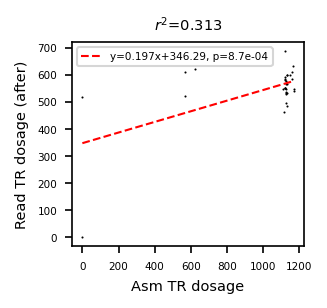

213


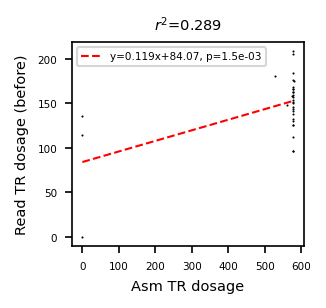

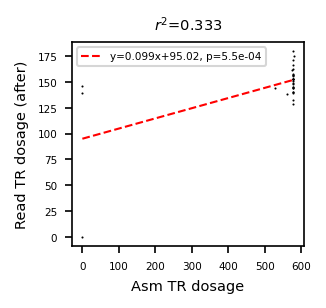

311


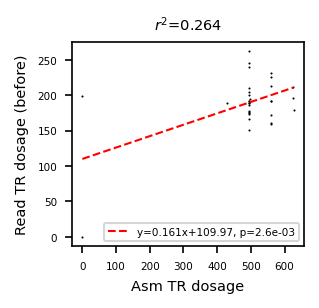

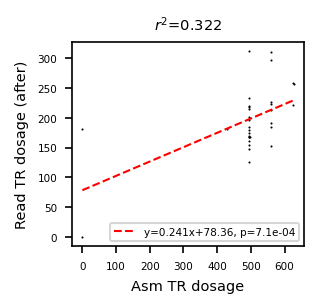

3627


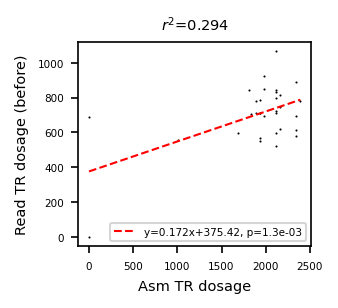

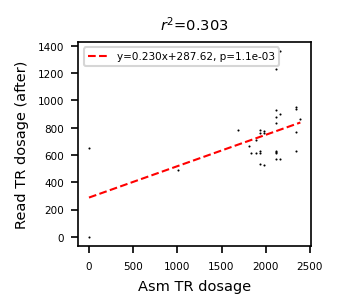

3721


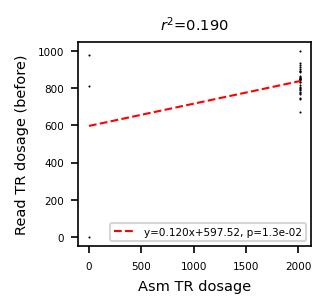

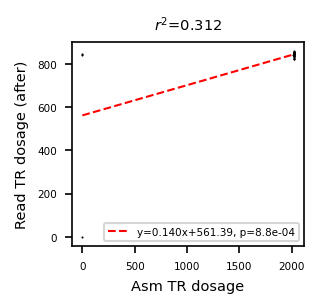

KeyboardInterrupt: Interrupted by user

In [399]:
def test():
    ntr, ng = bias.shape
    for tri in range(ntr):
        si, ei = get_ki(tri)
        x = np.sum(pbgt[:,si:ei], axis=1)
        y = np.sum(ilagt[:,si:ei], axis=1)
        m = (x > 0) | (y > 0)
        ya = np.sum(ilagt[:,si:ei]/(bias[tri][:,None]), axis=1)
        x = np.insert(x[m],0,0)
        y = np.insert(y[m],0,0)
        ya = np.insert(ya[m],0,0)
        if x.size == 0 or np.unique(x).size==1:
            continue
        r2 = sm.OLS(y, sm.add_constant(x)).fit().rsquared
        r2a = sm.OLS(ya, sm.add_constant(x)).fit().rsquared
        if r2a > 0.3 and r2a < 0.35 and r2 > 0.18 and r2 < 0.3:
            print(tri)
            utils.fastregplt(x, y, xlab="Asm TR dosage", ylab="Read TR dosage (before)", title=f"$r^2$={r2:.3f}")
            utils.fastregplt(x, ya, xlab="Asm TR dosage", ylab="Read TR dosage (after)", title=f"$r^2$={r2a:.3f}")
            input()
test()